In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
import numpy as np

dim=250
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
AType='1D Laplacian'


retrain_freq=1
e1 = 1e-3
e2 = 1e-10
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =500
InputDim=dim
HiddenDim=dim
HiddenDim2=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 250 dim problem. Playing with SGD.")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,HiddenDim2,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.HiddenDim2=HiddenDim2
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,HiddenDim2,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-05-27 14:36:29 [INFO] <ipython-input-4-93f3238a1a0b> 2 - Benchmark 250 dim problem. Playing with SGD.


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@nn_preconditioner_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,Err_list,ProbCount,restart,debug,refine,blist,reslist,IterErrList10,GmresRunTime):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *
Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]


debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)

logger.info("Runtime of forward function is:")
logger.info(forwardTime_Total)



0
1
2
loss: 2499378.5 0
loss: 2495040.5 1
loss: 2489249.75 2
loss: 2481344.0 3
loss: 2471261.0 4
loss: 2459009.5 5
loss: 2444805.0 6
loss: 2429016.5 7
loss: 2412056.0 8
loss: 2394197.0 9
loss: 2375711.75 10
loss: 2356762.25 11
loss: 2337425.75 12
loss: 2317989.5 13
loss: 2298456.5 14
loss: 2278887.0 15
loss: 2259305.0 16
loss: 2239720.0 17
loss: 2220174.0 18
loss: 2200681.0 19
loss: 2181255.0 20
loss: 2161907.25 21
loss: 2142647.5 22
loss: 2123484.25 23
loss: 2104424.0 24
loss: 2085473.0 25
loss: 2066636.0 26
loss: 2047917.25 27
loss: 2029320.25 28
loss: 2010848.375 29
loss: 1992503.875 30
loss: 1974289.0 31
loss: 1956205.625 32
loss: 1938255.125 33
loss: 1920439.0 34
loss: 1902758.125 35
loss: 1885213.25 36
loss: 1867805.0 37
loss: 1850534.0 38
loss: 1833400.625 39
loss: 1816404.875 40
loss: 1799546.75 41
loss: 1782826.375 42
loss: 1766243.875 43
loss: 1749798.75 44
loss: 1733490.875 45
loss: 1717320.125 46
loss: 1701285.75 47
loss: 1685387.5 48
loss: 1669625.25 49
loss: 1653997.75 50

loss: 65854.78125 501
loss: 65684.921875 502
loss: 65516.6796875 503
loss: 65350.0390625 504
loss: 65185.015625 505
loss: 65021.546875 506
loss: 64859.6328125 507
loss: 64699.28125 508
loss: 64540.4453125 509
loss: 64383.125 510
loss: 64227.3046875 511
loss: 64072.984375 512
loss: 63920.1171875 513
loss: 63768.66796875 514
loss: 63618.71875 515
loss: 63470.171875 516
loss: 63323.0234375 517
loss: 63177.265625 518
loss: 63032.91015625 519
loss: 62889.91796875 520
loss: 62748.2734375 521
loss: 62607.9609375 522
loss: 62469.0 523
loss: 62331.3203125 524
loss: 62194.97265625 525
loss: 62059.8984375 526
loss: 61926.09375 527
loss: 61793.5546875 528
loss: 61662.26171875 529
loss: 61532.203125 530
loss: 61403.3671875 531
loss: 61275.765625 532
loss: 61149.33203125 533
loss: 61024.109375 534
loss: 60900.046875 535
loss: 60777.15234375 536
loss: 60655.421875 537
loss: 60534.8046875 538
loss: 60415.3515625 539
loss: 60297.0 540
loss: 60179.75 541
loss: 60063.6015625 542
loss: 59948.5546875 543
l

loss: 47535.421875 900
loss: 47529.1171875 901
loss: 47522.8125 902
loss: 47516.5703125 903
loss: 47510.35546875 904
loss: 47504.1875 905
loss: 47498.05078125 906
loss: 47491.96875 907
loss: 47485.90234375 908
loss: 47479.8984375 909
loss: 47473.9140625 910
loss: 47467.96875 911
loss: 47462.0625 912
loss: 47456.1953125 913
loss: 47450.3515625 914
loss: 47444.55078125 915
loss: 47438.78515625 916
loss: 47433.0546875 917
loss: 47427.35546875 918
loss: 47421.703125 919
loss: 47416.0703125 920
loss: 47410.47265625 921
loss: 47404.921875 922
loss: 47399.390625 923
loss: 47393.89453125 924
loss: 47388.4375 925
loss: 47383.00390625 926
loss: 47377.6171875 927
loss: 47372.2421875 928
loss: 47366.91015625 929
loss: 47361.60546875 930
loss: 47356.328125 931
loss: 47351.09375 932
loss: 47345.8828125 933
loss: 47340.7109375 934
loss: 47335.5546875 935
loss: 47330.4375 936
loss: 47325.34765625 937
loss: 47320.2734375 938
loss: 47315.23828125 939
loss: 47310.234375 940
loss: 47305.26171875 941
loss:

loss: 46269.1015625 1313
loss: 46266.90625 1314
loss: 46264.6953125 1315
loss: 46262.51171875 1316
loss: 46260.32421875 1317
loss: 46258.125 1318
loss: 46255.9375 1319
loss: 46253.734375 1320
loss: 46251.54296875 1321
loss: 46249.3515625 1322
loss: 46247.1484375 1323
loss: 46244.9375 1324
loss: 46242.7421875 1325
loss: 46240.53515625 1326
loss: 46238.3359375 1327
loss: 46236.125 1328
loss: 46233.9140625 1329
loss: 46231.703125 1330
loss: 46229.5 1331
loss: 46227.2890625 1332
loss: 46225.078125 1333
loss: 46222.8671875 1334
loss: 46220.64453125 1335
loss: 46218.421875 1336
loss: 46216.2109375 1337
loss: 46213.98828125 1338
loss: 46211.7734375 1339
loss: 46209.54296875 1340
loss: 46207.3203125 1341
loss: 46205.09375 1342
loss: 46202.8671875 1343
loss: 46200.640625 1344
loss: 46198.40625 1345
loss: 46196.171875 1346
loss: 46193.9453125 1347
loss: 46191.71484375 1348
loss: 46189.484375 1349
loss: 46187.2421875 1350
loss: 46185.00390625 1351
loss: 46182.765625 1352
loss: 46180.51953125 1353

loss: 45093.51953125 1742
loss: 45089.98828125 1743
loss: 45086.4453125 1744
loss: 45082.8984375 1745
loss: 45079.3515625 1746
loss: 45075.80078125 1747
loss: 45072.24609375 1748
loss: 45068.69140625 1749
loss: 45065.125 1750
loss: 45061.546875 1751
loss: 45057.984375 1752
loss: 45054.3984375 1753
loss: 45050.8125 1754
loss: 45047.22265625 1755
loss: 45043.6328125 1756
loss: 45040.03515625 1757
loss: 45036.421875 1758
loss: 45032.65625 1759
loss: 45021.203125 1760
loss: 45011.76953125 1761
loss: 45003.29296875 1762
loss: 44995.37109375 1763
loss: 44987.8125 1764
loss: 44980.515625 1765
loss: 44973.4140625 1766
loss: 44966.46484375 1767
loss: 44959.6171875 1768
loss: 44952.83984375 1769
loss: 44946.140625 1770
loss: 44939.4921875 1771
loss: 44932.8984375 1772
loss: 44926.3203125 1773
loss: 44919.75 1774
loss: 44913.234375 1775
loss: 44906.7265625 1776
loss: 44900.21875 1777
loss: 44893.7109375 1778
loss: 44887.21875 1779
loss: 44880.7109375 1780
loss: 44874.2265625 1781
loss: 44867.7187

loss: 41540.30859375 2205
loss: 41531.3984375 2206
loss: 41522.48046875 2207
loss: 41513.5625 2208
loss: 41504.63671875 2209
loss: 41495.70703125 2210
loss: 41486.765625 2211
loss: 41477.8203125 2212
loss: 41468.8828125 2213
loss: 41459.9296875 2214
loss: 41450.9765625 2215
loss: 41442.015625 2216
loss: 41433.0546875 2217
loss: 41424.0859375 2218
loss: 41415.1171875 2219
loss: 41406.1328125 2220
loss: 41397.15625 2221
loss: 41388.16796875 2222
loss: 41379.1796875 2223
loss: 41370.1640625 2224
loss: 41361.16015625 2225
loss: 41352.1640625 2226
loss: 41343.16015625 2227
loss: 41334.140625 2228
loss: 41325.11328125 2229
loss: 41316.0859375 2230
loss: 41307.0546875 2231
loss: 41298.02734375 2232
loss: 41288.9921875 2233
loss: 41279.953125 2234
loss: 41270.890625 2235
loss: 41261.84375 2236
loss: 41252.78515625 2237
loss: 41243.7265625 2238
loss: 41234.6484375 2239
loss: 41225.58203125 2240
loss: 41216.5078125 2241
loss: 41207.4296875 2242
loss: 41198.34375 2243
loss: 41189.25390625 2244
lo

loss: 215036.15625 139
loss: 213947.5 140
loss: 212867.015625 141
loss: 211794.625 142
loss: 210730.1875 143
loss: 209673.671875 144
loss: 208625.0 145
loss: 207583.984375 146
loss: 206550.625 147
loss: 205524.8125 148
loss: 204506.46875 149
loss: 203495.53125 150
loss: 202491.875 151
loss: 201495.46875 152
loss: 200506.15625 153
loss: 199523.984375 154
loss: 198548.78125 155
loss: 197580.53125 156
loss: 196619.09375 157
loss: 195664.46875 158
loss: 194716.53125 159
loss: 193775.28125 160
loss: 192840.5625 161
loss: 191912.375 162
loss: 190990.625 163
loss: 190075.203125 164
loss: 189166.171875 165
loss: 188263.34375 166
loss: 187366.71875 167
loss: 186476.21875 168
loss: 185591.78125 169
loss: 184713.34375 170
loss: 183840.859375 171
loss: 182974.296875 172
loss: 182113.546875 173
loss: 181258.5625 174
loss: 180409.328125 175
loss: 179565.734375 176
loss: 178727.78125 177
loss: 177895.390625 178
loss: 177068.5 179
loss: 176247.0625 180
loss: 175431.0625 181
loss: 174620.40625 182
loss

loss: 35641.796875 714
loss: 35582.16015625 715
loss: 35522.7734375 716
loss: 35463.625 717
loss: 35404.6875 718
loss: 35346.0 719
loss: 35287.5625 720
loss: 35229.34765625 721
loss: 35171.359375 722
loss: 35113.6015625 723
loss: 35056.07421875 724
loss: 34998.7578125 725
loss: 34941.6875 726
loss: 34884.83203125 727
loss: 34828.203125 728
loss: 34771.7890625 729
loss: 34715.62109375 730
loss: 34659.65234375 731
loss: 34603.91015625 732
loss: 34548.3828125 733
loss: 34493.0625 734
loss: 34437.96875 735
loss: 34383.08984375 736
loss: 34328.421875 737
loss: 34273.95703125 738
loss: 34219.7109375 739
loss: 34165.6796875 740
loss: 34111.8515625 741
loss: 34058.23046875 742
loss: 34004.8203125 743
loss: 33951.609375 744
loss: 33898.61328125 745
loss: 33845.796875 746
loss: 33793.203125 747
loss: 33740.8125 748
loss: 33688.6171875 749
loss: 33636.6015625 750
loss: 33584.8125 751
loss: 33533.20703125 752
loss: 33481.7890625 753
loss: 33430.56640625 754
loss: 33379.5546875 755
loss: 33328.7265

loss: 21713.673828125 1143
loss: 21693.87109375 1144
loss: 21674.10546875 1145
loss: 21654.373046875 1146
loss: 21634.6640625 1147
loss: 21614.990234375 1148
loss: 21595.35546875 1149
loss: 21575.73828125 1150
loss: 21556.16796875 1151
loss: 21536.615234375 1152
loss: 21517.08984375 1153
loss: 21497.599609375 1154
loss: 21478.140625 1155
loss: 21458.70703125 1156
loss: 21439.314453125 1157
loss: 21419.94140625 1158
loss: 21400.59765625 1159
loss: 21381.28125 1160
loss: 21362.0078125 1161
loss: 21342.7421875 1162
loss: 21323.53125 1163
loss: 21304.328125 1164
loss: 21285.169921875 1165
loss: 21266.01953125 1166
loss: 21246.9140625 1167
loss: 21227.83984375 1168
loss: 21208.77734375 1169
loss: 21189.76171875 1170
loss: 21170.75390625 1171
loss: 21151.791015625 1172
loss: 21132.84375 1173
loss: 21113.927734375 1174
loss: 21095.041015625 1175
loss: 21076.1875 1176
loss: 21057.3515625 1177
loss: 21038.5546875 1178
loss: 21019.775390625 1179
loss: 21001.0234375 1180
loss: 20982.298828125 118

loss: 15122.0078125 1570
loss: 15109.59375 1571
loss: 15097.19921875 1572
loss: 15084.8056640625 1573
loss: 15072.4306640625 1574
loss: 15060.0625 1575
loss: 15047.705078125 1576
loss: 15035.359375 1577
loss: 15023.017578125 1578
loss: 15010.7021484375 1579
loss: 14998.375 1580
loss: 14986.0732421875 1581
loss: 14973.78125 1582
loss: 14961.4921875 1583
loss: 14949.2294921875 1584
loss: 14936.958984375 1585
loss: 14924.70703125 1586
loss: 14912.4609375 1587
loss: 14900.2314453125 1588
loss: 14888.0078125 1589
loss: 14875.80078125 1590
loss: 14863.59765625 1591
loss: 14851.41015625 1592
loss: 14839.2236328125 1593
loss: 14827.0498046875 1594
loss: 14814.8935546875 1595
loss: 14802.7431640625 1596
loss: 14790.6015625 1597
loss: 14778.46484375 1598
loss: 14766.3447265625 1599
loss: 14754.2421875 1600
loss: 14742.1376953125 1601
loss: 14730.044921875 1602
loss: 14717.966796875 1603
loss: 14705.900390625 1604
loss: 14693.8408203125 1605
loss: 14681.791015625 1606
loss: 14669.75390625 1607
lo

loss: 10522.96484375 2012
loss: 10514.3505859375 2013
loss: 10505.73046875 2014
loss: 10497.125 2015
loss: 10488.521484375 2016
loss: 10479.9296875 2017
loss: 10471.345703125 2018
loss: 10462.767578125 2019
loss: 10454.1962890625 2020
loss: 10445.6328125 2021
loss: 10437.076171875 2022
loss: 10428.5244140625 2023
loss: 10419.98828125 2024
loss: 10411.447265625 2025
loss: 10402.91796875 2026
loss: 10394.40234375 2027
loss: 10385.888671875 2028
loss: 10377.380859375 2029
loss: 10368.87890625 2030
loss: 10360.390625 2031
loss: 10351.8994140625 2032
loss: 10343.419921875 2033
loss: 10334.94921875 2034
loss: 10326.486328125 2035
loss: 10318.0361328125 2036
loss: 10309.583984375 2037
loss: 10301.140625 2038
loss: 10292.70703125 2039
loss: 10284.279296875 2040
loss: 10275.8603515625 2041
loss: 10267.458984375 2042
loss: 10259.0810546875 2043
loss: 10250.7001953125 2044
loss: 10242.3251953125 2045
loss: 10233.9619140625 2046
loss: 10225.609375 2047
loss: 10217.2509765625 2048
loss: 10208.90820

loss: 7395.25341796875 2448
loss: 7389.3857421875 2449
loss: 7383.5146484375 2450
loss: 7377.6572265625 2451
loss: 7371.8017578125 2452
loss: 7365.9462890625 2453
loss: 7360.10595703125 2454
loss: 7354.2685546875 2455
loss: 7348.4375 2456
loss: 7342.62060546875 2457
loss: 7336.81201171875 2458
loss: 7331.0029296875 2459
loss: 7325.201171875 2460
loss: 7319.3994140625 2461
loss: 7313.6181640625 2462
loss: 7307.82861328125 2463
loss: 7302.048828125 2464
loss: 7296.27490234375 2465
loss: 7290.5048828125 2466
loss: 7284.73876953125 2467
loss: 7278.98095703125 2468
loss: 7273.2255859375 2469
loss: 7267.47998046875 2470
loss: 7261.7353515625 2471
loss: 7255.99658203125 2472
loss: 7250.2626953125 2473
loss: 7244.53515625 2474
loss: 7238.81787109375 2475
loss: 7233.099609375 2476
loss: 7227.3876953125 2477
loss: 7221.677734375 2478
loss: 7215.9775390625 2479
loss: 7210.28369140625 2480
loss: 7204.59375 2481
loss: 7198.904296875 2482
loss: 7193.23291015625 2483
loss: 7187.552734375 2484
loss: 7

loss: 50769.015625 278
loss: 50717.3203125 279
loss: 50665.71484375 280
loss: 50614.203125 281
loss: 50562.78515625 282
loss: 50511.45703125 283
loss: 50460.3828125 284
loss: 50409.5703125 285
loss: 50358.8828125 286
loss: 50308.67578125 287
loss: 50258.5625 288
loss: 50208.53125 289
loss: 50158.62890625 290
loss: 50109.3046875 291
loss: 50060.21484375 292
loss: 50011.2109375 293
loss: 49962.3046875 294
loss: 49913.6953125 295
loss: 49865.25390625 296
loss: 49817.1796875 297
loss: 49769.234375 298
loss: 49721.375 299
loss: 49673.60546875 300
loss: 49625.91015625 301
loss: 49578.30859375 302
loss: 49530.78125 303
loss: 49483.3359375 304
loss: 49435.97265625 305
loss: 49388.6875 306
loss: 49341.484375 307
loss: 49294.359375 308
loss: 49247.31640625 309
loss: 49200.34375 310
loss: 49153.453125 311
loss: 49106.640625 312
loss: 49059.890625 313
loss: 49013.2265625 314
loss: 48966.640625 315
loss: 48920.1171875 316
loss: 48873.671875 317
loss: 48827.3125 318
loss: 48781.015625 319
loss: 4873

loss: 35483.7109375 712
loss: 35458.03125 713
loss: 35432.41796875 714
loss: 35406.8203125 715
loss: 35381.1953125 716
loss: 35353.16015625 717
loss: 35325.78125 718
loss: 35298.703125 719
loss: 35271.8046875 720
loss: 35245.0234375 721
loss: 35218.3203125 722
loss: 35191.6796875 723
loss: 35165.07421875 724
loss: 35138.515625 725
loss: 35112.03125 726
loss: 35085.57421875 727
loss: 35059.15234375 728
loss: 35032.7421875 729
loss: 35006.3671875 730
loss: 34980.0078125 731
loss: 34953.66015625 732
loss: 34927.33203125 733
loss: 34901.0234375 734
loss: 34874.73046875 735
loss: 34848.453125 736
loss: 34822.1953125 737
loss: 34795.94921875 738
loss: 34769.73046875 739
loss: 34743.51953125 740
loss: 34717.328125 741
loss: 34691.1484375 742
loss: 34664.9921875 743
loss: 34638.83984375 744
loss: 34612.7109375 745
loss: 34586.59375 746
loss: 34560.49609375 747
loss: 34534.4140625 748
loss: 34508.3515625 749
loss: 34482.2890625 750
loss: 34456.2578125 751
loss: 34430.28515625 752
loss: 34404.36

loss: 24628.51953125 1153
loss: 24603.5 1154
loss: 24578.5546875 1155
loss: 24553.6875 1156
loss: 24528.884765625 1157
loss: 24504.14453125 1158
loss: 24479.46484375 1159
loss: 24454.83984375 1160
loss: 24430.26953125 1161
loss: 24405.744140625 1162
loss: 24381.27734375 1163
loss: 24356.84375 1164
loss: 24332.453125 1165
loss: 24308.109375 1166
loss: 24283.80078125 1167
loss: 24259.533203125 1168
loss: 24235.306640625 1169
loss: 24211.10546875 1170
loss: 24186.953125 1171
loss: 24162.828125 1172
loss: 24138.38671875 1173
loss: 24103.958984375 1174
loss: 24072.53125 1175
loss: 24042.4375 1176
loss: 24013.15234375 1177
loss: 23984.4296875 1178
loss: 23956.119140625 1179
loss: 23928.119140625 1180
loss: 23900.400390625 1181
loss: 23872.8828125 1182
loss: 23845.5625 1183
loss: 23818.390625 1184
loss: 23791.37109375 1185
loss: 23764.4765625 1186
loss: 23737.6875 1187
loss: 23711.01171875 1188
loss: 23684.48046875 1189
loss: 23658.07421875 1190
loss: 23631.787109375 1191
loss: 23605.57421875

loss: 16162.2255859375 1504
loss: 16140.8935546875 1505
loss: 16119.591796875 1506
loss: 16098.310546875 1507
loss: 16077.0625 1508
loss: 16055.8447265625 1509
loss: 16034.6435546875 1510
loss: 16013.4765625 1511
loss: 15992.330078125 1512
loss: 15971.21484375 1513
loss: 15950.123046875 1514
loss: 15929.0576171875 1515
loss: 15908.0234375 1516
loss: 15887.013671875 1517
loss: 15866.03125 1518
loss: 15845.076171875 1519
loss: 15824.1474609375 1520
loss: 15803.2431640625 1521
loss: 15782.3671875 1522
loss: 15761.521484375 1523
loss: 15740.7001953125 1524
loss: 15719.90625 1525
loss: 15699.13671875 1526
loss: 15678.3974609375 1527
loss: 15657.6875 1528
loss: 15637.0029296875 1529
loss: 15616.341796875 1530
loss: 15595.70703125 1531
loss: 15575.1044921875 1532
loss: 15554.529296875 1533
loss: 15533.98046875 1534
loss: 15513.4609375 1535
loss: 15492.966796875 1536
loss: 15472.498046875 1537
loss: 15452.05859375 1538
loss: 15431.64453125 1539
loss: 15411.2578125 1540
loss: 15390.90234375 154

loss: 9411.26953125 1932
loss: 9400.8203125 1933
loss: 9390.390625 1934
loss: 9379.9794921875 1935
loss: 9369.595703125 1936
loss: 9359.2265625 1937
loss: 9348.8798828125 1938
loss: 9338.552734375 1939
loss: 9328.244140625 1940
loss: 9317.95703125 1941
loss: 9307.69140625 1942
loss: 9297.4462890625 1943
loss: 9287.22265625 1944
loss: 9277.0146484375 1945
loss: 9266.828125 1946
loss: 9256.658203125 1947
loss: 9246.5078125 1948
loss: 9236.38671875 1949
loss: 9226.275390625 1950
loss: 9216.1953125 1951
loss: 9206.126953125 1952
loss: 9196.0810546875 1953
loss: 9186.0537109375 1954
loss: 9176.041015625 1955
loss: 9166.0546875 1956
loss: 9156.0859375 1957
loss: 9146.138671875 1958
loss: 9136.203125 1959
loss: 9126.294921875 1960
loss: 9116.40234375 1961
loss: 9106.52734375 1962
loss: 9096.6806640625 1963
loss: 9086.8466796875 1964
loss: 9077.03125 1965
loss: 9067.23828125 1966
loss: 9057.4619140625 1967
loss: 9047.70703125 1968
loss: 9037.966796875 1969
loss: 9028.24609375 1970
loss: 9018.5

loss: 6338.9228515625 2363
loss: 6334.17626953125 2364
loss: 6329.4423828125 2365
loss: 6324.708984375 2366
loss: 6319.984375 2367
loss: 6315.2724609375 2368
loss: 6310.5595703125 2369
loss: 6305.8642578125 2370
loss: 6301.166015625 2371
loss: 6296.48193359375 2372
loss: 6291.802734375 2373
loss: 6287.13134765625 2374
loss: 6282.46875 2375
loss: 6277.80859375 2376
loss: 6273.1552734375 2377
loss: 6268.51904296875 2378
loss: 6263.880859375 2379
loss: 6259.2578125 2380
loss: 6254.630859375 2381
loss: 6250.0234375 2382
loss: 6245.41015625 2383
loss: 6240.81396484375 2384
loss: 6236.220703125 2385
loss: 6231.634765625 2386
loss: 6227.0615234375 2387
loss: 6222.4873046875 2388
loss: 6217.92333984375 2389
loss: 6213.3671875 2390
loss: 6208.81298828125 2391
loss: 6204.26953125 2392
loss: 6199.7353515625 2393
loss: 6195.2060546875 2394
loss: 6190.6875 2395
loss: 6186.17138671875 2396
loss: 6181.6611328125 2397
loss: 6177.15869140625 2398
loss: 6172.662109375 2399
loss: 6168.17529296875 2400
lo

loss: 69286.140625 278
loss: 68918.2734375 279
loss: 68552.734375 280
loss: 68189.46875 281
loss: 67828.484375 282
loss: 67469.78125 283
loss: 67113.296875 284
loss: 66759.03125 285
loss: 66406.984375 286
loss: 66057.140625 287
loss: 65709.453125 288
loss: 65363.9453125 289
loss: 65020.5703125 290
loss: 64679.328125 291
loss: 64340.2109375 292
loss: 64003.1953125 293
loss: 63668.265625 294
loss: 63335.3984375 295
loss: 63004.58203125 296
loss: 62675.8125 297
loss: 62349.1015625 298
loss: 62024.375 299
loss: 61701.6484375 300
loss: 61380.90625 301
loss: 61062.1484375 302
loss: 60745.3515625 303
loss: 60430.48046875 304
loss: 60117.5546875 305
loss: 59806.53125 306
loss: 59497.43359375 307
loss: 59190.2109375 308
loss: 58884.875 309
loss: 58581.3984375 310
loss: 58279.77734375 311
loss: 57980.00390625 312
loss: 57682.03515625 313
loss: 57385.91796875 314
loss: 57091.578125 315
loss: 56799.0390625 316
loss: 56508.2578125 317
loss: 56219.2578125 318
loss: 55932.0078125 319
loss: 55646.5 32

loss: 10746.125 718
loss: 10714.611328125 719
loss: 10683.26171875 720
loss: 10652.068359375 721
loss: 10621.0283203125 722
loss: 10590.154296875 723
loss: 10559.4306640625 724
loss: 10528.876953125 725
loss: 10498.466796875 726
loss: 10468.212890625 727
loss: 10438.123046875 728
loss: 10408.177734375 729
loss: 10378.3857421875 730
loss: 10348.7490234375 731
loss: 10319.2626953125 732
loss: 10289.927734375 733
loss: 10260.734375 734
loss: 10231.6953125 735
loss: 10202.798828125 736
loss: 10174.05859375 737
loss: 10145.4580078125 738
loss: 10117.0048828125 739
loss: 10088.693359375 740
loss: 10060.52734375 741
loss: 10032.5048828125 742
loss: 10004.623046875 743
loss: 9976.8828125 744
loss: 9949.28125 745
loss: 9921.8173828125 746
loss: 9894.49609375 747
loss: 9867.3115234375 748
loss: 9840.2607421875 749
loss: 9813.3447265625 750
loss: 9786.572265625 751
loss: 9759.9287109375 752
loss: 9733.427734375 753
loss: 9707.05078125 754
loss: 9680.80859375 755
loss: 9654.705078125 756
loss: 962

loss: 4901.7724609375 1143
loss: 4896.6689453125 1144
loss: 4891.57958984375 1145
loss: 4886.5087890625 1146
loss: 4881.4521484375 1147
loss: 4876.41015625 1148
loss: 4871.3896484375 1149
loss: 4866.3779296875 1150
loss: 4861.38427734375 1151
loss: 4856.408203125 1152
loss: 4851.44287109375 1153
loss: 4846.50341796875 1154
loss: 4841.5693359375 1155
loss: 4836.65625 1156
loss: 4831.7548828125 1157
loss: 4826.8759765625 1158
loss: 4822.005859375 1159
loss: 4817.15185546875 1160
loss: 4812.3154296875 1161
loss: 4807.4921875 1162
loss: 4802.68701171875 1163
loss: 4797.8994140625 1164
loss: 4793.11572265625 1165
loss: 4788.35546875 1166
loss: 4783.60400390625 1167
loss: 4778.875 1168
loss: 4774.15087890625 1169
loss: 4769.45263671875 1170
loss: 4764.759765625 1171
loss: 4760.0673828125 1172
loss: 4751.611328125 1173
loss: 4743.9775390625 1174
loss: 4736.814453125 1175
loss: 4729.96923828125 1176
loss: 4723.353515625 1177
loss: 4716.931640625 1178
loss: 4710.6552734375 1179
loss: 4704.5 118

loss: 3426.2041015625 1576
loss: 3424.1103515625 1577
loss: 3422.02734375 1578
loss: 3419.940673828125 1579
loss: 3417.86279296875 1580
loss: 3415.783935546875 1581
loss: 3413.7109375 1582
loss: 3411.638916015625 1583
loss: 3409.56787109375 1584
loss: 3407.505615234375 1585
loss: 3405.44140625 1586
loss: 3403.38525390625 1587
loss: 3401.32861328125 1588
loss: 3399.273681640625 1589
loss: 3397.22607421875 1590
loss: 3395.173828125 1591
loss: 3393.133056640625 1592
loss: 3391.09130859375 1593
loss: 3389.05615234375 1594
loss: 3387.01513671875 1595
loss: 3384.985107421875 1596
loss: 3382.9560546875 1597
loss: 3380.9296875 1598
loss: 3378.9052734375 1599
loss: 3376.8857421875 1600
loss: 3374.868408203125 1601
loss: 3372.8525390625 1602
loss: 3370.83984375 1603
loss: 3368.831787109375 1604
loss: 3366.826416015625 1605
loss: 3364.82373046875 1606
loss: 3362.82373046875 1607
loss: 3360.82177734375 1608
loss: 3358.83154296875 1609
loss: 3356.8408203125 1610
loss: 3354.8505859375 1611
loss: 335

loss: 2744.33056640625 1997
loss: 2743.05712890625 1998
loss: 2741.7900390625 1999
loss: 2740.51904296875 2000
loss: 2739.2529296875 2001
loss: 2737.984130859375 2002
loss: 2736.689697265625 2003
loss: 2732.05126953125 2004
loss: 2728.06884765625 2005
loss: 2724.47900390625 2006
loss: 2721.156005859375 2007
loss: 2718.03564453125 2008
loss: 2715.07080078125 2009
loss: 2712.224853515625 2010
loss: 2709.48779296875 2011
loss: 2706.83544921875 2012
loss: 2704.2548828125 2013
loss: 2701.7451171875 2014
loss: 2699.289794921875 2015
loss: 2696.88916015625 2016
loss: 2694.5341796875 2017
loss: 2692.22314453125 2018
loss: 2689.94921875 2019
loss: 2687.70947265625 2020
loss: 2685.501953125 2021
loss: 2683.324951171875 2022
loss: 2681.18017578125 2023
loss: 2679.056396484375 2024
loss: 2676.959228515625 2025
loss: 2674.885009765625 2026
loss: 2672.8330078125 2027
loss: 2670.80029296875 2028
loss: 2668.788330078125 2029
loss: 2666.794921875 2030
loss: 2664.8212890625 2031
loss: 2662.860595703125 

loss: 2188.651611328125 2412
loss: 2187.714111328125 2413
loss: 2186.77783203125 2414
loss: 2185.8427734375 2415
loss: 2184.908935546875 2416
loss: 2183.974853515625 2417
loss: 2183.042724609375 2418
loss: 2182.11279296875 2419
loss: 2181.18408203125 2420
loss: 2180.2529296875 2421
loss: 2179.325439453125 2422
loss: 2178.400146484375 2423
loss: 2177.47314453125 2424
loss: 2176.548583984375 2425
loss: 2175.625 2426
loss: 2174.701171875 2427
loss: 2173.7783203125 2428
loss: 2172.858642578125 2429
loss: 2171.940185546875 2430
loss: 2171.020751953125 2431
loss: 2170.10205078125 2432
loss: 2169.187255859375 2433
loss: 2168.2724609375 2434
loss: 2167.357666015625 2435
loss: 2166.444580078125 2436
loss: 2165.5302734375 2437
loss: 2164.62158203125 2438
loss: 2163.712890625 2439
loss: 2162.8017578125 2440
loss: 2161.8935546875 2441
loss: 2160.987548828125 2442
loss: 2160.08203125 2443
loss: 2159.17578125 2444
loss: 2158.273681640625 2445
loss: 2157.36962890625 2446
loss: 2156.46728515625 2447
l

loss: 19119.1796875 349
loss: 19064.99609375 350
loss: 19011.00390625 351
loss: 18957.203125 352
loss: 18903.59765625 353
loss: 18850.173828125 354
loss: 18796.9453125 355
loss: 18743.8984375 356
loss: 18691.0390625 357
loss: 18638.37109375 358
loss: 18585.888671875 359
loss: 18533.587890625 360
loss: 18481.474609375 361
loss: 18429.53515625 362
loss: 18377.78125 363
loss: 18326.2109375 364
loss: 18275.0078125 365
loss: 18224.01171875 366
loss: 18173.185546875 367
loss: 18122.5390625 368
loss: 18072.1953125 369
loss: 18022.095703125 370
loss: 17972.173828125 371
loss: 17922.419921875 372
loss: 17872.845703125 373
loss: 17823.4453125 374
loss: 17774.208984375 375
loss: 17725.1484375 376
loss: 17676.4453125 377
loss: 17627.9140625 378
loss: 17579.546875 379
loss: 17531.353515625 380
loss: 17483.3203125 381
loss: 17435.45703125 382
loss: 17387.75390625 383
loss: 17340.392578125 384
loss: 17293.2734375 385
loss: 17246.3125 386
loss: 17199.51953125 387
loss: 17152.884765625 388
loss: 17106.

loss: 8723.1767578125 680
loss: 8706.22265625 681
loss: 8689.322265625 682
loss: 8672.474609375 683
loss: 8655.669921875 684
loss: 8638.91015625 685
loss: 8622.197265625 686
loss: 8605.529296875 687
loss: 8588.90625 688
loss: 8572.3251953125 689
loss: 8555.796875 690
loss: 8539.3095703125 691
loss: 8522.86328125 692
loss: 8506.462890625 693
loss: 8490.109375 694
loss: 8473.796875 695
loss: 8457.529296875 696
loss: 8441.30859375 697
loss: 8425.126953125 698
loss: 8408.98828125 699
loss: 8392.896484375 700
loss: 8376.84765625 701
loss: 8360.8408203125 702
loss: 8344.876953125 703
loss: 8328.9560546875 704
loss: 8313.080078125 705
loss: 8297.23828125 706
loss: 8281.447265625 707
loss: 8265.693359375 708
loss: 8249.986328125 709
loss: 8234.318359375 710
loss: 8218.6943359375 711
loss: 8203.1083984375 712
loss: 8187.564453125 713
loss: 8172.06640625 714
loss: 8156.60400390625 715
loss: 8141.185546875 716
loss: 8125.810546875 717
loss: 8110.548828125 718
loss: 8095.32763671875 719
loss: 8080

loss: 4427.91650390625 1103
loss: 4422.189453125 1104
loss: 4416.4775390625 1105
loss: 4410.79150390625 1106
loss: 4405.125 1107
loss: 4399.47314453125 1108
loss: 4393.83154296875 1109
loss: 4388.20166015625 1110
loss: 4382.5810546875 1111
loss: 4376.97607421875 1112
loss: 4371.38037109375 1113
loss: 4365.796875 1114
loss: 4360.2333984375 1115
loss: 4354.69482421875 1116
loss: 4349.17236328125 1117
loss: 4343.66357421875 1118
loss: 4338.1630859375 1119
loss: 4332.6748046875 1120
loss: 4327.19873046875 1121
loss: 4321.7373046875 1122
loss: 4316.28125 1123
loss: 4310.83984375 1124
loss: 4305.41357421875 1125
loss: 4299.99267578125 1126
loss: 4294.5859375 1127
loss: 4289.19287109375 1128
loss: 4283.81103515625 1129
loss: 4278.43798828125 1130
loss: 4273.076171875 1131
loss: 4267.728515625 1132
loss: 4262.388671875 1133
loss: 4257.0654296875 1134
loss: 4251.748046875 1135
loss: 4246.4443359375 1136
loss: 4241.1513671875 1137
loss: 4235.8681640625 1138
loss: 4230.59814453125 1139
loss: 4225

loss: 2815.160888671875 1529
loss: 2812.80029296875 1530
loss: 2810.443115234375 1531
loss: 2808.09716796875 1532
loss: 2805.755615234375 1533
loss: 2803.41748046875 1534
loss: 2801.08544921875 1535
loss: 2798.757080078125 1536
loss: 2796.43359375 1537
loss: 2794.11376953125 1538
loss: 2791.800048828125 1539
loss: 2789.48876953125 1540
loss: 2787.18115234375 1541
loss: 2784.876220703125 1542
loss: 2782.580078125 1543
loss: 2780.28564453125 1544
loss: 2777.994140625 1545
loss: 2775.708251953125 1546
loss: 2773.427734375 1547
loss: 2771.148681640625 1548
loss: 2768.87744140625 1549
loss: 2766.60986328125 1550
loss: 2764.34130859375 1551
loss: 2762.081298828125 1552
loss: 2759.82275390625 1553
loss: 2757.572265625 1554
loss: 2755.32080078125 1555
loss: 2753.0771484375 1556
loss: 2750.837890625 1557
loss: 2748.60107421875 1558
loss: 2746.36865234375 1559
loss: 2744.1455078125 1560
loss: 2741.92822265625 1561
loss: 2739.7099609375 1562
loss: 2737.501220703125 1563
loss: 2735.292236328125 15

loss: 2121.474609375 1946
loss: 2120.32861328125 1947
loss: 2119.18408203125 1948
loss: 2118.04150390625 1949
loss: 2116.90185546875 1950
loss: 2115.76123046875 1951
loss: 2114.626708984375 1952
loss: 2113.490234375 1953
loss: 2112.35986328125 1954
loss: 2111.225830078125 1955
loss: 2110.09814453125 1956
loss: 2108.97119140625 1957
loss: 2107.8447265625 1958
loss: 2106.720703125 1959
loss: 2105.60009765625 1960
loss: 2104.47607421875 1961
loss: 2103.35595703125 1962
loss: 2102.240234375 1963
loss: 2101.1259765625 1964
loss: 2100.01220703125 1965
loss: 2098.898681640625 1966
loss: 2097.788818359375 1967
loss: 2096.679931640625 1968
loss: 2095.574462890625 1969
loss: 2094.46826171875 1970
loss: 2093.36279296875 1971
loss: 2092.262939453125 1972
loss: 2091.16162109375 1973
loss: 2090.064453125 1974
loss: 2088.968017578125 1975
loss: 2087.870849609375 1976
loss: 2086.776611328125 1977
loss: 2085.6875 1978
loss: 2084.60009765625 1979
loss: 2083.510009765625 1980
loss: 2082.41943359375 1981


loss: 1772.7855224609375 2351
loss: 1772.1429443359375 2352
loss: 1771.4979248046875 2353
loss: 1770.8565673828125 2354
loss: 1770.212890625 2355
loss: 1769.5712890625 2356
loss: 1768.930419921875 2357
loss: 1768.2928466796875 2358
loss: 1767.65283203125 2359
loss: 1767.015869140625 2360
loss: 1766.381591796875 2361
loss: 1765.7430419921875 2362
loss: 1765.10791015625 2363
loss: 1764.4730224609375 2364
loss: 1763.83642578125 2365
loss: 1763.2061767578125 2366
loss: 1762.57568359375 2367
loss: 1761.94140625 2368
loss: 1761.31103515625 2369
loss: 1760.679931640625 2370
loss: 1760.0545654296875 2371
loss: 1759.427001953125 2372
loss: 1758.7998046875 2373
loss: 1758.1673583984375 2374
loss: 1757.5452880859375 2375
loss: 1756.917724609375 2376
loss: 1756.294677734375 2377
loss: 1755.6710205078125 2378
loss: 1755.0478515625 2379
loss: 1754.4268798828125 2380
loss: 1753.803466796875 2381
loss: 1753.18408203125 2382
loss: 1752.5626220703125 2383
loss: 1751.94482421875 2384
loss: 1751.327636718

loss: 92720.890625 263
loss: 92280.046875 264
loss: 91842.125 265
loss: 91407.15625 266
loss: 90975.0625 267
loss: 90545.84375 268
loss: 90119.5 269
loss: 89695.96875 270
loss: 89275.25 271
loss: 88857.296875 272
loss: 88442.078125 273
loss: 88029.625 274
loss: 87619.859375 275
loss: 87212.796875 276
loss: 86808.375 277
loss: 86406.59375 278
loss: 86007.453125 279
loss: 85610.890625 280
loss: 85216.9140625 281
loss: 84825.4921875 282
loss: 84436.5859375 283
loss: 84050.1953125 284
loss: 83666.3125 285
loss: 83284.890625 286
loss: 82905.9375 287
loss: 82529.390625 288
loss: 82155.2578125 289
loss: 81783.53125 290
loss: 81414.15625 291
loss: 81047.15625 292
loss: 80682.46875 293
loss: 80320.09375 294
loss: 79960.03125 295
loss: 79602.234375 296
loss: 79246.703125 297
loss: 78893.3984375 298
loss: 78542.328125 299
loss: 78193.4609375 300
loss: 77846.78125 301
loss: 77502.265625 302
loss: 77159.90625 303
loss: 76819.6796875 304
loss: 76481.5859375 305
loss: 76145.578125 306
loss: 75811.671

loss: 22399.89453125 683
loss: 22349.185546875 684
loss: 22298.685546875 685
loss: 22248.392578125 686
loss: 22198.306640625 687
loss: 22148.41796875 688
loss: 22098.744140625 689
loss: 22049.26171875 690
loss: 21999.98828125 691
loss: 21950.916015625 692
loss: 21902.0390625 693
loss: 21853.357421875 694
loss: 21804.880859375 695
loss: 21756.591796875 696
loss: 21708.50390625 697
loss: 21660.609375 698
loss: 21612.90234375 699
loss: 21565.390625 700
loss: 21518.078125 701
loss: 21470.94140625 702
loss: 21424.005859375 703
loss: 21377.25 704
loss: 21330.689453125 705
loss: 21284.318359375 706
loss: 21238.123046875 707
loss: 21192.109375 708
loss: 21146.29296875 709
loss: 21100.65234375 710
loss: 21055.185546875 711
loss: 21009.91015625 712
loss: 20964.818359375 713
loss: 20919.89453125 714
loss: 20875.15234375 715
loss: 20830.587890625 716
loss: 20786.1953125 717
loss: 20741.98828125 718
loss: 20697.955078125 719
loss: 20654.0859375 720
loss: 20610.3984375 721
loss: 20566.875 722
loss: 

loss: 10508.8115234375 1183
loss: 10498.326171875 1184
loss: 10487.8701171875 1185
loss: 10477.439453125 1186
loss: 10467.029296875 1187
loss: 10456.638671875 1188
loss: 10446.275390625 1189
loss: 10435.939453125 1190
loss: 10425.6259765625 1191
loss: 10415.3359375 1192
loss: 10405.0673828125 1193
loss: 10394.822265625 1194
loss: 10384.5966796875 1195
loss: 10374.3974609375 1196
loss: 10364.228515625 1197
loss: 10354.078125 1198
loss: 10343.9462890625 1199
loss: 10333.837890625 1200
loss: 10323.7529296875 1201
loss: 10313.6953125 1202
loss: 10303.6611328125 1203
loss: 10293.646484375 1204
loss: 10283.650390625 1205
loss: 10273.681640625 1206
loss: 10263.7353515625 1207
loss: 10253.806640625 1208
loss: 10243.904296875 1209
loss: 10234.0224609375 1210
loss: 10224.1640625 1211
loss: 10214.33203125 1212
loss: 10204.517578125 1213
loss: 10194.716796875 1214
loss: 10184.9482421875 1215
loss: 10175.197265625 1216
loss: 10165.470703125 1217
loss: 10155.7802734375 1218
loss: 10146.115234375 121

loss: 7668.93212890625 1579
loss: 7664.0029296875 1580
loss: 7659.0849609375 1581
loss: 7654.16796875 1582
loss: 7649.255859375 1583
loss: 7644.36767578125 1584
loss: 7639.4716796875 1585
loss: 7634.587890625 1586
loss: 7629.712890625 1587
loss: 7624.8427734375 1588
loss: 7619.9794921875 1589
loss: 7615.13037109375 1590
loss: 7610.28369140625 1591
loss: 7605.4443359375 1592
loss: 7600.61376953125 1593
loss: 7595.7841796875 1594
loss: 7590.97412109375 1595
loss: 7586.16650390625 1596
loss: 7581.3642578125 1597
loss: 7576.5673828125 1598
loss: 7571.7783203125 1599
loss: 7567.0009765625 1600
loss: 7562.23095703125 1601
loss: 7557.46875 1602
loss: 7552.7119140625 1603
loss: 7547.95703125 1604
loss: 7543.21240234375 1605
loss: 7538.47998046875 1606
loss: 7533.751953125 1607
loss: 7529.02880859375 1608
loss: 7524.3154296875 1609
loss: 7519.609375 1610
loss: 7514.90869140625 1611
loss: 7510.21484375 1612
loss: 7505.529296875 1613
loss: 7500.8544921875 1614
loss: 7496.17822265625 1615
loss: 74

loss: 6121.6845703125 1989
loss: 6118.66259765625 1990
loss: 6115.6435546875 1991
loss: 6112.6220703125 1992
loss: 6109.61376953125 1993
loss: 6106.60009765625 1994
loss: 6103.5966796875 1995
loss: 6100.595703125 1996
loss: 6097.59765625 1997
loss: 6094.6005859375 1998
loss: 6091.611328125 1999
loss: 6088.626953125 2000
loss: 6085.6416015625 2001
loss: 6082.65966796875 2002
loss: 6079.6884765625 2003
loss: 6076.71826171875 2004
loss: 6073.7451171875 2005
loss: 6070.779296875 2006
loss: 6067.8203125 2007
loss: 6064.8642578125 2008
loss: 6061.9091796875 2009
loss: 6058.9609375 2010
loss: 6056.01171875 2011
loss: 6053.0712890625 2012
loss: 6050.130859375 2013
loss: 6047.2001953125 2014
loss: 6044.2666015625 2015
loss: 6041.34033203125 2016
loss: 6038.4140625 2017
loss: 6035.4951171875 2018
loss: 6032.57763671875 2019
loss: 6029.666015625 2020
loss: 6026.7578125 2021
loss: 6023.8525390625 2022
loss: 6020.947265625 2023
loss: 6018.04638671875 2024
loss: 6015.15380859375 2025
loss: 6012.2622

loss: 5125.36474609375 2399
loss: 5123.39111328125 2400
loss: 5121.4248046875 2401
loss: 5119.4638671875 2402
loss: 5117.49365234375 2403
loss: 5115.53125 2404
loss: 5113.56884765625 2405
loss: 5111.609375 2406
loss: 5109.65234375 2407
loss: 5107.69384765625 2408
loss: 5105.7451171875 2409
loss: 5103.7890625 2410
loss: 5101.8388671875 2411
loss: 5099.8876953125 2412
loss: 5097.9384765625 2413
loss: 5095.99609375 2414
loss: 5094.05126953125 2415
loss: 5092.11279296875 2416
loss: 5090.166015625 2417
loss: 5088.22802734375 2418
loss: 5086.2919921875 2419
loss: 5084.3564453125 2420
loss: 5082.423828125 2421
loss: 5080.48828125 2422
loss: 5078.55859375 2423
loss: 5076.6328125 2424
loss: 5074.70068359375 2425
loss: 5072.775390625 2426
loss: 5070.8505859375 2427
loss: 5068.92724609375 2428
loss: 5067.00634765625 2429
loss: 5065.08642578125 2430
loss: 5063.1748046875 2431
loss: 5061.255859375 2432
loss: 5059.34228515625 2433
loss: 5057.431640625 2434
loss: 5055.5166015625 2435
loss: 5053.60986

loss: 54356.63671875 274
loss: 54112.4453125 275
loss: 53870.5390625 276
loss: 53630.703125 277
loss: 53393.0390625 278
loss: 53157.33984375 279
loss: 52923.484375 280
loss: 52691.4140625 281
loss: 52461.1015625 282
loss: 52232.4921875 283
loss: 52005.7265625 284
loss: 51780.7265625 285
loss: 51557.328125 286
loss: 51335.5390625 287
loss: 51115.34375 288
loss: 50896.71875 289
loss: 50679.734375 290
loss: 50464.25 291
loss: 50250.26953125 292
loss: 50037.7578125 293
loss: 49826.734375 294
loss: 49617.1328125 295
loss: 49408.98828125 296
loss: 49202.6015625 297
loss: 48997.6328125 298
loss: 48794.0625 299
loss: 48592.0 300
loss: 48391.44921875 301
loss: 48192.265625 302
loss: 47994.4140625 303
loss: 47797.9375 304
loss: 47602.88671875 305
loss: 47409.1640625 306
loss: 47216.75 307
loss: 47025.58984375 308
loss: 46835.7109375 309
loss: 46647.0859375 310
loss: 46459.6953125 311
loss: 46273.54296875 312
loss: 46088.69140625 313
loss: 45905.08984375 314
loss: 45722.7109375 315
loss: 45541.50

loss: 17094.203125 702
loss: 17067.984375 703
loss: 17041.865234375 704
loss: 17015.83203125 705
loss: 16989.900390625 706
loss: 16964.05078125 707
loss: 16938.298828125 708
loss: 16912.6328125 709
loss: 16887.05859375 710
loss: 16861.572265625 711
loss: 16836.181640625 712
loss: 16810.8671875 713
loss: 16785.6484375 714
loss: 16760.51953125 715
loss: 16735.46875 716
loss: 16710.515625 717
loss: 16685.642578125 718
loss: 16660.84765625 719
loss: 16636.154296875 720
loss: 16611.541015625 721
loss: 16587.00390625 722
loss: 16562.55078125 723
loss: 16538.18359375 724
loss: 16513.90625 725
loss: 16489.7109375 726
loss: 16465.59375 727
loss: 16441.5390625 728
loss: 16417.5703125 729
loss: 16393.681640625 730
loss: 16369.8779296875 731
loss: 16346.1484375 732
loss: 16322.498046875 733
loss: 16298.9345703125 734
loss: 16275.44921875 735
loss: 16252.04296875 736
loss: 16228.708984375 737
loss: 16205.462890625 738
loss: 16182.287109375 739
loss: 16159.193359375 740
loss: 16136.17578125 741
loss

loss: 10677.833984375 1125
loss: 10668.830078125 1126
loss: 10659.8369140625 1127
loss: 10650.865234375 1128
loss: 10641.916015625 1129
loss: 10632.978515625 1130
loss: 10624.0634765625 1131
loss: 10615.171875 1132
loss: 10606.2890625 1133
loss: 10597.4296875 1134
loss: 10588.587890625 1135
loss: 10579.767578125 1136
loss: 10570.95703125 1137
loss: 10562.16796875 1138
loss: 10553.39453125 1139
loss: 10544.6396484375 1140
loss: 10535.90625 1141
loss: 10527.189453125 1142
loss: 10518.4912109375 1143
loss: 10509.810546875 1144
loss: 10501.1416015625 1145
loss: 10492.48828125 1146
loss: 10483.86328125 1147
loss: 10475.24609375 1148
loss: 10466.65234375 1149
loss: 10458.0732421875 1150
loss: 10449.513671875 1151
loss: 10440.9716796875 1152
loss: 10432.439453125 1153
loss: 10423.9296875 1154
loss: 10415.4365234375 1155
loss: 10406.95703125 1156
loss: 10398.5 1157
loss: 10390.0625 1158
loss: 10381.6279296875 1159
loss: 10373.22265625 1160
loss: 10364.8291015625 1161
loss: 10356.455078125 1162

loss: 7996.07861328125 1552
loss: 7991.6884765625 1553
loss: 7987.30419921875 1554
loss: 7982.92529296875 1555
loss: 7978.546875 1556
loss: 7974.1826171875 1557
loss: 7969.8173828125 1558
loss: 7965.46533203125 1559
loss: 7961.1162109375 1560
loss: 7956.76318359375 1561
loss: 7952.435546875 1562
loss: 7948.099609375 1563
loss: 7943.77099609375 1564
loss: 7939.4462890625 1565
loss: 7935.13671875 1566
loss: 7930.8271484375 1567
loss: 7926.52197265625 1568
loss: 7922.22412109375 1569
loss: 7917.93017578125 1570
loss: 7913.64208984375 1571
loss: 7909.36474609375 1572
loss: 7905.0859375 1573
loss: 7900.81982421875 1574
loss: 7896.552734375 1575
loss: 7892.29833984375 1576
loss: 7888.044921875 1577
loss: 7883.80078125 1578
loss: 7879.55517578125 1579
loss: 7875.32373046875 1580
loss: 7871.08984375 1581
loss: 7866.86474609375 1582
loss: 7862.64697265625 1583
loss: 7858.43603515625 1584
loss: 7854.22509765625 1585
loss: 7850.0234375 1586
loss: 7845.828125 1587
loss: 7841.63916015625 1588
loss:

loss: 6355.90087890625 2045
loss: 6353.341796875 2046
loss: 6350.787109375 2047
loss: 6348.232421875 2048
loss: 6345.6845703125 2049
loss: 6343.140625 2050
loss: 6340.59375 2051
loss: 6338.052734375 2052
loss: 6335.51171875 2053
loss: 6332.9677734375 2054
loss: 6330.43505859375 2055
loss: 6327.896484375 2056
loss: 6325.3662109375 2057
loss: 6322.84130859375 2058
loss: 6320.30810546875 2059
loss: 6317.7822265625 2060
loss: 6315.2587890625 2061
loss: 6312.7421875 2062
loss: 6310.2236328125 2063
loss: 6307.69921875 2064
loss: 6305.1875 2065
loss: 6302.673828125 2066
loss: 6300.1611328125 2067
loss: 6297.6552734375 2068
loss: 6295.1494140625 2069
loss: 6292.64501953125 2070
loss: 6290.1435546875 2071
loss: 6287.6474609375 2072
loss: 6285.1474609375 2073
loss: 6282.65234375 2074
loss: 6280.15625 2075
loss: 6277.666015625 2076
loss: 6275.177734375 2077
loss: 6272.6875 2078
loss: 6270.2021484375 2079
loss: 6267.7158203125 2080
loss: 6265.232421875 2081
loss: 6262.755859375 2082
loss: 6260.276

loss: 5437.75732421875 2467
loss: 5435.8955078125 2468
loss: 5434.03125 2469
loss: 5432.17578125 2470
loss: 5430.3095703125 2471
loss: 5428.4521484375 2472
loss: 5426.59765625 2473
loss: 5424.740234375 2474
loss: 5422.8828125 2475
loss: 5421.03466796875 2476
loss: 5419.17529296875 2477
loss: 5417.3271484375 2478
loss: 5415.4765625 2479
loss: 5413.62841796875 2480
loss: 5411.7802734375 2481
loss: 5409.9326171875 2482
loss: 5408.087890625 2483
loss: 5406.24365234375 2484
loss: 5404.39794921875 2485
loss: 5402.5576171875 2486
loss: 5400.7138671875 2487
loss: 5398.8759765625 2488
loss: 5397.0390625 2489
loss: 5395.20068359375 2490
loss: 5393.365234375 2491
loss: 5391.53125 2492
loss: 5389.6923828125 2493
loss: 5387.86328125 2494
loss: 5386.03076171875 2495
loss: 5384.1982421875 2496
loss: 5382.3720703125 2497
loss: 5380.541015625 2498
loss: 5378.7119140625 2499
Final loss: 5378.7119140625 2500
48
0.5837047470122343 0.48113713828659255 0.3368253980844894 0.31951907701407894
49
0.46374456900

loss: 21397.328125 421
loss: 21352.1953125 422
loss: 21307.234375 423
loss: 21262.421875 424
loss: 21217.779296875 425
loss: 21173.29296875 426
loss: 21128.9609375 427
loss: 21084.80078125 428
loss: 21040.78515625 429
loss: 20996.9296875 430
loss: 20953.220703125 431
loss: 20909.67578125 432
loss: 20866.27734375 433
loss: 20823.0390625 434
loss: 20779.939453125 435
loss: 20737.0 436
loss: 20694.203125 437
loss: 20651.56640625 438
loss: 20609.0703125 439
loss: 20566.72265625 440
loss: 20524.51953125 441
loss: 20482.4609375 442
loss: 20440.54296875 443
loss: 20398.779296875 444
loss: 20357.15234375 445
loss: 20315.669921875 446
loss: 20274.328125 447
loss: 20233.125 448
loss: 20192.064453125 449
loss: 20151.14453125 450
loss: 20110.365234375 451
loss: 20069.716796875 452
loss: 20029.2109375 453
loss: 19988.8359375 454
loss: 19948.59765625 455
loss: 19908.501953125 456
loss: 19868.52734375 457
loss: 19828.6953125 458
loss: 19788.99609375 459
loss: 19749.42578125 460
loss: 19709.990234375 

loss: 10750.12109375 845
loss: 10737.375 846
loss: 10724.6572265625 847
loss: 10711.974609375 848
loss: 10699.318359375 849
loss: 10686.69140625 850
loss: 10674.087890625 851
loss: 10661.55078125 852
loss: 10649.0556640625 853
loss: 10636.583984375 854
loss: 10624.14453125 855
loss: 10611.748046875 856
loss: 10599.416015625 857
loss: 10587.1171875 858
loss: 10574.845703125 859
loss: 10562.603515625 860
loss: 10550.3935546875 861
loss: 10538.203125 862
loss: 10526.04296875 863
loss: 10513.919921875 864
loss: 10501.81640625 865
loss: 10489.7431640625 866
loss: 10477.6953125 867
loss: 10465.6787109375 868
loss: 10453.685546875 869
loss: 10441.720703125 870
loss: 10429.78515625 871
loss: 10417.8798828125 872
loss: 10405.998046875 873
loss: 10394.142578125 874
loss: 10382.310546875 875
loss: 10370.515625 876
loss: 10358.7431640625 877
loss: 10346.994140625 878
loss: 10335.2744140625 879
loss: 10323.5830078125 880
loss: 10311.91015625 881
loss: 10300.267578125 882
loss: 10288.654296875 883
l

loss: 7762.482421875 1178
loss: 7756.28369140625 1179
loss: 7750.0986328125 1180
loss: 7743.92919921875 1181
loss: 7737.76708984375 1182
loss: 7731.611328125 1183
loss: 7725.474609375 1184
loss: 7719.34375 1185
loss: 7713.22314453125 1186
loss: 7707.11474609375 1187
loss: 7701.0107421875 1188
loss: 7694.92431640625 1189
loss: 7688.8486328125 1190
loss: 7682.78076171875 1191
loss: 7676.72509765625 1192
loss: 7670.67919921875 1193
loss: 7664.646484375 1194
loss: 7658.619140625 1195
loss: 7652.60205078125 1196
loss: 7646.6123046875 1197
loss: 7640.6357421875 1198
loss: 7634.6689453125 1199
loss: 7628.7119140625 1200
loss: 7622.76123046875 1201
loss: 7616.828125 1202
loss: 7610.8994140625 1203
loss: 7604.9853515625 1204
loss: 7599.0751953125 1205
loss: 7593.181640625 1206
loss: 7587.294921875 1207
loss: 7581.41748046875 1208
loss: 7575.55029296875 1209
loss: 7569.69775390625 1210
loss: 7563.8564453125 1211
loss: 7558.03466796875 1212
loss: 7552.23291015625 1213
loss: 7546.439453125 1214
lo

loss: 6008.8056640625 1565
loss: 6005.4404296875 1566
loss: 6002.0888671875 1567
loss: 5998.7373046875 1568
loss: 5995.38818359375 1569
loss: 5992.04833984375 1570
loss: 5988.70849609375 1571
loss: 5985.373046875 1572
loss: 5982.046875 1573
loss: 5978.716796875 1574
loss: 5975.3974609375 1575
loss: 5972.08203125 1576
loss: 5968.763671875 1577
loss: 5965.46142578125 1578
loss: 5962.16552734375 1579
loss: 5958.869140625 1580
loss: 5955.57568359375 1581
loss: 5952.2900390625 1582
loss: 5949.005859375 1583
loss: 5945.7294921875 1584
loss: 5942.45458984375 1585
loss: 5939.1787109375 1586
loss: 5935.91259765625 1587
loss: 5932.6513671875 1588
loss: 5929.390625 1589
loss: 5926.1376953125 1590
loss: 5922.88671875 1591
loss: 5919.64013671875 1592
loss: 5916.3974609375 1593
loss: 5913.1591796875 1594
loss: 5909.9208984375 1595
loss: 5906.693359375 1596
loss: 5903.46484375 1597
loss: 5900.24365234375 1598
loss: 5897.02783203125 1599
loss: 5893.8125 1600
loss: 5890.603515625 1601
loss: 5887.396484

loss: 4971.5498046875 1951
loss: 4969.3876953125 1952
loss: 4967.2275390625 1953
loss: 4965.072265625 1954
loss: 4962.916015625 1955
loss: 4960.76171875 1956
loss: 4958.607421875 1957
loss: 4956.4580078125 1958
loss: 4954.3115234375 1959
loss: 4952.1669921875 1960
loss: 4950.0244140625 1961
loss: 4947.880859375 1962
loss: 4945.7431640625 1963
loss: 4943.60546875 1964
loss: 4941.46826171875 1965
loss: 4939.3369140625 1966
loss: 4937.20556640625 1967
loss: 4935.0703125 1968
loss: 4932.9462890625 1969
loss: 4930.818359375 1970
loss: 4928.6962890625 1971
loss: 4926.57373046875 1972
loss: 4924.455078125 1973
loss: 4922.3369140625 1974
loss: 4920.22216796875 1975
loss: 4918.1103515625 1976
loss: 4915.9970703125 1977
loss: 4913.88916015625 1978
loss: 4911.7802734375 1979
loss: 4909.677734375 1980
loss: 4907.5712890625 1981
loss: 4905.470703125 1982
loss: 4903.37109375 1983
loss: 4901.27294921875 1984
loss: 4899.1787109375 1985
loss: 4897.083984375 1986
loss: 4894.9912109375 1987
loss: 4892.89

loss: 4213.1689453125 2371
loss: 4211.6572265625 2372
loss: 4210.142578125 2373
loss: 4208.63427734375 2374
loss: 4207.12255859375 2375
loss: 4205.6142578125 2376
loss: 4204.107421875 2377
loss: 4202.6015625 2378
loss: 4201.0908203125 2379
loss: 4199.5888671875 2380
loss: 4198.0869140625 2381
loss: 4196.58349609375 2382
loss: 4195.0830078125 2383
loss: 4193.58251953125 2384
loss: 4192.08203125 2385
loss: 4190.5859375 2386
loss: 4189.0859375 2387
loss: 4187.5908203125 2388
loss: 4186.0966796875 2389
loss: 4184.60009765625 2390
loss: 4183.10888671875 2391
loss: 4181.615234375 2392
loss: 4180.126953125 2393
loss: 4178.634765625 2394
loss: 4177.146484375 2395
loss: 4175.658203125 2396
loss: 4174.1728515625 2397
loss: 4172.6875 2398
loss: 4171.20068359375 2399
loss: 4169.7197265625 2400
loss: 4168.23583984375 2401
loss: 4166.7529296875 2402
loss: 4165.2734375 2403
loss: 4163.798828125 2404
loss: 4162.3134765625 2405
loss: 4160.841796875 2406
loss: 4159.3603515625 2407
loss: 4157.888671875 2

loss: 27100.2734375 345
loss: 26974.166015625 346
loss: 26849.01953125 347
loss: 26724.833984375 348
loss: 26601.5859375 349
loss: 26479.28515625 350
loss: 26357.91015625 351
loss: 26237.45703125 352
loss: 26117.921875 353
loss: 25999.302734375 354
loss: 25881.57421875 355
loss: 25764.7421875 356
loss: 25648.80078125 357
loss: 25533.728515625 358
loss: 25419.521484375 359
loss: 25306.1875 360
loss: 25193.703125 361
loss: 25082.08203125 362
loss: 24971.2890625 363
loss: 24861.33203125 364
loss: 24752.208984375 365
loss: 24643.90234375 366
loss: 24536.412109375 367
loss: 24429.73046875 368
loss: 24323.845703125 369
loss: 24218.75390625 370
loss: 24114.45703125 371
loss: 24010.9375 372
loss: 23908.177734375 373
loss: 23806.201171875 374
loss: 23704.98828125 375
loss: 23604.5234375 376
loss: 23504.8125 377
loss: 23405.83984375 378
loss: 23307.599609375 379
loss: 23210.1015625 380
loss: 23113.318359375 381
loss: 23017.2578125 382
loss: 22921.912109375 383
loss: 22827.263671875 384
loss: 227

loss: 10531.546875 706
loss: 10518.6669921875 707
loss: 10505.84765625 708
loss: 10493.076171875 709
loss: 10480.3681640625 710
loss: 10467.72265625 711
loss: 10455.1279296875 712
loss: 10442.6025390625 713
loss: 10430.12109375 714
loss: 10417.6962890625 715
loss: 10405.333984375 716
loss: 10393.0224609375 717
loss: 10380.7666015625 718
loss: 10368.564453125 719
loss: 10356.421875 720
loss: 10344.32421875 721
loss: 10332.28515625 722
loss: 10320.30078125 723
loss: 10308.369140625 724
loss: 10296.4794921875 725
loss: 10284.654296875 726
loss: 10272.880859375 727
loss: 10261.1484375 728
loss: 10249.4765625 729
loss: 10237.8486328125 730
loss: 10226.2744140625 731
loss: 10214.74609375 732
loss: 10203.2763671875 733
loss: 10191.849609375 734
loss: 10180.474609375 735
loss: 10169.14453125 736
loss: 10157.859375 737
loss: 10146.630859375 738
loss: 10135.44921875 739
loss: 10124.306640625 740
loss: 10113.2177734375 741
loss: 10102.171875 742
loss: 10091.181640625 743
loss: 10080.22265625 744


loss: 6677.70947265625 1085
loss: 6671.1884765625 1086
loss: 6664.68408203125 1087
loss: 6658.203125 1088
loss: 6651.7373046875 1089
loss: 6645.2919921875 1090
loss: 6638.865234375 1091
loss: 6632.45458984375 1092
loss: 6626.06201171875 1093
loss: 6619.69140625 1094
loss: 6613.33203125 1095
loss: 6606.998046875 1096
loss: 6600.6787109375 1097
loss: 6594.38134765625 1098
loss: 6588.09619140625 1099
loss: 6581.8310546875 1100
loss: 6575.5751953125 1101
loss: 6569.34521484375 1102
loss: 6563.134765625 1103
loss: 6556.935546875 1104
loss: 6550.7607421875 1105
loss: 6544.595703125 1106
loss: 6538.451171875 1107
loss: 6532.32666015625 1108
loss: 6526.21337890625 1109
loss: 6520.1220703125 1110
loss: 6514.0390625 1111
loss: 6507.98046875 1112
loss: 6501.9326171875 1113
loss: 6495.90625 1114
loss: 6489.8935546875 1115
loss: 6483.8974609375 1116
loss: 6477.91748046875 1117
loss: 6471.95703125 1118
loss: 6466.0107421875 1119
loss: 6460.07861328125 1120
loss: 6454.1650390625 1121
loss: 6448.26269

loss: 5085.51171875 1451
loss: 5082.5703125 1452
loss: 5079.6337890625 1453
loss: 5076.7001953125 1454
loss: 5073.775390625 1455
loss: 5070.85400390625 1456
loss: 5067.94091796875 1457
loss: 5065.0302734375 1458
loss: 5062.12255859375 1459
loss: 5059.22314453125 1460
loss: 5056.33154296875 1461
loss: 5053.439453125 1462
loss: 5050.552734375 1463
loss: 5047.671875 1464
loss: 5044.8017578125 1465
loss: 5041.9267578125 1466
loss: 5039.060546875 1467
loss: 5036.205078125 1468
loss: 5033.34619140625 1469
loss: 5030.4931640625 1470
loss: 5027.6474609375 1471
loss: 5024.8037109375 1472
loss: 5021.96923828125 1473
loss: 5019.13671875 1474
loss: 5016.3056640625 1475
loss: 5013.48486328125 1476
loss: 5010.6650390625 1477
loss: 5007.85107421875 1478
loss: 5005.04248046875 1479
loss: 5002.240234375 1480
loss: 4999.4384765625 1481
loss: 4996.646484375 1482
loss: 4993.8564453125 1483
loss: 4991.0693359375 1484
loss: 4988.291015625 1485
loss: 4985.5126953125 1486
loss: 4982.7470703125 1487
loss: 4979

loss: 4249.169921875 1824
loss: 4247.44873046875 1825
loss: 4245.72900390625 1826
loss: 4244.01953125 1827
loss: 4242.302734375 1828
loss: 4240.59423828125 1829
loss: 4238.88623046875 1830
loss: 4237.17822265625 1831
loss: 4235.4755859375 1832
loss: 4233.765625 1833
loss: 4232.0693359375 1834
loss: 4230.369140625 1835
loss: 4228.673828125 1836
loss: 4226.97802734375 1837
loss: 4225.2841796875 1838
loss: 4223.59423828125 1839
loss: 4221.90625 1840
loss: 4220.2177734375 1841
loss: 4218.533203125 1842
loss: 4216.849609375 1843
loss: 4215.166015625 1844
loss: 4213.4892578125 1845
loss: 4211.8134765625 1846
loss: 4210.1376953125 1847
loss: 4208.46875 1848
loss: 4206.794921875 1849
loss: 4205.1259765625 1850
loss: 4203.46044921875 1851
loss: 4201.791015625 1852
loss: 4200.13037109375 1853
loss: 4198.46826171875 1854
loss: 4196.8095703125 1855
loss: 4195.15185546875 1856
loss: 4193.49609375 1857
loss: 4191.83984375 1858
loss: 4190.1923828125 1859
loss: 4188.5400390625 1860
loss: 4186.88964843

loss: 3713.979736328125 2203
loss: 3712.807373046875 2204
loss: 3711.646484375 2205
loss: 3710.47802734375 2206
loss: 3709.3154296875 2207
loss: 3708.1572265625 2208
loss: 3706.991943359375 2209
loss: 3705.83447265625 2210
loss: 3704.676025390625 2211
loss: 3703.5185546875 2212
loss: 3702.360107421875 2213
loss: 3701.204833984375 2214
loss: 3700.04345703125 2215
loss: 3698.88818359375 2216
loss: 3697.739501953125 2217
loss: 3696.5859375 2218
loss: 3695.43408203125 2219
loss: 3694.283935546875 2220
loss: 3693.1357421875 2221
loss: 3691.987548828125 2222
loss: 3690.83642578125 2223
loss: 3689.69091796875 2224
loss: 3688.54638671875 2225
loss: 3687.401611328125 2226
loss: 3686.26220703125 2227
loss: 3685.115234375 2228
loss: 3683.972900390625 2229
loss: 3682.83203125 2230
loss: 3681.68994140625 2231
loss: 3680.55078125 2232
loss: 3679.4140625 2233
loss: 3678.278564453125 2234
loss: 3677.14013671875 2235
loss: 3676.007568359375 2236
loss: 3674.869140625 2237
loss: 3673.73974609375 2238
los

61
0.1441597160010133 0.4681092963915684 0.2782598543009076 0.3105487662711595
62
0.42627001299115364 0.46242597041980427 0.20585576487303653 0.3099822941313305
63
0.07453019201057032 0.46180259184344824 0.16093734417795916 0.3081870091441185
64
0.37277300300775096 0.45523865286322995 0.15461781840291866 0.3056912521107938
65
0.07096957499743439 0.45386422536563864 0.178581132651364 0.3031733615489959
66
0.6213029250066029 0.4475872638841927 0.3177950665364492 0.30113086599329697
67
0.6608367509907112 0.45038912938616704 0.34850392285081094 0.3013996434214123
68
0.09604412599583156 0.45372956782433443 0.15338788914839976 0.3021473303964821
69
0.6614645660010865 0.443182303046342 0.3331516199457924 0.2985272629396982
InnerProd [[1.         0.99388965 0.86176081]
 [0.99388965 1.         0.8920431 ]
 [0.86176081 0.8920431  1.        ]]
retraining
18
loss: 173927.40625 0
loss: 158947.671875 1
loss: 148956.625 2
loss: 141125.0 3
loss: 134608.109375 4
loss: 129033.015625 5
loss: 124106.25 6


loss: 8731.548828125 342
loss: 8701.5302734375 343
loss: 8671.69921875 344
loss: 8642.0625 345
loss: 8612.6083984375 346
loss: 8583.3466796875 347
loss: 8554.271484375 348
loss: 8525.384765625 349
loss: 8496.6787109375 350
loss: 8468.15625 351
loss: 8439.80859375 352
loss: 8411.720703125 353
loss: 8383.95703125 354
loss: 8356.423828125 355
loss: 8329.0546875 356
loss: 8301.8623046875 357
loss: 8274.8447265625 358
loss: 8247.9970703125 359
loss: 8221.3125 360
loss: 8194.794921875 361
loss: 8168.453125 362
loss: 8142.26708984375 363
loss: 8116.248046875 364
loss: 8090.388671875 365
loss: 8064.6943359375 366
loss: 8039.1533203125 367
loss: 8013.7783203125 368
loss: 7988.5576171875 369
loss: 7963.49169921875 370
loss: 7938.5849609375 371
loss: 7913.8251953125 372
loss: 7889.22412109375 373
loss: 7864.771484375 374
loss: 7840.4677734375 375
loss: 7816.3154296875 376
loss: 7792.3154296875 377
loss: 7768.4541015625 378
loss: 7744.7509765625 379
loss: 7721.1826171875 380
loss: 7697.7568359375 

loss: 4303.6455078125 695
loss: 4299.1806640625 696
loss: 4294.724609375 697
loss: 4290.28857421875 698
loss: 4285.8701171875 699
loss: 4281.466796875 700
loss: 4277.08056640625 701
loss: 4272.70703125 702
loss: 4268.357421875 703
loss: 4264.015625 704
loss: 4259.69921875 705
loss: 4255.3955078125 706
loss: 4251.10693359375 707
loss: 4246.84375 708
loss: 4242.6240234375 709
loss: 4238.40576171875 710
loss: 4234.2138671875 711
loss: 4230.02978515625 712
loss: 4225.8642578125 713
loss: 4221.7197265625 714
loss: 4217.58154296875 715
loss: 4213.46484375 716
loss: 4209.35546875 717
loss: 4205.26806640625 718
loss: 4201.19580078125 719
loss: 4197.1337890625 720
loss: 4193.087890625 721
loss: 4189.05859375 722
loss: 4185.0419921875 723
loss: 4181.0419921875 724
loss: 4177.05126953125 725
loss: 4173.08251953125 726
loss: 4169.119140625 727
loss: 4165.171875 728
loss: 4161.2451171875 729
loss: 4157.32763671875 730
loss: 4153.42822265625 731
loss: 4149.53955078125 732
loss: 4145.6669921875 733
l

loss: 3272.423583984375 1105
loss: 3270.952392578125 1106
loss: 3269.482421875 1107
loss: 3268.01416015625 1108
loss: 3266.546142578125 1109
loss: 3265.08251953125 1110
loss: 3263.622802734375 1111
loss: 3262.165283203125 1112
loss: 3260.708984375 1113
loss: 3259.25634765625 1114
loss: 3257.80859375 1115
loss: 3256.362548828125 1116
loss: 3254.91845703125 1117
loss: 3253.4755859375 1118
loss: 3252.03515625 1119
loss: 3250.600341796875 1120
loss: 3249.168212890625 1121
loss: 3247.7373046875 1122
loss: 3246.3125 1123
loss: 3244.8857421875 1124
loss: 3243.462890625 1125
loss: 3242.04296875 1126
loss: 3240.626953125 1127
loss: 3239.212158203125 1128
loss: 3237.802490234375 1129
loss: 3236.3935546875 1130
loss: 3234.9853515625 1131
loss: 3233.582275390625 1132
loss: 3232.18017578125 1133
loss: 3230.78369140625 1134
loss: 3229.3857421875 1135
loss: 3227.989990234375 1136
loss: 3226.60205078125 1137
loss: 3225.210693359375 1138
loss: 3223.82568359375 1139
loss: 3222.438232421875 1140
loss: 32

loss: 2899.50341796875 1426
loss: 2898.560546875 1427
loss: 2897.62255859375 1428
loss: 2896.680908203125 1429
loss: 2895.7421875 1430
loss: 2894.803955078125 1431
loss: 2893.86865234375 1432
loss: 2892.929931640625 1433
loss: 2891.996826171875 1434
loss: 2891.06201171875 1435
loss: 2890.1259765625 1436
loss: 2889.19970703125 1437
loss: 2888.2666015625 1438
loss: 2887.3388671875 1439
loss: 2886.409912109375 1440
loss: 2885.4794921875 1441
loss: 2884.552001953125 1442
loss: 2883.6279296875 1443
loss: 2882.70361328125 1444
loss: 2881.77978515625 1445
loss: 2880.8544921875 1446
loss: 2879.9296875 1447
loss: 2879.0078125 1448
loss: 2878.087158203125 1449
loss: 2877.169921875 1450
loss: 2876.24853515625 1451
loss: 2875.3310546875 1452
loss: 2874.4150390625 1453
loss: 2873.500732421875 1454
loss: 2872.58642578125 1455
loss: 2871.670654296875 1456
loss: 2870.759033203125 1457
loss: 2869.8466796875 1458
loss: 2868.9326171875 1459
loss: 2868.0234375 1460
loss: 2867.114013671875 1461
loss: 2866.

loss: 2564.091796875 1833
loss: 2563.26708984375 1834
loss: 2562.4482421875 1835
loss: 2561.628173828125 1836
loss: 2560.8125 1837
loss: 2560.003173828125 1838
loss: 2559.1904296875 1839
loss: 2558.3828125 1840
loss: 2557.580078125 1841
loss: 2556.7763671875 1842
loss: 2555.9814453125 1843
loss: 2555.18310546875 1844
loss: 2554.39111328125 1845
loss: 2553.60205078125 1846
loss: 2552.812255859375 1847
loss: 2552.02734375 1848
loss: 2551.2421875 1849
loss: 2550.462646484375 1850
loss: 2549.681640625 1851
loss: 2548.902587890625 1852
loss: 2548.128173828125 1853
loss: 2547.3564453125 1854
loss: 2546.583984375 1855
loss: 2545.81298828125 1856
loss: 2545.04248046875 1857
loss: 2544.27783203125 1858
loss: 2543.512451171875 1859
loss: 2542.75048828125 1860
loss: 2541.98876953125 1861
loss: 2541.2294921875 1862
loss: 2540.470703125 1863
loss: 2539.7177734375 1864
loss: 2538.9658203125 1865
loss: 2538.20947265625 1866
loss: 2537.459716796875 1867
loss: 2536.70849609375 1868
loss: 2535.959716796

loss: 2297.970458984375 2248
loss: 2297.412353515625 2249
loss: 2296.86376953125 2250
loss: 2296.308837890625 2251
loss: 2295.75927734375 2252
loss: 2295.2060546875 2253
loss: 2294.65087890625 2254
loss: 2294.10107421875 2255
loss: 2293.5498046875 2256
loss: 2293.00146484375 2257
loss: 2292.44873046875 2258
loss: 2291.8994140625 2259
loss: 2291.346923828125 2260
loss: 2290.7978515625 2261
loss: 2290.25 2262
loss: 2289.697265625 2263
loss: 2289.15185546875 2264
loss: 2288.6015625 2265
loss: 2288.05419921875 2266
loss: 2287.50634765625 2267
loss: 2286.955810546875 2268
loss: 2286.40966796875 2269
loss: 2285.861328125 2270
loss: 2285.3173828125 2271
loss: 2284.768798828125 2272
loss: 2284.22021484375 2273
loss: 2283.673828125 2274
loss: 2283.13134765625 2275
loss: 2282.586181640625 2276
loss: 2282.0400390625 2277
loss: 2281.49365234375 2278
loss: 2280.9462890625 2279
loss: 2280.40576171875 2280
loss: 2279.8623046875 2281
loss: 2279.3193359375 2282
loss: 2278.773193359375 2283
loss: 2278.2

loss: 6954.8154296875 122
loss: 6909.14501953125 123
loss: 6864.0185546875 124
loss: 6819.4306640625 125
loss: 6775.36474609375 126
loss: 6731.82373046875 127
loss: 6688.7890625 128
loss: 6646.2587890625 129
loss: 6604.22314453125 130
loss: 6562.6767578125 131
loss: 6521.60595703125 132
loss: 6481.01025390625 133
loss: 6440.880859375 134
loss: 6401.20703125 135
loss: 6361.9853515625 136
loss: 6323.208984375 137
loss: 6284.9033203125 138
loss: 6247.15283203125 139
loss: 6209.90283203125 140
loss: 6173.107421875 141
loss: 6136.7255859375 142
loss: 6100.7451171875 143
loss: 6065.162109375 144
loss: 6029.9716796875 145
loss: 5995.16455078125 146
loss: 5960.73779296875 147
loss: 5926.6875 148
loss: 5893.13671875 149
loss: 5860.0966796875 150
loss: 5827.43017578125 151
loss: 5795.115234375 152
loss: 5763.13720703125 153
loss: 5731.50537109375 154
loss: 5700.20458984375 155
loss: 5669.236328125 156
loss: 5638.58984375 157
loss: 5608.26953125 158
loss: 5578.26318359375 159
loss: 5548.658203125

loss: 2388.77392578125 544
loss: 2386.821533203125 545
loss: 2384.873046875 546
loss: 2382.93115234375 547
loss: 2380.99755859375 548
loss: 2379.072265625 549
loss: 2377.154052734375 550
loss: 2375.2470703125 551
loss: 2373.341796875 552
loss: 2371.447265625 553
loss: 2369.562255859375 554
loss: 2367.683349609375 555
loss: 2365.8095703125 556
loss: 2363.94580078125 557
loss: 2362.091796875 558
loss: 2360.23779296875 559
loss: 2358.3955078125 560
loss: 2356.56005859375 561
loss: 2354.7353515625 562
loss: 2352.9140625 563
loss: 2351.099853515625 564
loss: 2349.29345703125 565
loss: 2347.49462890625 566
loss: 2345.703369140625 567
loss: 2343.91552734375 568
loss: 2342.136962890625 569
loss: 2340.36767578125 570
loss: 2338.60302734375 571
loss: 2336.861328125 572
loss: 2335.12158203125 573
loss: 2333.3935546875 574
loss: 2331.67333984375 575
loss: 2329.957275390625 576
loss: 2328.24755859375 577
loss: 2326.54345703125 578
loss: 2324.848876953125 579
loss: 2323.157470703125 580
loss: 2321.4

loss: 1946.171142578125 972
loss: 1945.58984375 973
loss: 1945.016357421875 974
loss: 1944.4346923828125 975
loss: 1943.859130859375 976
loss: 1943.282958984375 977
loss: 1942.71044921875 978
loss: 1942.1337890625 979
loss: 1941.558349609375 980
loss: 1940.984375 981
loss: 1940.4144287109375 982
loss: 1939.8433837890625 983
loss: 1939.2764892578125 984
loss: 1938.7066650390625 985
loss: 1938.136962890625 986
loss: 1937.5731201171875 987
loss: 1937.005859375 988
loss: 1936.438232421875 989
loss: 1935.87646484375 990
loss: 1935.3111572265625 991
loss: 1934.747314453125 992
loss: 1934.1864013671875 993
loss: 1933.62353515625 994
loss: 1933.0667724609375 995
loss: 1932.5057373046875 996
loss: 1931.951904296875 997
loss: 1931.394287109375 998
loss: 1930.84375 999
loss: 1930.28857421875 1000
loss: 1929.735595703125 1001
loss: 1929.1827392578125 1002
loss: 1928.6341552734375 1003
loss: 1928.08251953125 1004
loss: 1927.5341796875 1005
loss: 1926.985107421875 1006
loss: 1926.43701171875 1007
lo

loss: 1765.3736572265625 1369
loss: 1765.000244140625 1370
loss: 1764.626220703125 1371
loss: 1764.2515869140625 1372
loss: 1763.881591796875 1373
loss: 1763.5076904296875 1374
loss: 1763.1317138671875 1375
loss: 1762.75927734375 1376
loss: 1762.38818359375 1377
loss: 1762.016845703125 1378
loss: 1761.644775390625 1379
loss: 1761.2728271484375 1380
loss: 1760.9029541015625 1381
loss: 1760.53173828125 1382
loss: 1760.158447265625 1383
loss: 1759.7867431640625 1384
loss: 1759.4158935546875 1385
loss: 1759.0474853515625 1386
loss: 1758.6776123046875 1387
loss: 1758.31005859375 1388
loss: 1757.9405517578125 1389
loss: 1757.57177734375 1390
loss: 1757.202880859375 1391
loss: 1756.834228515625 1392
loss: 1756.4658203125 1393
loss: 1756.098876953125 1394
loss: 1755.729736328125 1395
loss: 1755.364013671875 1396
loss: 1754.9949951171875 1397
loss: 1754.6292724609375 1398
loss: 1754.263427734375 1399
loss: 1753.895751953125 1400
loss: 1753.52734375 1401
loss: 1753.1630859375 1402
loss: 1752.798

loss: 1635.581787109375 1758
loss: 1635.278564453125 1759
loss: 1634.9808349609375 1760
loss: 1634.679443359375 1761
loss: 1634.375244140625 1762
loss: 1634.073974609375 1763
loss: 1633.7738037109375 1764
loss: 1633.4716796875 1765
loss: 1633.170654296875 1766
loss: 1632.8685302734375 1767
loss: 1632.56884765625 1768
loss: 1632.2686767578125 1769
loss: 1631.968994140625 1770
loss: 1631.6680908203125 1771
loss: 1631.368896484375 1772
loss: 1631.0693359375 1773
loss: 1630.7686767578125 1774
loss: 1630.4676513671875 1775
loss: 1630.1688232421875 1776
loss: 1629.8668212890625 1777
loss: 1629.570068359375 1778
loss: 1629.2701416015625 1779
loss: 1628.971435546875 1780
loss: 1628.672607421875 1781
loss: 1628.373046875 1782
loss: 1628.075439453125 1783
loss: 1627.7789306640625 1784
loss: 1627.478759765625 1785
loss: 1627.181396484375 1786
loss: 1626.880859375 1787
loss: 1626.5810546875 1788
loss: 1626.284423828125 1789
loss: 1625.9876708984375 1790
loss: 1625.6912841796875 1791
loss: 1625.392

loss: 1521.949951171875 2168
loss: 1521.697021484375 2169
loss: 1521.44580078125 2170
loss: 1521.192138671875 2171
loss: 1520.9453125 2172
loss: 1520.68994140625 2173
loss: 1520.437255859375 2174
loss: 1520.18505859375 2175
loss: 1519.93505859375 2176
loss: 1519.685791015625 2177
loss: 1519.431884765625 2178
loss: 1519.181640625 2179
loss: 1518.9298095703125 2180
loss: 1518.6787109375 2181
loss: 1518.425537109375 2182
loss: 1518.175537109375 2183
loss: 1517.9254150390625 2184
loss: 1517.67333984375 2185
loss: 1517.42431640625 2186
loss: 1517.17431640625 2187
loss: 1516.9239501953125 2188
loss: 1516.6708984375 2189
loss: 1516.4224853515625 2190
loss: 1516.1715087890625 2191
loss: 1515.91943359375 2192
loss: 1515.6695556640625 2193
loss: 1515.421875 2194
loss: 1515.17041015625 2195
loss: 1514.920654296875 2196
loss: 1514.6729736328125 2197
loss: 1514.4208984375 2198
loss: 1514.17333984375 2199
loss: 1513.9208984375 2200
loss: 1513.671630859375 2201
loss: 1513.4232177734375 2202
loss: 151

82
0.4884492790006334 0.41629597670553875 0.21327181811921114 0.2855257112163511
83
0.3318043140025111 0.4172453622620531 0.19179576850835844 0.2845750020966519
84
0.6603979130013613 0.41613573825868244 0.33247987571799964 0.2833700769851156
85
0.5928413810033817 0.4192673046015373 0.3131512347579182 0.2839996897893834
86
0.5121783680078806 0.4214644448091556 0.3252434735810648 0.28436869668771925
InnerProd [[1.         0.95325044 0.76303972]
 [0.95325044 1.         0.67537799]
 [0.76303972 0.67537799 1.        ]]
retraining
22
loss: 489141.65625 0
loss: 454643.6875 1
loss: 429926.875 2
loss: 409987.28125 3
loss: 392497.3125 4
loss: 376691.65625 5
loss: 362339.78125 6
loss: 349174.96875 7
loss: 336989.09375 8
loss: 325819.1875 9
loss: 315457.3125 10
loss: 305671.21875 11
loss: 296526.78125 12
loss: 288186.4375 13
loss: 280383.40625 14
loss: 273110.625 15
loss: 266292.34375 16
loss: 259831.515625 17
loss: 253757.375 18
loss: 248013.609375 19
loss: 242531.78125 20
loss: 237316.78125 21
l

loss: 17412.83984375 425
loss: 17353.0 426
loss: 17293.451171875 427
loss: 17234.203125 428
loss: 17175.25 429
loss: 17116.58984375 430
loss: 17058.21484375 431
loss: 17000.119140625 432
loss: 16942.322265625 433
loss: 16884.83984375 434
loss: 16827.625 435
loss: 16770.69140625 436
loss: 16714.033203125 437
loss: 16657.65625 438
loss: 16601.5390625 439
loss: 16545.69140625 440
loss: 16490.109375 441
loss: 16434.796875 442
loss: 16379.7470703125 443
loss: 16324.9609375 444
loss: 16270.4345703125 445
loss: 16216.1669921875 446
loss: 16162.146484375 447
loss: 16108.3857421875 448
loss: 16054.88671875 449
loss: 16001.6513671875 450
loss: 15948.6708984375 451
loss: 15895.9287109375 452
loss: 15843.3994140625 453
loss: 15789.1767578125 454
loss: 15735.771484375 455
loss: 15682.8671875 456
loss: 15630.36328125 457
loss: 15576.373046875 458
loss: 15523.2587890625 459
loss: 15470.708984375 460
loss: 15418.6123046875 461
loss: 15366.9072265625 462
loss: 15315.56640625 463
loss: 15264.552734375 4

loss: 5708.49609375 848
loss: 5697.80029296875 849
loss: 5687.1474609375 850
loss: 5676.5302734375 851
loss: 5665.9482421875 852
loss: 5655.4052734375 853
loss: 5644.90234375 854
loss: 5634.4326171875 855
loss: 5624.0 856
loss: 5613.60302734375 857
loss: 5603.2470703125 858
loss: 5592.92529296875 859
loss: 5582.63525390625 860
loss: 5572.38671875 861
loss: 5562.17578125 862
loss: 5551.99462890625 863
loss: 5541.8525390625 864
loss: 5531.74462890625 865
loss: 5521.67041015625 866
loss: 5511.63720703125 867
loss: 5501.630859375 868
loss: 5491.66455078125 869
loss: 5481.7255859375 870
loss: 5471.83203125 871
loss: 5461.96044921875 872
loss: 5452.1298828125 873
loss: 5442.33984375 874
loss: 5432.5712890625 875
loss: 5422.8427734375 876
loss: 5413.140625 877
loss: 5403.4775390625 878
loss: 5393.8505859375 879
loss: 5384.251953125 880
loss: 5374.6875 881
loss: 5365.154296875 882
loss: 5355.654296875 883
loss: 5346.18994140625 884
loss: 5336.7548828125 885
loss: 5327.3505859375 886
loss: 5317

loss: 3239.2138671875 1277
loss: 3236.314453125 1278
loss: 3233.418212890625 1279
loss: 3230.52783203125 1280
loss: 3227.64892578125 1281
loss: 3224.77734375 1282
loss: 3221.90869140625 1283
loss: 3219.05322265625 1284
loss: 3216.199462890625 1285
loss: 3213.353515625 1286
loss: 3210.5166015625 1287
loss: 3207.68408203125 1288
loss: 3204.8623046875 1289
loss: 3202.0439453125 1290
loss: 3199.233154296875 1291
loss: 3196.428955078125 1292
loss: 3193.630859375 1293
loss: 3190.83984375 1294
loss: 3188.056640625 1295
loss: 3185.28271484375 1296
loss: 3182.5126953125 1297
loss: 3179.74951171875 1298
loss: 3176.989990234375 1299
loss: 3174.238525390625 1300
loss: 3171.493408203125 1301
loss: 3168.75927734375 1302
loss: 3166.026123046875 1303
loss: 3163.302734375 1304
loss: 3160.5888671875 1305
loss: 3157.87744140625 1306
loss: 3155.17041015625 1307
loss: 3152.475830078125 1308
loss: 3149.78173828125 1309
loss: 3147.097900390625 1310
loss: 3144.41650390625 1311
loss: 3141.745849609375 1312
los

loss: 2421.7119140625 1704
loss: 2420.48388671875 1705
loss: 2419.25732421875 1706
loss: 2418.03515625 1707
loss: 2416.80810546875 1708
loss: 2415.59033203125 1709
loss: 2414.369873046875 1710
loss: 2413.15283203125 1711
loss: 2411.938232421875 1712
loss: 2410.7216796875 1713
loss: 2409.51220703125 1714
loss: 2408.303466796875 1715
loss: 2407.095703125 1716
loss: 2405.8896484375 1717
loss: 2404.687744140625 1718
loss: 2403.4853515625 1719
loss: 2402.28369140625 1720
loss: 2401.0869140625 1721
loss: 2399.886962890625 1722
loss: 2398.693359375 1723
loss: 2397.50048828125 1724
loss: 2396.31103515625 1725
loss: 2395.1220703125 1726
loss: 2393.93701171875 1727
loss: 2392.752197265625 1728
loss: 2391.5654296875 1729
loss: 2390.3857421875 1730
loss: 2389.206787109375 1731
loss: 2388.02734375 1732
loss: 2386.85400390625 1733
loss: 2385.6787109375 1734
loss: 2384.505859375 1735
loss: 2383.33447265625 1736
loss: 2382.1689453125 1737
loss: 2380.9990234375 1738
loss: 2379.833984375 1739
loss: 2378

loss: 2087.1220703125 2043
loss: 2086.331787109375 2044
loss: 2085.5400390625 2045
loss: 2084.751953125 2046
loss: 2083.9609375 2047
loss: 2083.17138671875 2048
loss: 2082.38671875 2049
loss: 2081.601318359375 2050
loss: 2080.81494140625 2051
loss: 2080.0302734375 2052
loss: 2079.246826171875 2053
loss: 2078.466064453125 2054
loss: 2077.68359375 2055
loss: 2076.90283203125 2056
loss: 2076.121826171875 2057
loss: 2075.344970703125 2058
loss: 2074.56787109375 2059
loss: 2073.78955078125 2060
loss: 2073.0107421875 2061
loss: 2072.236083984375 2062
loss: 2071.462646484375 2063
loss: 2070.6904296875 2064
loss: 2069.916015625 2065
loss: 2069.146484375 2066
loss: 2068.375244140625 2067
loss: 2067.604736328125 2068
loss: 2066.83740234375 2069
loss: 2066.06640625 2070
loss: 2065.298828125 2071
loss: 2064.531982421875 2072
loss: 2063.76708984375 2073
loss: 2063.0009765625 2074
loss: 2062.238037109375 2075
loss: 2061.474609375 2076
loss: 2060.71240234375 2077
loss: 2059.951416015625 2078
loss: 20

loss: 1813.849853515625 2466
loss: 1813.3193359375 2467
loss: 1812.787109375 2468
loss: 1812.2529296875 2469
loss: 1811.7216796875 2470
loss: 1811.1905517578125 2471
loss: 1810.6612548828125 2472
loss: 1810.1302490234375 2473
loss: 1809.602294921875 2474
loss: 1809.07177734375 2475
loss: 1808.541748046875 2476
loss: 1808.0128173828125 2477
loss: 1807.4847412109375 2478
loss: 1806.956298828125 2479
loss: 1806.4305419921875 2480
loss: 1805.90234375 2481
loss: 1805.3740234375 2482
loss: 1804.850341796875 2483
loss: 1804.3250732421875 2484
loss: 1803.801513671875 2485
loss: 1803.27490234375 2486
loss: 1802.74951171875 2487
loss: 1802.229248046875 2488
loss: 1801.70263671875 2489
loss: 1801.1787109375 2490
loss: 1800.658203125 2491
loss: 1800.1368408203125 2492
loss: 1799.613525390625 2493
loss: 1799.090576171875 2494
loss: 1798.5726318359375 2495
loss: 1798.054931640625 2496
loss: 1797.5360107421875 2497
loss: 1797.0181884765625 2498
loss: 1796.499267578125 2499
Final loss: 1796.4992675781

loss: 18400.62109375 421
loss: 18355.150390625 422
loss: 18309.8515625 423
loss: 18264.716796875 424
loss: 18219.7421875 425
loss: 18174.935546875 426
loss: 18130.28125 427
loss: 18085.7890625 428
loss: 18041.466796875 429
loss: 17997.30078125 430
loss: 17953.28515625 431
loss: 17909.4296875 432
loss: 17865.73046875 433
loss: 17822.185546875 434
loss: 17778.794921875 435
loss: 17735.5625 436
loss: 17692.48046875 437
loss: 17649.55078125 438
loss: 17606.765625 439
loss: 17564.140625 440
loss: 17521.65625 441
loss: 17479.33203125 442
loss: 17437.140625 443
loss: 17395.11328125 444
loss: 17353.216796875 445
loss: 17311.48046875 446
loss: 17269.875 447
loss: 17228.421875 448
loss: 17187.111328125 449
loss: 17145.94140625 450
loss: 17104.912109375 451
loss: 17064.0234375 452
loss: 17023.279296875 453
loss: 16982.669921875 454
loss: 16942.208984375 455
loss: 16901.876953125 456
loss: 16861.68359375 457
loss: 16821.62890625 458
loss: 16781.7109375 459
loss: 16741.92578125 460
loss: 16702.2792

loss: 8249.859375 807
loss: 8235.458984375 808
loss: 8221.103515625 809
loss: 8206.787109375 810
loss: 8192.5048828125 811
loss: 8178.26513671875 812
loss: 8164.0556640625 813
loss: 8149.8876953125 814
loss: 8135.75634765625 815
loss: 8121.66259765625 816
loss: 8107.6044921875 817
loss: 8093.5927734375 818
loss: 8079.609375 819
loss: 8065.662109375 820
loss: 8051.75927734375 821
loss: 8037.8828125 822
loss: 8024.044921875 823
loss: 8010.248046875 824
loss: 7996.4853515625 825
loss: 7982.76123046875 826
loss: 7969.0673828125 827
loss: 7955.4140625 828
loss: 7941.7998046875 829
loss: 7928.21630859375 830
loss: 7914.67041015625 831
loss: 7901.162109375 832
loss: 7887.68408203125 833
loss: 7874.2431640625 834
loss: 7860.83642578125 835
loss: 7847.470703125 836
loss: 7834.1337890625 837
loss: 7820.837890625 838
loss: 7807.56787109375 839
loss: 7794.3359375 840
loss: 7781.14404296875 841
loss: 7767.984375 842
loss: 7754.8564453125 843
loss: 7741.75927734375 844
loss: 7728.7041015625 845
loss

loss: 4471.48974609375 1242
loss: 4466.6259765625 1243
loss: 4461.76806640625 1244
loss: 4456.9287109375 1245
loss: 4452.09521484375 1246
loss: 4447.275390625 1247
loss: 4442.46240234375 1248
loss: 4437.662109375 1249
loss: 4432.87255859375 1250
loss: 4428.09814453125 1251
loss: 4423.32568359375 1252
loss: 4418.564453125 1253
loss: 4413.8203125 1254
loss: 4409.08203125 1255
loss: 4404.3515625 1256
loss: 4399.63671875 1257
loss: 4394.92822265625 1258
loss: 4390.23486328125 1259
loss: 4385.55224609375 1260
loss: 4380.873046875 1261
loss: 4376.2080078125 1262
loss: 4371.5546875 1263
loss: 4366.9111328125 1264
loss: 4362.2734375 1265
loss: 4357.64990234375 1266
loss: 4353.06494140625 1267
loss: 4348.48828125 1268
loss: 4343.92529296875 1269
loss: 4339.3681640625 1270
loss: 4334.8212890625 1271
loss: 4330.2880859375 1272
loss: 4325.76220703125 1273
loss: 4321.2431640625 1274
loss: 4316.73583984375 1275
loss: 4312.2412109375 1276
loss: 4307.7529296875 1277
loss: 4303.2734375 1278
loss: 4298.

loss: 3106.709228515625 1673
loss: 3104.6943359375 1674
loss: 3102.685791015625 1675
loss: 3100.6787109375 1676
loss: 3098.6767578125 1677
loss: 3096.676025390625 1678
loss: 3094.68310546875 1679
loss: 3092.69091796875 1680
loss: 3090.703125 1681
loss: 3088.71826171875 1682
loss: 3086.736083984375 1683
loss: 3084.756591796875 1684
loss: 3082.78466796875 1685
loss: 3080.81201171875 1686
loss: 3078.84423828125 1687
loss: 3076.883544921875 1688
loss: 3074.919921875 1689
loss: 3072.96240234375 1690
loss: 3071.008544921875 1691
loss: 3069.05712890625 1692
loss: 3067.11083984375 1693
loss: 3065.166015625 1694
loss: 3063.2236328125 1695
loss: 3061.28955078125 1696
loss: 3059.3544921875 1697
loss: 3057.426025390625 1698
loss: 3055.506591796875 1699
loss: 3053.5888671875 1700
loss: 3051.67724609375 1701
loss: 3049.76708984375 1702
loss: 3047.8603515625 1703
loss: 3045.958984375 1704
loss: 3044.05810546875 1705
loss: 3042.16162109375 1706
loss: 3040.269287109375 1707
loss: 3038.3740234375 1708
l

loss: 2500.005615234375 2096
loss: 2498.9794921875 2097
loss: 2497.953125 2098
loss: 2496.928955078125 2099
loss: 2495.906494140625 2100
loss: 2494.885986328125 2101
loss: 2493.863037109375 2102
loss: 2492.84326171875 2103
loss: 2491.826904296875 2104
loss: 2490.81005859375 2105
loss: 2489.7958984375 2106
loss: 2488.779296875 2107
loss: 2487.76611328125 2108
loss: 2486.75732421875 2109
loss: 2485.74560546875 2110
loss: 2484.73681640625 2111
loss: 2483.728515625 2112
loss: 2482.72216796875 2113
loss: 2481.718017578125 2114
loss: 2480.71337890625 2115
loss: 2479.71142578125 2116
loss: 2478.708984375 2117
loss: 2477.70751953125 2118
loss: 2476.70849609375 2119
loss: 2475.7099609375 2120
loss: 2474.7158203125 2121
loss: 2473.72021484375 2122
loss: 2472.7265625 2123
loss: 2471.736083984375 2124
loss: 2470.74267578125 2125
loss: 2469.7548828125 2126
loss: 2468.7666015625 2127
loss: 2467.777099609375 2128
loss: 2466.78955078125 2129
loss: 2465.80517578125 2130
loss: 2464.8232421875 2131
loss:

94
0.06923317800101358 0.4272183796271092 0.22394740997630636 0.280300643440356
95
0.13842958900204394 0.4231036071946253 0.10908893565005207 0.2796529051246773
96
0.6028629720094614 0.4198686751697096 0.15300477221132255 0.2777146781988293
97
0.44070456000918057 0.42192479086453827 0.27596833208920524 0.2763134433000932
98
0.16687334301241208 0.4221334549661454 0.12729010455527418 0.2763096087310834
99
0.2607945289928466 0.41620079468848414 0.15416310646371975 0.2735191531896247
100
0.11822291000862606 0.4144930335269936 0.11529773581278416 0.27220754828054883
101
0.5110519980080426 0.41127270609744615 0.19287230926487123 0.2705020068406818
102
0.23036808100005146 0.41234560170938805 0.07360730791757913 0.26966727890975917
103
0.21181286399951205 0.41040967063801215 0.23783811526922777 0.26758153453750194
104
0.18831118701200467 0.40831917793655426 0.18293464078131588 0.26726844591362536
105
0.32332275599765126 0.4060274280310902 0.1574658509170233 0.26638996877683047
106
0.4469329599

loss: 25574.53125 284
loss: 25477.568359375 285
loss: 25381.4140625 286
loss: 25286.076171875 287
loss: 25191.5234375 288
loss: 25097.740234375 289
loss: 25004.72265625 290
loss: 24912.44140625 291
loss: 24820.90234375 292
loss: 24730.09375 293
loss: 24639.986328125 294
loss: 24550.57421875 295
loss: 24461.861328125 296
loss: 24373.8203125 297
loss: 24286.453125 298
loss: 24199.748046875 299
loss: 24113.6875 300
loss: 24028.279296875 301
loss: 23943.4921875 302
loss: 23859.34375 303
loss: 23775.8046875 304
loss: 23692.87109375 305
loss: 23610.546875 306
loss: 23528.810546875 307
loss: 23447.66796875 308
loss: 23367.107421875 309
loss: 23287.11328125 310
loss: 23207.6953125 311
loss: 23128.83203125 312
loss: 23050.509765625 313
loss: 22972.74609375 314
loss: 22895.515625 315
loss: 22818.83203125 316
loss: 22742.66796875 317
loss: 22667.021484375 318
loss: 22591.8984375 319
loss: 22517.279296875 320
loss: 22443.1640625 321
loss: 22369.556640625 322
loss: 22296.4375 323
loss: 22223.808593

loss: 9532.97265625 711
loss: 9516.7109375 712
loss: 9500.4990234375 713
loss: 9484.337890625 714
loss: 9468.224609375 715
loss: 9452.1591796875 716
loss: 9436.138671875 717
loss: 9420.1650390625 718
loss: 9404.2470703125 719
loss: 9388.359375 720
loss: 9372.5263671875 721
loss: 9356.740234375 722
loss: 9341.00390625 723
loss: 9325.30859375 724
loss: 9309.6640625 725
loss: 9294.0634765625 726
loss: 9278.505859375 727
loss: 9262.99609375 728
loss: 9247.5302734375 729
loss: 9232.111328125 730
loss: 9216.7353515625 731
loss: 9201.40234375 732
loss: 9186.115234375 733
loss: 9170.875 734
loss: 9155.673828125 735
loss: 9140.51953125 736
loss: 9125.408203125 737
loss: 9110.3359375 738
loss: 9095.30859375 739
loss: 9080.3251953125 740
loss: 9065.388671875 741
loss: 9050.490234375 742
loss: 9035.638671875 743
loss: 9020.822265625 744
loss: 9006.0517578125 745
loss: 8991.326171875 746
loss: 8976.6376953125 747
loss: 8961.9931640625 748
loss: 8947.39453125 749
loss: 8932.82421875 750
loss: 8918.3

loss: 5807.26904296875 1064
loss: 5800.6083984375 1065
loss: 5793.96826171875 1066
loss: 5787.3447265625 1067
loss: 5780.732421875 1068
loss: 5774.1396484375 1069
loss: 5767.55810546875 1070
loss: 5760.9912109375 1071
loss: 5754.4443359375 1072
loss: 5747.90869140625 1073
loss: 5741.39013671875 1074
loss: 5734.884765625 1075
loss: 5728.400390625 1076
loss: 5721.921875 1077
loss: 5715.46484375 1078
loss: 5709.0205078125 1079
loss: 5702.59033203125 1080
loss: 5696.177734375 1081
loss: 5689.77587890625 1082
loss: 5683.388671875 1083
loss: 5677.02099609375 1084
loss: 5670.6650390625 1085
loss: 5664.3251953125 1086
loss: 5657.99462890625 1087
loss: 5651.68505859375 1088
loss: 5645.39306640625 1089
loss: 5639.1025390625 1090
loss: 5632.8349609375 1091
loss: 5626.5849609375 1092
loss: 5620.33984375 1093
loss: 5614.1171875 1094
loss: 5607.9033203125 1095
loss: 5601.705078125 1096
loss: 5595.5234375 1097
loss: 5589.35302734375 1098
loss: 5583.19921875 1099
loss: 5577.0576171875 1100
loss: 5570.

loss: 3919.865478515625 1492
loss: 3917.1953125 1493
loss: 3914.529541015625 1494
loss: 3911.8642578125 1495
loss: 3909.203125 1496
loss: 3906.55029296875 1497
loss: 3903.9013671875 1498
loss: 3901.259521484375 1499
loss: 3898.62548828125 1500
loss: 3895.98974609375 1501
loss: 3893.3583984375 1502
loss: 3890.74462890625 1503
loss: 3888.129150390625 1504
loss: 3885.51416015625 1505
loss: 3882.91064453125 1506
loss: 3880.306884765625 1507
loss: 3877.7138671875 1508
loss: 3875.1240234375 1509
loss: 3872.5361328125 1510
loss: 3869.9560546875 1511
loss: 3867.379150390625 1512
loss: 3864.810302734375 1513
loss: 3862.244140625 1514
loss: 3859.686279296875 1515
loss: 3857.13134765625 1516
loss: 3854.579345703125 1517
loss: 3852.03515625 1518
loss: 3849.49609375 1519
loss: 3846.95947265625 1520
loss: 3844.428955078125 1521
loss: 3841.90478515625 1522
loss: 3839.3837890625 1523
loss: 3836.86865234375 1524
loss: 3834.35791015625 1525
loss: 3831.8505859375 1526
loss: 3829.35302734375 1527
loss: 38

loss: 3129.15869140625 1912
loss: 3127.834716796875 1913
loss: 3126.513427734375 1914
loss: 3125.1962890625 1915
loss: 3123.879638671875 1916
loss: 3122.56201171875 1917
loss: 3121.248046875 1918
loss: 3119.935791015625 1919
loss: 3118.62939453125 1920
loss: 3117.318359375 1921
loss: 3116.013671875 1922
loss: 3114.70849609375 1923
loss: 3113.40576171875 1924
loss: 3112.10693359375 1925
loss: 3110.8095703125 1926
loss: 3109.51025390625 1927
loss: 3108.21435546875 1928
loss: 3106.921630859375 1929
loss: 3105.630859375 1930
loss: 3104.338623046875 1931
loss: 3103.0498046875 1932
loss: 3101.76513671875 1933
loss: 3100.48046875 1934
loss: 3099.19775390625 1935
loss: 3097.915283203125 1936
loss: 3096.636962890625 1937
loss: 3095.35693359375 1938
loss: 3094.08349609375 1939
loss: 3092.81005859375 1940
loss: 3091.53515625 1941
loss: 3090.266357421875 1942
loss: 3088.99462890625 1943
loss: 3087.729248046875 1944
loss: 3086.460205078125 1945
loss: 3085.19970703125 1946
loss: 3083.93798828125 194

loss: 2701.440673828125 2330
loss: 2700.638916015625 2331
loss: 2699.8369140625 2332
loss: 2699.03564453125 2333
loss: 2698.239013671875 2334
loss: 2697.439208984375 2335
loss: 2696.642578125 2336
loss: 2695.8466796875 2337
loss: 2695.052734375 2338
loss: 2694.258056640625 2339
loss: 2693.462890625 2340
loss: 2692.6708984375 2341
loss: 2691.876708984375 2342
loss: 2691.0849609375 2343
loss: 2690.2939453125 2344
loss: 2689.5009765625 2345
loss: 2688.71533203125 2346
loss: 2687.923828125 2347
loss: 2687.133056640625 2348
loss: 2686.345947265625 2349
loss: 2685.56201171875 2350
loss: 2684.775146484375 2351
loss: 2683.989501953125 2352
loss: 2683.20458984375 2353
loss: 2682.421875 2354
loss: 2681.636962890625 2355
loss: 2680.8564453125 2356
loss: 2680.072509765625 2357
loss: 2679.288330078125 2358
loss: 2678.5078125 2359
loss: 2677.728515625 2360
loss: 2676.951171875 2361
loss: 2676.1728515625 2362
loss: 2675.396240234375 2363
loss: 2674.618408203125 2364
loss: 2673.8408203125 2365
loss: 2

loss: 35462.3125 140
loss: 35220.2734375 141
loss: 34980.703125 142
loss: 34743.54296875 143
loss: 34508.7890625 144
loss: 34276.36328125 145
loss: 34046.2578125 146
loss: 33819.17578125 147
loss: 33594.3984375 148
loss: 33371.83984375 149
loss: 33151.4453125 150
loss: 32933.203125 151
loss: 32717.06640625 152
loss: 32503.0078125 153
loss: 32291.0 154
loss: 32081.005859375 155
loss: 31873.0 156
loss: 31666.955078125 157
loss: 31463.037109375 158
loss: 31261.515625 159
loss: 31061.884765625 160
loss: 30864.09375 161
loss: 30668.12890625 162
loss: 30473.98046875 163
loss: 30281.587890625 164
loss: 30090.9609375 165
loss: 29902.046875 166
loss: 29714.84375 167
loss: 29529.31640625 168
loss: 29345.44921875 169
loss: 29163.21875 170
loss: 28982.607421875 171
loss: 28803.5859375 172
loss: 28626.13671875 173
loss: 28450.234375 174
loss: 28275.87109375 175
loss: 28103.015625 176
loss: 27931.66015625 177
loss: 27762.2734375 178
loss: 27594.4921875 179
loss: 27428.146484375 180
loss: 27263.22265

loss: 6320.51171875 564
loss: 6305.931640625 565
loss: 6291.41796875 566
loss: 6276.96484375 567
loss: 6262.57080078125 568
loss: 6248.2431640625 569
loss: 6233.97216796875 570
loss: 6219.76171875 571
loss: 6205.6552734375 572
loss: 6191.64501953125 573
loss: 6177.69189453125 574
loss: 6163.802734375 575
loss: 6149.96728515625 576
loss: 6136.19384765625 577
loss: 6122.4775390625 578
loss: 6108.8173828125 579
loss: 6095.2138671875 580
loss: 6081.705078125 581
loss: 6068.365234375 582
loss: 6055.0830078125 583
loss: 6041.85302734375 584
loss: 6028.6806640625 585
loss: 6015.56201171875 586
loss: 6002.49609375 587
loss: 5989.486328125 588
loss: 5976.60986328125 589
loss: 5963.7802734375 590
loss: 5951.00634765625 591
loss: 5938.2841796875 592
loss: 5925.619140625 593
loss: 5913.001953125 594
loss: 5900.4404296875 595
loss: 5887.93212890625 596
loss: 5875.501953125 597
loss: 5863.15234375 598
loss: 5850.8505859375 599
loss: 5838.599609375 600
loss: 5826.40185546875 601
loss: 5814.2529296875

loss: 3360.044189453125 995
loss: 3357.1640625 996
loss: 3354.2900390625 997
loss: 3351.426025390625 998
loss: 3348.56298828125 999
loss: 3345.71142578125 1000
loss: 3342.86572265625 1001
loss: 3340.02490234375 1002
loss: 3337.19775390625 1003
loss: 3334.3701171875 1004
loss: 3331.556884765625 1005
loss: 3328.7490234375 1006
loss: 3325.943115234375 1007
loss: 3323.147216796875 1008
loss: 3320.357421875 1009
loss: 3317.577392578125 1010
loss: 3314.798828125 1011
loss: 3312.033203125 1012
loss: 3309.2705078125 1013
loss: 3306.515625 1014
loss: 3303.7705078125 1015
loss: 3301.0263671875 1016
loss: 3298.30859375 1017
loss: 3295.61181640625 1018
loss: 3292.923583984375 1019
loss: 3290.236328125 1020
loss: 3287.559814453125 1021
loss: 3284.890380859375 1022
loss: 3282.224853515625 1023
loss: 3279.56982421875 1024
loss: 3276.919677734375 1025
loss: 3274.27099609375 1026
loss: 3271.634765625 1027
loss: 3269.003173828125 1028
loss: 3266.376953125 1029
loss: 3263.756591796875 1030
loss: 3261.146

loss: 2585.41015625 1418
loss: 2584.230712890625 1419
loss: 2583.04736328125 1420
loss: 2581.86669921875 1421
loss: 2580.68994140625 1422
loss: 2579.511474609375 1423
loss: 2578.339599609375 1424
loss: 2577.165283203125 1425
loss: 2575.994140625 1426
loss: 2574.82861328125 1427
loss: 2573.66015625 1428
loss: 2572.498291015625 1429
loss: 2571.3330078125 1430
loss: 2570.17333984375 1431
loss: 2569.01513671875 1432
loss: 2567.857177734375 1433
loss: 2566.699951171875 1434
loss: 2565.5458984375 1435
loss: 2564.39404296875 1436
loss: 2563.241943359375 1437
loss: 2562.095703125 1438
loss: 2560.94873046875 1439
loss: 2559.803466796875 1440
loss: 2558.66015625 1441
loss: 2557.521484375 1442
loss: 2556.3818359375 1443
loss: 2555.2421875 1444
loss: 2554.10498046875 1445
loss: 2552.970703125 1446
loss: 2551.839111328125 1447
loss: 2550.70947265625 1448
loss: 2549.57958984375 1449
loss: 2548.4501953125 1450
loss: 2547.3271484375 1451
loss: 2546.204345703125 1452
loss: 2545.08203125 1453
loss: 2543

loss: 2203.28662109375 1850
loss: 2202.62353515625 1851
loss: 2201.95947265625 1852
loss: 2201.29541015625 1853
loss: 2200.63232421875 1854
loss: 2199.968994140625 1855
loss: 2199.3125 1856
loss: 2198.650390625 1857
loss: 2197.99365234375 1858
loss: 2197.3369140625 1859
loss: 2196.677734375 1860
loss: 2196.02294921875 1861
loss: 2195.3671875 1862
loss: 2194.71142578125 1863
loss: 2194.057861328125 1864
loss: 2193.406005859375 1865
loss: 2192.7529296875 1866
loss: 2192.10107421875 1867
loss: 2191.44970703125 1868
loss: 2190.79931640625 1869
loss: 2190.15185546875 1870
loss: 2189.50439453125 1871
loss: 2188.85546875 1872
loss: 2188.208251953125 1873
loss: 2187.5625 1874
loss: 2186.9169921875 1875
loss: 2186.269775390625 1876
loss: 2185.625 1877
loss: 2184.97802734375 1878
loss: 2184.335205078125 1879
loss: 2183.69580078125 1880
loss: 2183.05078125 1881
loss: 2182.413330078125 1882
loss: 2181.77197265625 1883
loss: 2181.13134765625 1884
loss: 2180.493408203125 1885
loss: 2179.8525390625 1

loss: 1970.4757080078125 2278
loss: 1970.0250244140625 2279
loss: 1969.571533203125 2280
loss: 1969.1234130859375 2281
loss: 1968.6732177734375 2282
loss: 1968.219482421875 2283
loss: 1967.7723388671875 2284
loss: 1967.322021484375 2285
loss: 1966.872314453125 2286
loss: 1966.42431640625 2287
loss: 1965.9769287109375 2288
loss: 1965.528564453125 2289
loss: 1965.0804443359375 2290
loss: 1964.6337890625 2291
loss: 1964.188720703125 2292
loss: 1963.7413330078125 2293
loss: 1963.29296875 2294
loss: 1962.84619140625 2295
loss: 1962.3992919921875 2296
loss: 1961.954833984375 2297
loss: 1961.508544921875 2298
loss: 1961.0657958984375 2299
loss: 1960.6201171875 2300
loss: 1960.175537109375 2301
loss: 1959.7318115234375 2302
loss: 1959.288330078125 2303
loss: 1958.845947265625 2304
loss: 1958.4061279296875 2305
loss: 1957.9603271484375 2306
loss: 1957.5155029296875 2307
loss: 1957.07421875 2308
loss: 1956.632080078125 2309
loss: 1956.193359375 2310
loss: 1955.750732421875 2311
loss: 1955.310302

loss: 52341.80859375 176
loss: 51984.3125 177
loss: 51630.3046875 178
loss: 51279.734375 179
loss: 50932.5546875 180
loss: 50588.7265625 181
loss: 50248.203125 182
loss: 49910.96875 183
loss: 49576.953125 184
loss: 49246.13671875 185
loss: 48918.4609375 186
loss: 48593.921875 187
loss: 48272.4296875 188
loss: 47953.9921875 189
loss: 47638.5625 190
loss: 47326.10546875 191
loss: 47016.5703125 192
loss: 46709.93359375 193
loss: 46406.1640625 194
loss: 46105.2265625 195
loss: 45807.078125 196
loss: 45511.69921875 197
loss: 45219.04296875 198
loss: 44929.09375 199
loss: 44641.8125 200
loss: 44357.15625 201
loss: 44075.1171875 202
loss: 43795.65625 203
loss: 43518.734375 204
loss: 43244.328125 205
loss: 42972.421875 206
loss: 42702.9609375 207
loss: 42435.9375 208
loss: 42171.31640625 209
loss: 41909.07421875 210
loss: 41649.17578125 211
loss: 41391.60546875 212
loss: 41136.3359375 213
loss: 40883.32421875 214
loss: 40632.55859375 215
loss: 40384.02734375 216
loss: 40137.6875 217
loss: 3989

loss: 8796.3583984375 597
loss: 8773.623046875 598
loss: 8750.99609375 599
loss: 8728.4716796875 600
loss: 8706.046875 601
loss: 8683.7177734375 602
loss: 8661.4912109375 603
loss: 8639.3671875 604
loss: 8617.3427734375 605
loss: 8595.416015625 606
loss: 8573.58984375 607
loss: 8551.857421875 608
loss: 8530.2197265625 609
loss: 8508.68359375 610
loss: 8487.23828125 611
loss: 8465.890625 612
loss: 8444.640625 613
loss: 8423.4794921875 614
loss: 8402.416015625 615
loss: 8381.44140625 616
loss: 8360.5634765625 617
loss: 8339.7783203125 618
loss: 8319.0859375 619
loss: 8298.48046875 620
loss: 8277.96875 621
loss: 8257.5439453125 622
loss: 8237.212890625 623
loss: 8216.966796875 624
loss: 8196.8125 625
loss: 8176.7470703125 626
loss: 8156.76611328125 627
loss: 8136.8779296875 628
loss: 8117.07080078125 629
loss: 8097.349609375 630
loss: 8077.71826171875 631
loss: 8058.16796875 632
loss: 8038.70947265625 633
loss: 8019.330078125 634
loss: 8000.033203125 635
loss: 7980.82421875 636
loss: 7961

loss: 4140.25537109375 1018
loss: 4135.39306640625 1019
loss: 4130.5498046875 1020
loss: 4125.7197265625 1021
loss: 4120.9013671875 1022
loss: 4116.0986328125 1023
loss: 4111.31396484375 1024
loss: 4106.53759765625 1025
loss: 4101.7802734375 1026
loss: 4097.03515625 1027
loss: 4092.30419921875 1028
loss: 4087.5888671875 1029
loss: 4082.884521484375 1030
loss: 4078.1943359375 1031
loss: 4073.521240234375 1032
loss: 4068.859375 1033
loss: 4064.21484375 1034
loss: 4059.577880859375 1035
loss: 4054.9580078125 1036
loss: 4050.353759765625 1037
loss: 4045.76025390625 1038
loss: 4041.181640625 1039
loss: 4036.614990234375 1040
loss: 4032.060546875 1041
loss: 4027.52490234375 1042
loss: 4023.001953125 1043
loss: 4018.486083984375 1044
loss: 4013.992919921875 1045
loss: 4009.5048828125 1046
loss: 4005.0322265625 1047
loss: 4000.575927734375 1048
loss: 3996.128173828125 1049
loss: 3991.694580078125 1050
loss: 3987.272216796875 1051
loss: 3982.86328125 1052
loss: 3978.46923828125 1053
loss: 3974.

loss: 2910.36962890625 1435
loss: 2908.587890625 1436
loss: 2906.807861328125 1437
loss: 2905.03173828125 1438
loss: 2903.259765625 1439
loss: 2901.489990234375 1440
loss: 2899.72412109375 1441
loss: 2897.96337890625 1442
loss: 2896.20068359375 1443
loss: 2894.4453125 1444
loss: 2892.6923828125 1445
loss: 2890.94189453125 1446
loss: 2889.1953125 1447
loss: 2887.455322265625 1448
loss: 2885.712158203125 1449
loss: 2883.97509765625 1450
loss: 2882.238037109375 1451
loss: 2880.5078125 1452
loss: 2878.778076171875 1453
loss: 2877.053955078125 1454
loss: 2875.33203125 1455
loss: 2873.616455078125 1456
loss: 2871.89794921875 1457
loss: 2870.185546875 1458
loss: 2868.475341796875 1459
loss: 2866.765869140625 1460
loss: 2865.065185546875 1461
loss: 2863.3623046875 1462
loss: 2861.665771484375 1463
loss: 2859.972412109375 1464
loss: 2858.27880859375 1465
loss: 2856.5888671875 1466
loss: 2854.90478515625 1467
loss: 2853.22119140625 1468
loss: 2851.54345703125 1469
loss: 2849.865966796875 1470
lo

loss: 2357.71533203125 1856
loss: 2356.72509765625 1857
loss: 2355.735595703125 1858
loss: 2354.752685546875 1859
loss: 2353.76318359375 1860
loss: 2352.77685546875 1861
loss: 2351.79345703125 1862
loss: 2350.8115234375 1863
loss: 2349.82763671875 1864
loss: 2348.8447265625 1865
loss: 2347.86279296875 1866
loss: 2346.88525390625 1867
loss: 2345.907470703125 1868
loss: 2344.929931640625 1869
loss: 2343.955078125 1870
loss: 2342.97998046875 1871
loss: 2342.005859375 1872
loss: 2341.032958984375 1873
loss: 2340.059326171875 1874
loss: 2339.089599609375 1875
loss: 2338.11865234375 1876
loss: 2337.150390625 1877
loss: 2336.18115234375 1878
loss: 2335.212158203125 1879
loss: 2334.24658203125 1880
loss: 2333.27978515625 1881
loss: 2332.317626953125 1882
loss: 2331.35595703125 1883
loss: 2330.39404296875 1884
loss: 2329.43017578125 1885
loss: 2328.471435546875 1886
loss: 2327.51025390625 1887
loss: 2326.552001953125 1888
loss: 2325.595947265625 1889
loss: 2324.638671875 1890
loss: 2323.6838378

loss: 2012.960693359375 2278
loss: 2012.279296875 2279
loss: 2011.59765625 2280
loss: 2010.92138671875 2281
loss: 2010.242431640625 2282
loss: 2009.56591796875 2283
loss: 2008.8853759765625 2284
loss: 2008.21044921875 2285
loss: 2007.53076171875 2286
loss: 2006.85791015625 2287
loss: 2006.1810302734375 2288
loss: 2005.50439453125 2289
loss: 2004.830322265625 2290
loss: 2004.157470703125 2291
loss: 2003.4842529296875 2292
loss: 2002.8111572265625 2293
loss: 2002.135009765625 2294
loss: 2001.46435546875 2295
loss: 2000.7939453125 2296
loss: 2000.1212158203125 2297
loss: 1999.4482421875 2298
loss: 1998.780517578125 2299
loss: 1998.1103515625 2300
loss: 1997.4425048828125 2301
loss: 1996.772216796875 2302
loss: 1996.106201171875 2303
loss: 1995.43798828125 2304
loss: 1994.7713623046875 2305
loss: 1994.1029052734375 2306
loss: 1993.436279296875 2307
loss: 1992.773681640625 2308
loss: 1992.107177734375 2309
loss: 1991.43701171875 2310
loss: 1990.77490234375 2311
loss: 1990.114013671875 2312


160
0.16940859401074704 0.35798671315173247 0.20419826155655652 0.23797416144619907
161
0.5232685480004875 0.35669508219871204 0.27396572894502635 0.237742819666133
InnerProd [[1.         0.94040238 0.98164479]
 [0.94040238 1.         0.98232611]
 [0.98164479 0.98232611 1.        ]]
retraining
27
loss: 493563.78125 0
loss: 470413.75 1
loss: 450975.1875 2
loss: 434332.0 3
loss: 419116.46875 4
loss: 405525.21875 5
loss: 392730.5 6
loss: 380929.8125 7
loss: 370161.375 8
loss: 360188.8125 9
loss: 350967.34375 10
loss: 342489.15625 11
loss: 334374.28125 12
loss: 326725.09375 13
loss: 319475.28125 14
loss: 312673.8125 15
loss: 306243.75 16
loss: 300136.4375 17
loss: 294315.5 18
loss: 288751.84375 19
loss: 283421.5 20
loss: 278304.15625 21
loss: 273382.53125 22
loss: 268641.5625 23
loss: 264068.0625 24
loss: 259650.4375 25
loss: 255378.375 26
loss: 251242.578125 27
loss: 247234.78125 28
loss: 243347.53125 29
loss: 239573.96875 30
loss: 235907.90625 31
loss: 232343.734375 32
loss: 228876.21875

loss: 11801.96484375 451
loss: 11762.595703125 452
loss: 11723.5 453
loss: 11684.66796875 454
loss: 11646.1171875 455
loss: 11607.822265625 456
loss: 11569.7919921875 457
loss: 11532.025390625 458
loss: 11494.51953125 459
loss: 11457.267578125 460
loss: 11420.2724609375 461
loss: 11383.5263671875 462
loss: 11347.03125 463
loss: 11310.7822265625 464
loss: 11274.78515625 465
loss: 11239.0234375 466
loss: 11203.5107421875 467
loss: 11168.2236328125 468
loss: 11133.1826171875 469
loss: 11098.37890625 470
loss: 11063.8037109375 471
loss: 11029.455078125 472
loss: 10995.34375 473
loss: 10961.455078125 474
loss: 10927.796875 475
loss: 10894.3515625 476
loss: 10861.1376953125 477
loss: 10828.134765625 478
loss: 10795.34765625 479
loss: 10762.78125 480
loss: 10730.431640625 481
loss: 10698.28515625 482
loss: 10666.353515625 483
loss: 10634.6337890625 484
loss: 10603.109375 485
loss: 10571.794921875 486
loss: 10540.685546875 487
loss: 10509.7734375 488
loss: 10479.0625 489
loss: 10448.544921875 

loss: 4403.8388671875 886
loss: 4397.6923828125 887
loss: 4391.56982421875 888
loss: 4385.4638671875 889
loss: 4379.37158203125 890
loss: 4373.3095703125 891
loss: 4367.25830078125 892
loss: 4361.23291015625 893
loss: 4355.2236328125 894
loss: 4349.2294921875 895
loss: 4343.26318359375 896
loss: 4337.3115234375 897
loss: 4331.3818359375 898
loss: 4325.4716796875 899
loss: 4319.5751953125 900
loss: 4313.69677734375 901
loss: 4307.83984375 902
loss: 4302.00341796875 903
loss: 4296.18115234375 904
loss: 4290.37890625 905
loss: 4284.59814453125 906
loss: 4278.830078125 907
loss: 4273.0830078125 908
loss: 4267.357421875 909
loss: 4261.6416015625 910
loss: 4255.95263671875 911
loss: 4250.27587890625 912
loss: 4244.619140625 913
loss: 4238.97900390625 914
loss: 4233.3564453125 915
loss: 4227.7490234375 916
loss: 4222.162109375 917
loss: 4216.591796875 918
loss: 4211.0380859375 919
loss: 4205.5048828125 920
loss: 4199.986328125 921
loss: 4194.4814453125 922
loss: 4188.99658203125 923
loss: 418

loss: 2865.3671875 1315
loss: 2863.3251953125 1316
loss: 2861.29248046875 1317
loss: 2859.260009765625 1318
loss: 2857.22900390625 1319
loss: 2855.208984375 1320
loss: 2853.189697265625 1321
loss: 2851.177490234375 1322
loss: 2849.16845703125 1323
loss: 2847.16357421875 1324
loss: 2845.16162109375 1325
loss: 2843.16748046875 1326
loss: 2841.171142578125 1327
loss: 2839.180419921875 1328
loss: 2837.1953125 1329
loss: 2835.212646484375 1330
loss: 2833.23779296875 1331
loss: 2831.2646484375 1332
loss: 2829.294921875 1333
loss: 2827.330322265625 1334
loss: 2825.37109375 1335
loss: 2823.420166015625 1336
loss: 2821.461181640625 1337
loss: 2819.517578125 1338
loss: 2817.57177734375 1339
loss: 2815.63134765625 1340
loss: 2813.69580078125 1341
loss: 2811.76318359375 1342
loss: 2809.8349609375 1343
loss: 2807.910400390625 1344
loss: 2805.99169921875 1345
loss: 2804.076416015625 1346
loss: 2802.15966796875 1347
loss: 2800.255126953125 1348
loss: 2798.35302734375 1349
loss: 2796.4501953125 1350
l

loss: 2307.08642578125 1703
loss: 2306.082275390625 1704
loss: 2305.076171875 1705
loss: 2304.07080078125 1706
loss: 2303.068115234375 1707
loss: 2302.07177734375 1708
loss: 2301.0693359375 1709
loss: 2300.072509765625 1710
loss: 2299.07568359375 1711
loss: 2298.082763671875 1712
loss: 2297.09033203125 1713
loss: 2296.09814453125 1714
loss: 2295.1083984375 1715
loss: 2294.119873046875 1716
loss: 2293.134521484375 1717
loss: 2292.1474609375 1718
loss: 2291.163818359375 1719
loss: 2290.18017578125 1720
loss: 2289.20361328125 1721
loss: 2288.224609375 1722
loss: 2287.245849609375 1723
loss: 2286.26953125 1724
loss: 2285.293212890625 1725
loss: 2284.319091796875 1726
loss: 2283.35009765625 1727
loss: 2282.3779296875 1728
loss: 2281.40966796875 1729
loss: 2280.44189453125 1730
loss: 2279.47509765625 1731
loss: 2278.512939453125 1732
loss: 2277.54931640625 1733
loss: 2276.58837890625 1734
loss: 2275.62646484375 1735
loss: 2274.66943359375 1736
loss: 2273.713134765625 1737
loss: 2272.75488281

loss: 2060.907470703125 2004
loss: 2060.243408203125 2005
loss: 2059.57666015625 2006
loss: 2058.911376953125 2007
loss: 2058.24951171875 2008
loss: 2057.58837890625 2009
loss: 2056.927978515625 2010
loss: 2056.26611328125 2011
loss: 2055.604248046875 2012
loss: 2054.94677734375 2013
loss: 2054.287353515625 2014
loss: 2053.63134765625 2015
loss: 2052.972900390625 2016
loss: 2052.319580078125 2017
loss: 2051.66259765625 2018
loss: 2051.0078125 2019
loss: 2050.35400390625 2020
loss: 2049.7001953125 2021
loss: 2049.046630859375 2022
loss: 2048.39794921875 2023
loss: 2047.745849609375 2024
loss: 2047.096923828125 2025
loss: 2046.44970703125 2026
loss: 2045.798828125 2027
loss: 2045.1500244140625 2028
loss: 2044.5030517578125 2029
loss: 2043.86181640625 2030
loss: 2043.214599609375 2031
loss: 2042.5699462890625 2032
loss: 2041.9248046875 2033
loss: 2041.2816162109375 2034
loss: 2040.6424560546875 2035
loss: 2039.9984130859375 2036
loss: 2039.359130859375 2037
loss: 2038.715087890625 2038
lo

loss: 1852.2236328125 2387
loss: 1851.771728515625 2388
loss: 1851.3212890625 2389
loss: 1850.8729248046875 2390
loss: 1850.42724609375 2391
loss: 1849.9765625 2392
loss: 1849.527587890625 2393
loss: 1849.082275390625 2394
loss: 1848.634765625 2395
loss: 1848.1888427734375 2396
loss: 1847.7418212890625 2397
loss: 1847.2962646484375 2398
loss: 1846.8499755859375 2399
loss: 1846.4058837890625 2400
loss: 1845.9632568359375 2401
loss: 1845.51904296875 2402
loss: 1845.073974609375 2403
loss: 1844.6312255859375 2404
loss: 1844.185302734375 2405
loss: 1843.7447509765625 2406
loss: 1843.302734375 2407
loss: 1842.8590087890625 2408
loss: 1842.4193115234375 2409
loss: 1841.977294921875 2410
loss: 1841.5374755859375 2411
loss: 1841.099365234375 2412
loss: 1840.6558837890625 2413
loss: 1840.2181396484375 2414
loss: 1839.7763671875 2415
loss: 1839.33984375 2416
loss: 1838.900390625 2417
loss: 1838.4638671875 2418
loss: 1838.0244140625 2419
loss: 1837.5870361328125 2420
loss: 1837.148681640625 2421


loss: 13162.3662109375 283
loss: 13115.916015625 284
loss: 13069.755859375 285
loss: 13023.890625 286
loss: 12978.302734375 287
loss: 12932.9990234375 288
loss: 12887.974609375 289
loss: 12843.224609375 290
loss: 12798.7587890625 291
loss: 12754.556640625 292
loss: 12710.62109375 293
loss: 12666.955078125 294
loss: 12623.548828125 295
loss: 12580.404296875 296
loss: 12537.51953125 297
loss: 12494.880859375 298
loss: 12452.501953125 299
loss: 12410.373046875 300
loss: 12368.484375 301
loss: 12326.841796875 302
loss: 12285.4462890625 303
loss: 12244.28515625 304
loss: 12203.37109375 305
loss: 12162.6796875 306
loss: 12122.2333984375 307
loss: 12082.0068359375 308
loss: 12042.013671875 309
loss: 12002.24609375 310
loss: 11962.70703125 311
loss: 11923.380859375 312
loss: 11884.2783203125 313
loss: 11845.3984375 314
loss: 11806.73046875 315
loss: 11768.275390625 316
loss: 11730.033203125 317
loss: 11692.001953125 318
loss: 11654.177734375 319
loss: 11616.5634765625 320
loss: 11579.1484375 3

loss: 4681.97509765625 691
loss: 4673.0234375 692
loss: 4664.1005859375 693
loss: 4655.20263671875 694
loss: 4646.341796875 695
loss: 4637.50732421875 696
loss: 4628.7001953125 697
loss: 4619.92626953125 698
loss: 4611.177734375 699
loss: 4602.4619140625 700
loss: 4593.76953125 701
loss: 4585.111328125 702
loss: 4576.4814453125 703
loss: 4567.880859375 704
loss: 4559.30419921875 705
loss: 4550.75830078125 706
loss: 4542.2421875 707
loss: 4533.7509765625 708
loss: 4525.28857421875 709
loss: 4516.857421875 710
loss: 4508.4541015625 711
loss: 4500.0732421875 712
loss: 4491.72265625 713
loss: 4483.40234375 714
loss: 4475.10595703125 715
loss: 4466.841796875 716
loss: 4458.599609375 717
loss: 4450.38671875 718
loss: 4442.2021484375 719
loss: 4434.04296875 720
loss: 4425.9091796875 721
loss: 4417.80078125 722
loss: 4409.72265625 723
loss: 4401.673828125 724
loss: 4393.64453125 725
loss: 4385.64453125 726
loss: 4377.67236328125 727
loss: 4369.72509765625 728
loss: 4361.8046875 729
loss: 4353.

loss: 2594.9580078125 1110
loss: 2592.43212890625 1111
loss: 2589.9189453125 1112
loss: 2587.41064453125 1113
loss: 2584.903076171875 1114
loss: 2582.41015625 1115
loss: 2579.917724609375 1116
loss: 2577.43408203125 1117
loss: 2574.958740234375 1118
loss: 2572.48876953125 1119
loss: 2570.026123046875 1120
loss: 2567.572509765625 1121
loss: 2565.122802734375 1122
loss: 2562.681884765625 1123
loss: 2560.242919921875 1124
loss: 2557.8134765625 1125
loss: 2555.38720703125 1126
loss: 2552.974609375 1127
loss: 2550.5625 1128
loss: 2548.160888671875 1129
loss: 2545.76220703125 1130
loss: 2543.374267578125 1131
loss: 2540.98876953125 1132
loss: 2538.61181640625 1133
loss: 2536.239013671875 1134
loss: 2533.8740234375 1135
loss: 2531.5166015625 1136
loss: 2529.164306640625 1137
loss: 2526.814697265625 1138
loss: 2524.47900390625 1139
loss: 2522.140869140625 1140
loss: 2519.817626953125 1141
loss: 2517.4931640625 1142
loss: 2515.180908203125 1143
loss: 2512.871337890625 1144
loss: 2510.5698242187

loss: 1936.6788330078125 1536
loss: 1935.7872314453125 1537
loss: 1934.8907470703125 1538
loss: 1933.999755859375 1539
loss: 1933.10986328125 1540
loss: 1932.2203369140625 1541
loss: 1931.336669921875 1542
loss: 1930.4483642578125 1543
loss: 1929.5654296875 1544
loss: 1928.6849365234375 1545
loss: 1927.806640625 1546
loss: 1926.9305419921875 1547
loss: 1926.052001953125 1548
loss: 1925.1798095703125 1549
loss: 1924.3079833984375 1550
loss: 1923.437255859375 1551
loss: 1922.568359375 1552
loss: 1921.69970703125 1553
loss: 1920.834228515625 1554
loss: 1919.96826171875 1555
loss: 1919.10693359375 1556
loss: 1918.2451171875 1557
loss: 1917.3876953125 1558
loss: 1916.5303955078125 1559
loss: 1915.6739501953125 1560
loss: 1914.822021484375 1561
loss: 1913.9693603515625 1562
loss: 1913.1224365234375 1563
loss: 1912.267822265625 1564
loss: 1911.42333984375 1565
loss: 1910.5791015625 1566
loss: 1909.7337646484375 1567
loss: 1908.8919677734375 1568
loss: 1908.0511474609375 1569
loss: 1907.212890

loss: 1666.814208984375 1968
loss: 1666.3818359375 1969
loss: 1665.94970703125 1970
loss: 1665.51708984375 1971
loss: 1665.085693359375 1972
loss: 1664.654541015625 1973
loss: 1664.2249755859375 1974
loss: 1663.79345703125 1975
loss: 1663.361328125 1976
loss: 1662.93359375 1977
loss: 1662.5059814453125 1978
loss: 1662.07763671875 1979
loss: 1661.651123046875 1980
loss: 1661.22412109375 1981
loss: 1660.797119140625 1982
loss: 1660.36865234375 1983
loss: 1659.9451904296875 1984
loss: 1659.520263671875 1985
loss: 1659.09619140625 1986
loss: 1658.6744384765625 1987
loss: 1658.250732421875 1988
loss: 1657.82666015625 1989
loss: 1657.4024658203125 1990
loss: 1656.9830322265625 1991
loss: 1656.5609130859375 1992
loss: 1656.138427734375 1993
loss: 1655.7183837890625 1994
loss: 1655.300537109375 1995
loss: 1654.8828125 1996
loss: 1654.463623046875 1997
loss: 1654.047119140625 1998
loss: 1653.6312255859375 1999
loss: 1653.216796875 2000
loss: 1652.800048828125 2001
loss: 1652.38525390625 2002
lo

loss: 1516.4937744140625 2402
loss: 1516.21142578125 2403
loss: 1515.9267578125 2404
loss: 1515.644775390625 2405
loss: 1515.35888671875 2406
loss: 1515.0804443359375 2407
loss: 1514.797119140625 2408
loss: 1514.515869140625 2409
loss: 1514.2333984375 2410
loss: 1513.9522705078125 2411
loss: 1513.672119140625 2412
loss: 1513.3916015625 2413
loss: 1513.1109619140625 2414
loss: 1512.8291015625 2415
loss: 1512.54736328125 2416
loss: 1512.2684326171875 2417
loss: 1511.9888916015625 2418
loss: 1511.70751953125 2419
loss: 1511.42919921875 2420
loss: 1511.1505126953125 2421
loss: 1510.869384765625 2422
loss: 1510.589599609375 2423
loss: 1510.313232421875 2424
loss: 1510.03369140625 2425
loss: 1509.7537841796875 2426
loss: 1509.476806640625 2427
loss: 1509.200439453125 2428
loss: 1508.9205322265625 2429
loss: 1508.64599609375 2430
loss: 1508.367431640625 2431
loss: 1508.0908203125 2432
loss: 1507.8131103515625 2433
loss: 1507.536376953125 2434
loss: 1507.259521484375 2435
loss: 1506.9812011718

loss: 1634.497314453125 169
loss: 1633.8548583984375 170
loss: 1633.2193603515625 171
loss: 1632.589111328125 172
loss: 1631.966064453125 173
loss: 1631.352783203125 174
loss: 1630.744384765625 175
loss: 1630.140625 176
loss: 1629.5462646484375 177
loss: 1628.9573974609375 178
loss: 1628.373291015625 179
loss: 1627.795654296875 180
loss: 1627.22607421875 181
loss: 1626.658447265625 182
loss: 1626.0965576171875 183
loss: 1625.5416259765625 184
loss: 1624.9937744140625 185
loss: 1624.447509765625 186
loss: 1623.9046630859375 187
loss: 1623.3677978515625 188
loss: 1622.83349609375 189
loss: 1622.305419921875 190
loss: 1621.7830810546875 191
loss: 1621.26123046875 192
loss: 1620.7474365234375 193
loss: 1620.2333984375 194
loss: 1619.7239990234375 195
loss: 1619.2176513671875 196
loss: 1618.7152099609375 197
loss: 1618.2177734375 198
loss: 1617.722900390625 199
loss: 1617.228515625 200
loss: 1616.74072265625 201
loss: 1616.254638671875 202
loss: 1615.769775390625 203
loss: 1615.290161132812

loss: 1491.634765625 564
loss: 1491.27392578125 565
loss: 1490.91064453125 566
loss: 1490.5523681640625 567
loss: 1490.194091796875 568
loss: 1489.8349609375 569
loss: 1489.475341796875 570
loss: 1489.116455078125 571
loss: 1488.75927734375 572
loss: 1488.4000244140625 573
loss: 1488.046142578125 574
loss: 1487.68896484375 575
loss: 1487.332275390625 576
loss: 1486.9771728515625 577
loss: 1486.623291015625 578
loss: 1486.268310546875 579
loss: 1485.9171142578125 580
loss: 1485.559814453125 581
loss: 1485.205810546875 582
loss: 1484.8553466796875 583
loss: 1484.5030517578125 584
loss: 1484.15087890625 585
loss: 1483.80078125 586
loss: 1483.449951171875 587
loss: 1483.098876953125 588
loss: 1482.75048828125 589
loss: 1482.4005126953125 590
loss: 1482.05224609375 591
loss: 1481.702392578125 592
loss: 1481.3546142578125 593
loss: 1481.008056640625 594
loss: 1480.659912109375 595
loss: 1480.311767578125 596
loss: 1479.965576171875 597
loss: 1479.618896484375 598
loss: 1479.2752685546875 599

loss: 1375.02490234375 953
loss: 1374.76806640625 954
loss: 1374.509765625 955
loss: 1374.2503662109375 956
loss: 1373.99560546875 957
loss: 1373.738037109375 958
loss: 1373.481689453125 959
loss: 1373.224365234375 960
loss: 1372.9678955078125 961
loss: 1372.710693359375 962
loss: 1372.4560546875 963
loss: 1372.1993408203125 964
loss: 1371.94580078125 965
loss: 1371.686767578125 966
loss: 1371.433349609375 967
loss: 1371.1805419921875 968
loss: 1370.9228515625 969
loss: 1370.669677734375 970
loss: 1370.411865234375 971
loss: 1370.159912109375 972
loss: 1369.901611328125 973
loss: 1369.6484375 974
loss: 1369.39404296875 975
loss: 1369.140625 976
loss: 1368.885498046875 977
loss: 1368.63134765625 978
loss: 1368.376708984375 979
loss: 1368.124755859375 980
loss: 1367.8720703125 981
loss: 1367.6171875 982
loss: 1367.36474609375 983
loss: 1367.113525390625 984
loss: 1366.859130859375 985
loss: 1366.608154296875 986
loss: 1366.3544921875 987
loss: 1366.101318359375 988
loss: 1365.8486328125 

loss: 1282.57763671875 1352
loss: 1282.36865234375 1353
loss: 1282.16064453125 1354
loss: 1281.95166015625 1355
loss: 1281.740966796875 1356
loss: 1281.530029296875 1357
loss: 1281.32080078125 1358
loss: 1281.1124267578125 1359
loss: 1280.902587890625 1360
loss: 1280.6939697265625 1361
loss: 1280.484130859375 1362
loss: 1280.2767333984375 1363
loss: 1280.0665283203125 1364
loss: 1279.8597412109375 1365
loss: 1279.6484375 1366
loss: 1279.4384765625 1367
loss: 1279.2305908203125 1368
loss: 1279.022705078125 1369
loss: 1278.8131103515625 1370
loss: 1278.605712890625 1371
loss: 1278.397216796875 1372
loss: 1278.1884765625 1373
loss: 1277.98095703125 1374
loss: 1277.776123046875 1375
loss: 1277.5645751953125 1376
loss: 1277.356201171875 1377
loss: 1277.149169921875 1378
loss: 1276.941650390625 1379
loss: 1276.7353515625 1380
loss: 1276.527099609375 1381
loss: 1276.319091796875 1382
loss: 1276.1119384765625 1383
loss: 1275.9033203125 1384
loss: 1275.697998046875 1385
loss: 1275.490478515625 

loss: 1207.344482421875 1739
loss: 1207.165283203125 1740
loss: 1206.981689453125 1741
loss: 1206.8016357421875 1742
loss: 1206.6231689453125 1743
loss: 1206.44287109375 1744
loss: 1206.26171875 1745
loss: 1206.0814208984375 1746
loss: 1205.902099609375 1747
loss: 1205.721435546875 1748
loss: 1205.54345703125 1749
loss: 1205.360595703125 1750
loss: 1205.181396484375 1751
loss: 1205.002197265625 1752
loss: 1204.822265625 1753
loss: 1204.6436767578125 1754
loss: 1204.464111328125 1755
loss: 1204.282958984375 1756
loss: 1204.102783203125 1757
loss: 1203.925537109375 1758
loss: 1203.74560546875 1759
loss: 1203.5679931640625 1760
loss: 1203.386962890625 1761
loss: 1203.2086181640625 1762
loss: 1203.029296875 1763
loss: 1202.850341796875 1764
loss: 1202.6702880859375 1765
loss: 1202.4915771484375 1766
loss: 1202.314697265625 1767
loss: 1202.134521484375 1768
loss: 1201.9576416015625 1769
loss: 1201.77880859375 1770
loss: 1201.598388671875 1771
loss: 1201.420166015625 1772
loss: 1201.24194335

loss: 1138.298095703125 2148
loss: 1138.1409912109375 2149
loss: 1137.9842529296875 2150
loss: 1137.82421875 2151
loss: 1137.6689453125 2152
loss: 1137.510498046875 2153
loss: 1137.3509521484375 2154
loss: 1137.1922607421875 2155
loss: 1137.0357666015625 2156
loss: 1136.880126953125 2157
loss: 1136.7210693359375 2158
loss: 1136.562255859375 2159
loss: 1136.404296875 2160
loss: 1136.247802734375 2161
loss: 1136.0888671875 2162
loss: 1135.931884765625 2163
loss: 1135.775634765625 2164
loss: 1135.618896484375 2165
loss: 1135.4600830078125 2166
loss: 1135.3037109375 2167
loss: 1135.1483154296875 2168
loss: 1134.988525390625 2169
loss: 1134.8310546875 2170
loss: 1134.675048828125 2171
loss: 1134.5185546875 2172
loss: 1134.3619384765625 2173
loss: 1134.2054443359375 2174
loss: 1134.048583984375 2175
loss: 1133.890625 2176
loss: 1133.7337646484375 2177
loss: 1133.57763671875 2178
loss: 1133.42236328125 2179
loss: 1133.265380859375 2180
loss: 1133.1099853515625 2181
loss: 1132.952880859375 218

190
0.3146872240031371 0.34577652753500315 0.1559857966395908 0.2292454073516405
191
0.25737295200815424 0.34559682057817154 0.15899314521108826 0.22882194139376735
192
0.2574643450061558 0.34508978685075764 0.17956839085573742 0.22842062647317726
193
0.6235951499984367 0.34458907004021705 0.23483616624985998 0.22814147084107764
194
0.4869095720059704 0.3461743318581615 0.2870077689698968 0.22817950888317295
195
0.17140503200062085 0.34696944620927905 0.1079959093538912 0.22851187193451036
196
0.5401972389954608 0.34598312927552255 0.34376909837790454 0.22783481596495636
InnerProd [[1.         0.92605412 0.77954671]
 [0.92605412 1.         0.90440403]
 [0.77954671 0.90440403 1.        ]]
retraining
31
loss: 315717.3125 0
loss: 286783.84375 1
loss: 267648.4375 2
loss: 252647.640625 3
loss: 240235.484375 4
loss: 229544.984375 5
loss: 220097.375 6
loss: 211625.5 7
loss: 203976.46875 8
loss: 196997.203125 9
loss: 190568.453125 10
loss: 184596.0 11
loss: 179018.421875 12
loss: 173810.53125 

loss: 6432.544921875 422
loss: 6416.98046875 423
loss: 6401.49609375 424
loss: 6386.095703125 425
loss: 6370.779296875 426
loss: 6355.541015625 427
loss: 6340.38232421875 428
loss: 6325.30322265625 429
loss: 6310.306640625 430
loss: 6295.3857421875 431
loss: 6280.5478515625 432
loss: 6265.78515625 433
loss: 6251.09765625 434
loss: 6236.48388671875 435
loss: 6221.9453125 436
loss: 6207.4814453125 437
loss: 6193.09326171875 438
loss: 6178.77685546875 439
loss: 6164.53564453125 440
loss: 6150.3623046875 441
loss: 6136.263671875 442
loss: 6122.2353515625 443
loss: 6108.2744140625 444
loss: 6094.384765625 445
loss: 6080.5654296875 446
loss: 6066.8134765625 447
loss: 6053.12646484375 448
loss: 6039.51123046875 449
loss: 6025.96337890625 450
loss: 6012.4765625 451
loss: 5999.0625 452
loss: 5985.70703125 453
loss: 5972.421875 454
loss: 5959.19677734375 455
loss: 5946.03515625 456
loss: 5932.9443359375 457
loss: 5919.91015625 458
loss: 5906.939453125 459
loss: 5894.029296875 460
loss: 5881.1811

loss: 3097.79248046875 851
loss: 3093.9521484375 852
loss: 3090.123046875 853
loss: 3086.313232421875 854
loss: 3082.51611328125 855
loss: 3078.7373046875 856
loss: 3074.970703125 857
loss: 3071.216796875 858
loss: 3067.47998046875 859
loss: 3063.75830078125 860
loss: 3060.04931640625 861
loss: 3056.35595703125 862
loss: 3052.679443359375 863
loss: 3049.010498046875 864
loss: 3045.359375 865
loss: 3041.723388671875 866
loss: 3038.099609375 867
loss: 3034.49072265625 868
loss: 3030.89306640625 869
loss: 3027.3115234375 870
loss: 3023.742919921875 871
loss: 3020.18359375 872
loss: 3016.641845703125 873
loss: 3013.11279296875 874
loss: 3009.595703125 875
loss: 3006.09130859375 876
loss: 3002.6005859375 877
loss: 2999.12548828125 878
loss: 2995.658203125 879
loss: 2992.20361328125 880
loss: 2988.763671875 881
loss: 2985.33837890625 882
loss: 2981.9228515625 883
loss: 2978.5185546875 884
loss: 2975.1279296875 885
loss: 2971.75048828125 886
loss: 2968.381103515625 887
loss: 2965.02734375 888

loss: 2115.2529296875 1244
loss: 2113.73779296875 1245
loss: 2112.227783203125 1246
loss: 2110.724853515625 1247
loss: 2109.22900390625 1248
loss: 2107.73291015625 1249
loss: 2106.23291015625 1250
loss: 2104.74169921875 1251
loss: 2103.25390625 1252
loss: 2101.768798828125 1253
loss: 2100.29248046875 1254
loss: 2098.822265625 1255
loss: 2097.354736328125 1256
loss: 2095.892822265625 1257
loss: 2094.43798828125 1258
loss: 2092.9814453125 1259
loss: 2091.537109375 1260
loss: 2090.093994140625 1261
loss: 2088.6572265625 1262
loss: 2087.226318359375 1263
loss: 2085.79736328125 1264
loss: 2084.37646484375 1265
loss: 2082.958984375 1266
loss: 2081.54443359375 1267
loss: 2080.1337890625 1268
loss: 2078.7314453125 1269
loss: 2077.330322265625 1270
loss: 2075.9326171875 1271
loss: 2074.54052734375 1272
loss: 2073.15673828125 1273
loss: 2071.775146484375 1274
loss: 2070.396728515625 1275
loss: 2069.021240234375 1276
loss: 2067.653076171875 1277
loss: 2066.28857421875 1278
loss: 2064.926513671875

loss: 1686.2626953125 1651
loss: 1685.564453125 1652
loss: 1684.8671875 1653
loss: 1684.1722412109375 1654
loss: 1683.478271484375 1655
loss: 1682.78515625 1656
loss: 1682.096435546875 1657
loss: 1681.409912109375 1658
loss: 1680.719970703125 1659
loss: 1680.03515625 1660
loss: 1679.3531494140625 1661
loss: 1678.6688232421875 1662
loss: 1677.988525390625 1663
loss: 1677.307373046875 1664
loss: 1676.62890625 1665
loss: 1675.952880859375 1666
loss: 1675.278076171875 1667
loss: 1674.6041259765625 1668
loss: 1673.9295654296875 1669
loss: 1673.25927734375 1670
loss: 1672.588623046875 1671
loss: 1671.919189453125 1672
loss: 1671.251953125 1673
loss: 1670.5875244140625 1674
loss: 1669.923828125 1675
loss: 1669.2626953125 1676
loss: 1668.599365234375 1677
loss: 1667.93896484375 1678
loss: 1667.2789306640625 1679
loss: 1666.62060546875 1680
loss: 1665.962158203125 1681
loss: 1665.307373046875 1682
loss: 1664.656005859375 1683
loss: 1664.002685546875 1684
loss: 1663.350341796875 1685
loss: 1662.

loss: 1475.854736328125 2052
loss: 1475.46826171875 2053
loss: 1475.081298828125 2054
loss: 1474.69384765625 2055
loss: 1474.308349609375 2056
loss: 1473.923095703125 2057
loss: 1473.5404052734375 2058
loss: 1473.1541748046875 2059
loss: 1472.7718505859375 2060
loss: 1472.38818359375 2061
loss: 1472.0057373046875 2062
loss: 1471.6220703125 2063
loss: 1471.239013671875 2064
loss: 1470.85595703125 2065
loss: 1470.4755859375 2066
loss: 1470.094970703125 2067
loss: 1469.71533203125 2068
loss: 1469.33447265625 2069
loss: 1468.9581298828125 2070
loss: 1468.5802001953125 2071
loss: 1468.199951171875 2072
loss: 1467.8231201171875 2073
loss: 1467.44384765625 2074
loss: 1467.068359375 2075
loss: 1466.69189453125 2076
loss: 1466.3154296875 2077
loss: 1465.939697265625 2078
loss: 1465.5655517578125 2079
loss: 1465.188232421875 2080
loss: 1464.816650390625 2081
loss: 1464.4417724609375 2082
loss: 1464.069091796875 2083
loss: 1463.69580078125 2084
loss: 1463.323974609375 2085
loss: 1462.9521484375 2

loss: 1347.775390625 2462
loss: 1347.51904296875 2463
loss: 1347.264404296875 2464
loss: 1347.00830078125 2465
loss: 1346.75341796875 2466
loss: 1346.498291015625 2467
loss: 1346.2435302734375 2468
loss: 1345.990234375 2469
loss: 1345.735595703125 2470
loss: 1345.4794921875 2471
loss: 1345.227294921875 2472
loss: 1344.9715576171875 2473
loss: 1344.71923828125 2474
loss: 1344.4639892578125 2475
loss: 1344.21142578125 2476
loss: 1343.9599609375 2477
loss: 1343.708251953125 2478
loss: 1343.454345703125 2479
loss: 1343.2021484375 2480
loss: 1342.949462890625 2481
loss: 1342.697265625 2482
loss: 1342.444091796875 2483
loss: 1342.195068359375 2484
loss: 1341.945068359375 2485
loss: 1341.6937255859375 2486
loss: 1341.4437255859375 2487
loss: 1341.190185546875 2488
loss: 1340.940673828125 2489
loss: 1340.689208984375 2490
loss: 1340.4398193359375 2491
loss: 1340.1910400390625 2492
loss: 1339.9410400390625 2493
loss: 1339.6907958984375 2494
loss: 1339.441650390625 2495
loss: 1339.192138671875 2

loss: 14556.4580078125 302
loss: 14491.8046875 303
loss: 14427.580078125 304
loss: 14363.779296875 305
loss: 14300.513671875 306
loss: 14237.7001953125 307
loss: 14175.296875 308
loss: 14113.30859375 309
loss: 14051.7216796875 310
loss: 13990.5390625 311
loss: 13929.75390625 312
loss: 13869.36328125 313
loss: 13809.3662109375 314
loss: 13749.755859375 315
loss: 13690.5634765625 316
loss: 13631.8671875 317
loss: 13573.55078125 318
loss: 13515.609375 319
loss: 13458.0390625 320
loss: 13400.841796875 321
loss: 13344.0078125 322
loss: 13287.62890625 323
loss: 13231.689453125 324
loss: 13176.109375 325
loss: 13120.87890625 326
loss: 13066.0380859375 327
loss: 13011.65625 328
loss: 12957.6201171875 329
loss: 12903.923828125 330
loss: 12850.5654296875 331
loss: 12797.693359375 332
loss: 12745.150390625 333
loss: 12693.041015625 334
loss: 12641.083984375 335
loss: 12576.9521484375 336
loss: 12516.904296875 337
loss: 12458.8662109375 338
loss: 12402.2529296875 339
loss: 12346.693359375 340
loss

loss: 4211.36767578125 735
loss: 4204.279296875 736
loss: 4197.20751953125 737
loss: 4190.16455078125 738
loss: 4183.14697265625 739
loss: 4176.15185546875 740
loss: 4169.1748046875 741
loss: 4162.228515625 742
loss: 4155.3017578125 743
loss: 4148.3994140625 744
loss: 4141.52099609375 745
loss: 4134.6884765625 746
loss: 4127.89111328125 747
loss: 4121.115234375 748
loss: 4114.3662109375 749
loss: 4107.634765625 750
loss: 4100.9267578125 751
loss: 4094.244140625 752
loss: 4087.580810546875 753
loss: 4080.94091796875 754
loss: 4074.322265625 755
loss: 4067.723876953125 756
loss: 4061.148681640625 757
loss: 4054.59619140625 758
loss: 4048.0947265625 759
loss: 4041.637939453125 760
loss: 4035.2060546875 761
loss: 4028.79443359375 762
loss: 4022.416015625 763
loss: 4016.0546875 764
loss: 4009.71533203125 765
loss: 4003.39501953125 766
loss: 3997.09765625 767
loss: 3990.8212890625 768
loss: 3984.566162109375 769
loss: 3978.345703125 770
loss: 3972.1513671875 771
loss: 3965.972900390625 772
l

loss: 2560.008056640625 1162
loss: 2557.928466796875 1163
loss: 2555.8525390625 1164
loss: 2553.77880859375 1165
loss: 2551.711669921875 1166
loss: 2549.6484375 1167
loss: 2547.58984375 1168
loss: 2545.53564453125 1169
loss: 2543.4833984375 1170
loss: 2541.439208984375 1171
loss: 2539.399658203125 1172
loss: 2537.3623046875 1173
loss: 2535.331787109375 1174
loss: 2533.302734375 1175
loss: 2531.28076171875 1176
loss: 2529.260986328125 1177
loss: 2527.245849609375 1178
loss: 2525.234130859375 1179
loss: 2523.2255859375 1180
loss: 2521.224609375 1181
loss: 2519.22412109375 1182
loss: 2517.230224609375 1183
loss: 2515.238525390625 1184
loss: 2513.251220703125 1185
loss: 2511.26904296875 1186
loss: 2509.2890625 1187
loss: 2507.316650390625 1188
loss: 2505.34619140625 1189
loss: 2503.37841796875 1190
loss: 2501.41455078125 1191
loss: 2499.45703125 1192
loss: 2497.498779296875 1193
loss: 2495.547607421875 1194
loss: 2493.597900390625 1195
loss: 2491.656982421875 1196
loss: 2489.71728515625 11

loss: 1896.933837890625 1590
loss: 1894.4130859375 1591
loss: 1891.9503173828125 1592
loss: 1889.5343017578125 1593
loss: 1887.166748046875 1594
loss: 1884.84033203125 1595
loss: 1882.5555419921875 1596
loss: 1880.31103515625 1597
loss: 1878.1011962890625 1598
loss: 1875.927001953125 1599
loss: 1873.781982421875 1600
loss: 1871.672607421875 1601
loss: 1869.58642578125 1602
loss: 1867.531494140625 1603
loss: 1865.501220703125 1604
loss: 1863.498291015625 1605
loss: 1861.5179443359375 1606
loss: 1859.562255859375 1607
loss: 1857.62841796875 1608
loss: 1855.7139892578125 1609
loss: 1853.819580078125 1610
loss: 1851.9461669921875 1611
loss: 1850.0908203125 1612
loss: 1848.252197265625 1613
loss: 1846.43310546875 1614
loss: 1844.632568359375 1615
loss: 1842.844482421875 1616
loss: 1841.0743408203125 1617
loss: 1839.3212890625 1618
loss: 1837.580810546875 1619
loss: 1835.8546142578125 1620
loss: 1834.1424560546875 1621
loss: 1832.445556640625 1622
loss: 1830.758544921875 1623
loss: 1829.0852

loss: 1558.259521484375 1877
loss: 1557.4771728515625 1878
loss: 1556.69580078125 1879
loss: 1555.915283203125 1880
loss: 1555.134765625 1881
loss: 1554.35693359375 1882
loss: 1553.58056640625 1883
loss: 1552.802978515625 1884
loss: 1552.0294189453125 1885
loss: 1551.258056640625 1886
loss: 1550.485107421875 1887
loss: 1549.71484375 1888
loss: 1548.9459228515625 1889
loss: 1548.1793212890625 1890
loss: 1547.414794921875 1891
loss: 1546.64697265625 1892
loss: 1545.8834228515625 1893
loss: 1545.1220703125 1894
loss: 1544.3612060546875 1895
loss: 1543.602294921875 1896
loss: 1542.842041015625 1897
loss: 1542.085693359375 1898
loss: 1541.330078125 1899
loss: 1540.5755615234375 1900
loss: 1539.8233642578125 1901
loss: 1539.072265625 1902
loss: 1538.3203125 1903
loss: 1537.57080078125 1904
loss: 1536.823974609375 1905
loss: 1536.07763671875 1906
loss: 1535.331787109375 1907
loss: 1534.586669921875 1908
loss: 1533.8441162109375 1909
loss: 1533.1015625 1910
loss: 1532.36083984375 1911
loss: 15

loss: 1328.5357666015625 2261
loss: 1328.0892333984375 2262
loss: 1327.64208984375 2263
loss: 1327.196044921875 2264
loss: 1326.7498779296875 2265
loss: 1326.3055419921875 2266
loss: 1325.863037109375 2267
loss: 1325.4171142578125 2268
loss: 1324.975341796875 2269
loss: 1324.53271484375 2270
loss: 1324.090576171875 2271
loss: 1323.6474609375 2272
loss: 1323.2071533203125 2273
loss: 1322.76611328125 2274
loss: 1322.3267822265625 2275
loss: 1321.88671875 2276
loss: 1321.4486083984375 2277
loss: 1321.01123046875 2278
loss: 1320.5750732421875 2279
loss: 1320.137939453125 2280
loss: 1319.701904296875 2281
loss: 1319.263671875 2282
loss: 1318.830078125 2283
loss: 1318.39404296875 2284
loss: 1317.957275390625 2285
loss: 1317.524658203125 2286
loss: 1317.090576171875 2287
loss: 1316.6573486328125 2288
loss: 1316.2249755859375 2289
loss: 1315.794189453125 2290
loss: 1315.362060546875 2291
loss: 1314.930908203125 2292
loss: 1314.500732421875 2293
loss: 1314.0704345703125 2294
loss: 1313.640625 2

InnerProd [[1.         0.96439255 0.78919913]
 [0.96439255 1.         0.87312855]
 [0.78919913 0.87312855 1.        ]]
retraining
35
loss: 775883.375 0
loss: 728478.4375 1
loss: 693976.25 2
loss: 665745.125 3
loss: 641124.875 4
loss: 619121.875 5
loss: 599051.875 6
loss: 579971.3125 7
loss: 562141.375 8
loss: 545575.5625 9
loss: 530058.625 10
loss: 515224.4375 11
loss: 501279.9375 12
loss: 488195.25 13
loss: 475991.4375 14
loss: 464555.78125 15
loss: 453769.25 16
loss: 443549.125 17
loss: 433831.875 18
loss: 424566.375 19
loss: 415710.28125 20
loss: 407227.9375 21
loss: 399088.6875 22
loss: 391266.125 23
loss: 383736.90625 24
loss: 376480.5625 25
loss: 369478.96875 26
loss: 362715.78125 27
loss: 356176.4375 28
loss: 349847.625 29
loss: 343717.5 30
loss: 337775.0 31
loss: 332010.25 32
loss: 326414.15625 33
loss: 320978.1875 34
loss: 315694.5625 35
loss: 310556.25 36
loss: 305556.53125 37
loss: 300689.1875 38
loss: 295948.4375 39
loss: 291328.9375 40
loss: 286825.625 41
loss: 282433.8125

loss: 19625.74609375 380
loss: 19539.0703125 381
loss: 19453.01171875 382
loss: 19367.568359375 383
loss: 19282.734375 384
loss: 19198.4921875 385
loss: 19114.85546875 386
loss: 19031.802734375 387
loss: 18949.33203125 388
loss: 18867.443359375 389
loss: 18786.115234375 390
loss: 18705.369140625 391
loss: 18625.181640625 392
loss: 18545.5625 393
loss: 18466.48046875 394
loss: 18387.955078125 395
loss: 18309.97265625 396
loss: 18232.525390625 397
loss: 18155.611328125 398
loss: 18079.23046875 399
loss: 18003.3671875 400
loss: 17928.0234375 401
loss: 17853.201171875 402
loss: 17778.890625 403
loss: 17705.076171875 404
loss: 17631.767578125 405
loss: 17558.94921875 406
loss: 17486.62890625 407
loss: 17414.794921875 408
loss: 17343.451171875 409
loss: 17272.56640625 410
loss: 17202.17578125 411
loss: 17132.2578125 412
loss: 17062.80078125 413
loss: 16993.80078125 414
loss: 16925.26953125 415
loss: 16857.185546875 416
loss: 16789.5546875 417
loss: 16722.375 418
loss: 16655.634765625 419
los

loss: 6252.9072265625 792
loss: 6242.78271484375 793
loss: 6232.68896484375 794
loss: 6222.63818359375 795
loss: 6212.6259765625 796
loss: 6202.64697265625 797
loss: 6192.70947265625 798
loss: 6182.8056640625 799
loss: 6172.94482421875 800
loss: 6163.1123046875 801
loss: 6153.3193359375 802
loss: 6143.56640625 803
loss: 6133.84033203125 804
loss: 6124.1572265625 805
loss: 6114.5048828125 806
loss: 6104.8974609375 807
loss: 6095.3154296875 808
loss: 6085.77880859375 809
loss: 6076.26953125 810
loss: 6066.7958984375 811
loss: 6057.3583984375 812
loss: 6047.95556640625 813
loss: 6038.58349609375 814
loss: 6029.2470703125 815
loss: 6019.94580078125 816
loss: 6010.68115234375 817
loss: 6001.4453125 818
loss: 5992.24267578125 819
loss: 5983.0712890625 820
loss: 5973.94091796875 821
loss: 5964.841796875 822
loss: 5955.7724609375 823
loss: 5946.73828125 824
loss: 5937.7275390625 825
loss: 5928.75732421875 826
loss: 5919.8251953125 827
loss: 5910.916015625 828
loss: 5902.0361328125 829
loss: 58

loss: 3871.38623046875 1226
loss: 3868.355224609375 1227
loss: 3865.33447265625 1228
loss: 3862.31640625 1229
loss: 3859.3046875 1230
loss: 3856.297607421875 1231
loss: 3853.295166015625 1232
loss: 3850.299560546875 1233
loss: 3847.31591796875 1234
loss: 3844.331787109375 1235
loss: 3841.352294921875 1236
loss: 3838.38427734375 1237
loss: 3835.416748046875 1238
loss: 3832.45263671875 1239
loss: 3829.496826171875 1240
loss: 3826.5498046875 1241
loss: 3823.604736328125 1242
loss: 3820.666259765625 1243
loss: 3817.734130859375 1244
loss: 3814.8046875 1245
loss: 3811.882568359375 1246
loss: 3808.96533203125 1247
loss: 3806.05224609375 1248
loss: 3803.150634765625 1249
loss: 3800.249755859375 1250
loss: 3797.35302734375 1251
loss: 3794.463134765625 1252
loss: 3791.575439453125 1253
loss: 3788.70166015625 1254
loss: 3785.826171875 1255
loss: 3782.955078125 1256
loss: 3780.09423828125 1257
loss: 3777.23291015625 1258
loss: 3774.38232421875 1259
loss: 3771.53369140625 1260
loss: 3768.689208984

loss: 2943.415283203125 1648
loss: 2941.79150390625 1649
loss: 2940.1650390625 1650
loss: 2938.53662109375 1651
loss: 2936.9130859375 1652
loss: 2935.29150390625 1653
loss: 2933.67333984375 1654
loss: 2932.054931640625 1655
loss: 2930.4365234375 1656
loss: 2928.824462890625 1657
loss: 2927.21142578125 1658
loss: 2925.6015625 1659
loss: 2923.9921875 1660
loss: 2922.384765625 1661
loss: 2920.778564453125 1662
loss: 2919.1767578125 1663
loss: 2917.572265625 1664
loss: 2915.97265625 1665
loss: 2914.377197265625 1666
loss: 2912.77880859375 1667
loss: 2911.18701171875 1668
loss: 2909.593505859375 1669
loss: 2908.0009765625 1670
loss: 2906.411865234375 1671
loss: 2904.8251953125 1672
loss: 2903.23779296875 1673
loss: 2901.65869140625 1674
loss: 2900.078125 1675
loss: 2898.492431640625 1676
loss: 2896.916259765625 1677
loss: 2895.33984375 1678
loss: 2893.76416015625 1679
loss: 2892.19091796875 1680
loss: 2890.6201171875 1681
loss: 2889.0498046875 1682
loss: 2887.4794921875 1683
loss: 2885.9135

loss: 2423.826416015625 2035
loss: 2422.71484375 2036
loss: 2421.609375 2037
loss: 2420.502197265625 2038
loss: 2419.3935546875 2039
loss: 2418.28662109375 2040
loss: 2417.183349609375 2041
loss: 2416.07861328125 2042
loss: 2414.9775390625 2043
loss: 2413.87255859375 2044
loss: 2412.770263671875 2045
loss: 2411.674560546875 2046
loss: 2410.57177734375 2047
loss: 2409.474609375 2048
loss: 2408.3779296875 2049
loss: 2407.282470703125 2050
loss: 2406.18603515625 2051
loss: 2405.095703125 2052
loss: 2403.9970703125 2053
loss: 2402.90673828125 2054
loss: 2401.81494140625 2055
loss: 2400.723876953125 2056
loss: 2399.6328125 2057
loss: 2398.546142578125 2058
loss: 2397.4560546875 2059
loss: 2396.370361328125 2060
loss: 2395.28271484375 2061
loss: 2394.2021484375 2062
loss: 2393.11767578125 2063
loss: 2392.034912109375 2064
loss: 2390.953857421875 2065
loss: 2389.869140625 2066
loss: 2388.78857421875 2067
loss: 2387.66796875 2068
loss: 2386.55078125 2069
loss: 2385.43994140625 2070
loss: 2384.

loss: 2040.268310546875 2442
loss: 2039.4815673828125 2443
loss: 2038.693115234375 2444
loss: 2037.9053955078125 2445
loss: 2037.122802734375 2446
loss: 2036.33642578125 2447
loss: 2035.5548095703125 2448
loss: 2034.77197265625 2449
loss: 2033.988037109375 2450
loss: 2033.207763671875 2451
loss: 2032.426513671875 2452
loss: 2031.645751953125 2453
loss: 2030.864013671875 2454
loss: 2030.0858154296875 2455
loss: 2029.305419921875 2456
loss: 2028.529052734375 2457
loss: 2027.7498779296875 2458
loss: 2026.974609375 2459
loss: 2026.19921875 2460
loss: 2025.4212646484375 2461
loss: 2024.6494140625 2462
loss: 2023.8760986328125 2463
loss: 2023.1004638671875 2464
loss: 2022.3289794921875 2465
loss: 2021.5523681640625 2466
loss: 2020.7806396484375 2467
loss: 2020.011962890625 2468
loss: 2019.240478515625 2469
loss: 2018.4696044921875 2470
loss: 2017.70166015625 2471
loss: 2016.9339599609375 2472
loss: 2016.1644287109375 2473
loss: 2015.397216796875 2474
loss: 2014.62939453125 2475
loss: 2013.86

loss: 17152.5625 367
loss: 17067.587890625 368
loss: 16983.28515625 369
loss: 16899.642578125 370
loss: 16816.671875 371
loss: 16734.36328125 372
loss: 16652.69140625 373
loss: 16571.66015625 374
loss: 16491.26953125 375
loss: 16411.515625 376
loss: 16332.3798828125 377
loss: 16253.865234375 378
loss: 16175.9619140625 379
loss: 16098.6748046875 380
loss: 16021.982421875 381
loss: 15945.900390625 382
loss: 15870.39453125 383
loss: 15795.484375 384
loss: 15721.154296875 385
loss: 15647.40234375 386
loss: 15574.220703125 387
loss: 15501.603515625 388
loss: 15429.55078125 389
loss: 15358.0556640625 390
loss: 15287.111328125 391
loss: 15216.708984375 392
loss: 15146.853515625 393
loss: 15077.533203125 394
loss: 15008.740234375 395
loss: 14940.482421875 396
loss: 14872.7431640625 397
loss: 14805.5234375 398
loss: 14738.826171875 399
loss: 14672.62109375 400
loss: 14606.923828125 401
loss: 14541.736328125 402
loss: 14477.033203125 403
loss: 14412.8310546875 404
loss: 14349.111328125 405
loss:

loss: 5602.9091796875 783
loss: 5595.8603515625 784
loss: 5588.845703125 785
loss: 5581.8525390625 786
loss: 5574.89453125 787
loss: 5567.95947265625 788
loss: 5561.05224609375 789
loss: 5554.17529296875 790
loss: 5547.31640625 791
loss: 5540.4912109375 792
loss: 5533.69384765625 793
loss: 5526.92529296875 794
loss: 5520.177734375 795
loss: 5513.45703125 796
loss: 5506.7607421875 797
loss: 5500.0908203125 798
loss: 5493.451171875 799
loss: 5486.83349609375 800
loss: 5480.2451171875 801
loss: 5473.68017578125 802
loss: 5467.1455078125 803
loss: 5460.625 804
loss: 5454.13427734375 805
loss: 5447.673828125 806
loss: 5441.2294921875 807
loss: 5434.8125 808
loss: 5428.4208984375 809
loss: 5422.0537109375 810
loss: 5415.7119140625 811
loss: 5409.39453125 812
loss: 5403.09375 813
loss: 5396.8212890625 814
loss: 5390.5751953125 815
loss: 5384.3447265625 816
loss: 5378.14208984375 817
loss: 5371.96484375 818
loss: 5365.80712890625 819
loss: 5359.67236328125 820
loss: 5353.5556640625 821
loss: 5

loss: 3914.251953125 1210
loss: 3911.85009765625 1211
loss: 3909.450927734375 1212
loss: 3907.05126953125 1213
loss: 3904.665283203125 1214
loss: 3902.27392578125 1215
loss: 3899.886962890625 1216
loss: 3897.5048828125 1217
loss: 3895.1298828125 1218
loss: 3892.753662109375 1219
loss: 3890.3857421875 1220
loss: 3888.015869140625 1221
loss: 3885.64892578125 1222
loss: 3883.29443359375 1223
loss: 3880.9375 1224
loss: 3878.580322265625 1225
loss: 3876.232666015625 1226
loss: 3873.885009765625 1227
loss: 3871.541015625 1228
loss: 3869.201171875 1229
loss: 3866.862548828125 1230
loss: 3864.531982421875 1231
loss: 3862.198974609375 1232
loss: 3859.872802734375 1233
loss: 3857.54736328125 1234
loss: 3855.224853515625 1235
loss: 3852.915283203125 1236
loss: 3850.5986328125 1237
loss: 3848.29052734375 1238
loss: 3845.982421875 1239
loss: 3843.67919921875 1240
loss: 3841.37646484375 1241
loss: 3839.08203125 1242
loss: 3836.78564453125 1243
loss: 3834.49609375 1244
loss: 3832.210205078125 1245
lo

loss: 3132.865234375 1624
loss: 3131.351806640625 1625
loss: 3129.8388671875 1626
loss: 3128.328857421875 1627
loss: 3126.82080078125 1628
loss: 3125.31298828125 1629
loss: 3123.806640625 1630
loss: 3122.30029296875 1631
loss: 3120.80224609375 1632
loss: 3119.2958984375 1633
loss: 3117.79248046875 1634
loss: 3116.2958984375 1635
loss: 3114.79638671875 1636
loss: 3113.299560546875 1637
loss: 3111.8017578125 1638
loss: 3110.30810546875 1639
loss: 3108.81494140625 1640
loss: 3107.32275390625 1641
loss: 3105.8359375 1642
loss: 3104.3486328125 1643
loss: 3102.859619140625 1644
loss: 3101.37109375 1645
loss: 3099.88623046875 1646
loss: 3098.39990234375 1647
loss: 3096.918701171875 1648
loss: 3095.43896484375 1649
loss: 3093.95703125 1650
loss: 3092.47802734375 1651
loss: 3091.00341796875 1652
loss: 3089.526611328125 1653
loss: 3088.0517578125 1654
loss: 3086.5791015625 1655
loss: 3085.107421875 1656
loss: 3083.6318359375 1657
loss: 3082.1650390625 1658
loss: 3080.69677734375 1659
loss: 3079.

loss: 2597.408935546875 2044
loss: 2596.33740234375 2045
loss: 2595.26806640625 2046
loss: 2594.1953125 2047
loss: 2593.124267578125 2048
loss: 2592.05224609375 2049
loss: 2590.986328125 2050
loss: 2589.91650390625 2051
loss: 2588.848388671875 2052
loss: 2587.785400390625 2053
loss: 2586.7177734375 2054
loss: 2585.6533203125 2055
loss: 2584.58984375 2056
loss: 2583.5263671875 2057
loss: 2582.46484375 2058
loss: 2581.404296875 2059
loss: 2580.34375 2060
loss: 2579.28125 2061
loss: 2578.21923828125 2062
loss: 2577.1630859375 2063
loss: 2576.1064453125 2064
loss: 2575.05224609375 2065
loss: 2573.994384765625 2066
loss: 2572.937255859375 2067
loss: 2571.8857421875 2068
loss: 2570.83154296875 2069
loss: 2569.78125 2070
loss: 2568.72705078125 2071
loss: 2567.677490234375 2072
loss: 2566.62548828125 2073
loss: 2565.57470703125 2074
loss: 2564.52587890625 2075
loss: 2563.47998046875 2076
loss: 2562.4326171875 2077
loss: 2561.388916015625 2078
loss: 2560.34033203125 2079
loss: 2559.29541015625 

loss: 2203.373291015625 2472
loss: 2202.5869140625 2473
loss: 2201.8017578125 2474
loss: 2201.014404296875 2475
loss: 2200.2265625 2476
loss: 2199.4423828125 2477
loss: 2198.660888671875 2478
loss: 2197.8779296875 2479
loss: 2197.09423828125 2480
loss: 2196.313720703125 2481
loss: 2195.5283203125 2482
loss: 2194.748779296875 2483
loss: 2193.9677734375 2484
loss: 2193.18701171875 2485
loss: 2192.406005859375 2486
loss: 2191.6259765625 2487
loss: 2190.84765625 2488
loss: 2190.06884765625 2489
loss: 2189.29150390625 2490
loss: 2188.51611328125 2491
loss: 2187.737060546875 2492
loss: 2186.962646484375 2493
loss: 2186.1875 2494
loss: 2185.41162109375 2495
loss: 2184.635009765625 2496
loss: 2183.863037109375 2497
loss: 2183.088623046875 2498
loss: 2182.3173828125 2499
Final loss: 2182.3173828125 2500
247
0.5371544399968116 0.33267913108530983 0.26038094860861055 0.21645492711168407
248
0.04612263799936045 0.33358791023602763 0.07674028978119793 0.2166501538738926
249
0.5212522689980688 0.331

loss: 2277.021728515625 276
loss: 2275.10888671875 277
loss: 2273.203125 278
loss: 2271.31201171875 279
loss: 2269.42578125 280
loss: 2267.554443359375 281
loss: 2265.6904296875 282
loss: 2263.840576171875 283
loss: 2261.995361328125 284
loss: 2260.1611328125 285
loss: 2258.33935546875 286
loss: 2256.53125 287
loss: 2254.7431640625 288
loss: 2252.966796875 289
loss: 2251.1953125 290
loss: 2249.43505859375 291
loss: 2247.68359375 292
loss: 2245.93896484375 293
loss: 2244.20849609375 294
loss: 2242.479736328125 295
loss: 2240.767578125 296
loss: 2239.05615234375 297
loss: 2237.359375 298
loss: 2235.671875 299
loss: 2233.98583984375 300
loss: 2232.31201171875 301
loss: 2230.64794921875 302
loss: 2228.9951171875 303
loss: 2227.339599609375 304
loss: 2225.701171875 305
loss: 2224.067626953125 306
loss: 2222.443359375 307
loss: 2220.825439453125 308
loss: 2219.2158203125 309
loss: 2217.612548828125 310
loss: 2216.019287109375 311
loss: 2214.43505859375 312
loss: 2212.852783203125 313
loss: 2

loss: 1923.8443603515625 603
loss: 1923.1539306640625 604
loss: 1922.4617919921875 605
loss: 1921.7772216796875 606
loss: 1921.0858154296875 607
loss: 1920.40185546875 608
loss: 1919.716796875 609
loss: 1919.03173828125 610
loss: 1918.3482666015625 611
loss: 1917.6668701171875 612
loss: 1916.9844970703125 613
loss: 1916.3040771484375 614
loss: 1915.62451171875 615
loss: 1914.9444580078125 616
loss: 1914.2672119140625 617
loss: 1913.593017578125 618
loss: 1912.919189453125 619
loss: 1912.248779296875 620
loss: 1911.5771484375 621
loss: 1910.909423828125 622
loss: 1910.235595703125 623
loss: 1909.56884765625 624
loss: 1908.9022216796875 625
loss: 1908.2344970703125 626
loss: 1907.567626953125 627
loss: 1906.904052734375 628
loss: 1906.2415771484375 629
loss: 1905.578125 630
loss: 1904.9151611328125 631
loss: 1904.2559814453125 632
loss: 1903.5947265625 633
loss: 1902.935791015625 634
loss: 1902.2808837890625 635
loss: 1901.6201171875 636
loss: 1900.9676513671875 637
loss: 1900.3089599609

loss: 1695.094970703125 1022
loss: 1694.6434326171875 1023
loss: 1694.1942138671875 1024
loss: 1693.743896484375 1025
loss: 1693.29296875 1026
loss: 1692.844970703125 1027
loss: 1692.3956298828125 1028
loss: 1691.94873046875 1029
loss: 1691.499267578125 1030
loss: 1691.0509033203125 1031
loss: 1690.603515625 1032
loss: 1690.157470703125 1033
loss: 1689.710205078125 1034
loss: 1689.2615966796875 1035
loss: 1688.8133544921875 1036
loss: 1688.369140625 1037
loss: 1687.922607421875 1038
loss: 1687.4794921875 1039
loss: 1687.0325927734375 1040
loss: 1686.58837890625 1041
loss: 1686.1436767578125 1042
loss: 1685.6953125 1043
loss: 1685.255126953125 1044
loss: 1684.812255859375 1045
loss: 1684.368408203125 1046
loss: 1683.9229736328125 1047
loss: 1683.481689453125 1048
loss: 1683.0406494140625 1049
loss: 1682.599365234375 1050
loss: 1682.1563720703125 1051
loss: 1681.713623046875 1052
loss: 1681.27490234375 1053
loss: 1680.8348388671875 1054
loss: 1680.395751953125 1055
loss: 1679.9560546875 

loss: 1530.943603515625 1438
loss: 1530.59521484375 1439
loss: 1530.2451171875 1440
loss: 1529.8974609375 1441
loss: 1529.5482177734375 1442
loss: 1529.2021484375 1443
loss: 1528.85546875 1444
loss: 1528.507080078125 1445
loss: 1528.1611328125 1446
loss: 1527.814697265625 1447
loss: 1527.46728515625 1448
loss: 1527.1221923828125 1449
loss: 1526.775146484375 1450
loss: 1526.429443359375 1451
loss: 1526.0830078125 1452
loss: 1525.73828125 1453
loss: 1525.3922119140625 1454
loss: 1525.047119140625 1455
loss: 1524.699951171875 1456
loss: 1524.3553466796875 1457
loss: 1524.010498046875 1458
loss: 1523.6639404296875 1459
loss: 1523.3184814453125 1460
loss: 1522.97607421875 1461
loss: 1522.6318359375 1462
loss: 1522.287841796875 1463
loss: 1521.945556640625 1464
loss: 1521.601318359375 1465
loss: 1521.255859375 1466
loss: 1520.912841796875 1467
loss: 1520.57080078125 1468
loss: 1520.228515625 1469
loss: 1519.885986328125 1470
loss: 1519.54296875 1471
loss: 1519.19873046875 1472
loss: 1518.856

loss: 1398.9237060546875 1861
loss: 1398.648193359375 1862
loss: 1398.36669921875 1863
loss: 1398.086669921875 1864
loss: 1397.808349609375 1865
loss: 1397.526611328125 1866
loss: 1397.2509765625 1867
loss: 1396.968994140625 1868
loss: 1396.6900634765625 1869
loss: 1396.4129638671875 1870
loss: 1396.135986328125 1871
loss: 1395.857421875 1872
loss: 1395.579833984375 1873
loss: 1395.3004150390625 1874
loss: 1395.0211181640625 1875
loss: 1394.745361328125 1876
loss: 1394.46728515625 1877
loss: 1394.190673828125 1878
loss: 1393.9112548828125 1879
loss: 1393.6337890625 1880
loss: 1393.3563232421875 1881
loss: 1393.078125 1882
loss: 1392.802978515625 1883
loss: 1392.52734375 1884
loss: 1392.248291015625 1885
loss: 1391.9732666015625 1886
loss: 1391.697265625 1887
loss: 1391.4202880859375 1888
loss: 1391.1435546875 1889
loss: 1390.8675537109375 1890
loss: 1390.590576171875 1891
loss: 1390.316162109375 1892
loss: 1390.03955078125 1893
loss: 1389.766357421875 1894
loss: 1389.4901123046875 1895

loss: 1290.371826171875 2289
loss: 1290.14111328125 2290
loss: 1289.91162109375 2291
loss: 1289.68212890625 2292
loss: 1289.453369140625 2293
loss: 1289.2208251953125 2294
loss: 1288.989501953125 2295
loss: 1288.76123046875 2296
loss: 1288.533935546875 2297
loss: 1288.303955078125 2298
loss: 1288.07373046875 2299
loss: 1287.84423828125 2300
loss: 1287.6171875 2301
loss: 1287.387451171875 2302
loss: 1287.15771484375 2303
loss: 1286.9298095703125 2304
loss: 1286.702392578125 2305
loss: 1286.47314453125 2306
loss: 1286.2442626953125 2307
loss: 1286.013671875 2308
loss: 1285.78564453125 2309
loss: 1285.560546875 2310
loss: 1285.3328857421875 2311
loss: 1285.103759765625 2312
loss: 1284.8736572265625 2313
loss: 1284.64794921875 2314
loss: 1284.420654296875 2315
loss: 1284.1929931640625 2316
loss: 1283.9637451171875 2317
loss: 1283.735595703125 2318
loss: 1283.508544921875 2319
loss: 1283.281005859375 2320
loss: 1283.05517578125 2321
loss: 1282.828125 2322
loss: 1282.6015625 2323
loss: 1282.

loss: 1466.08056640625 139
loss: 1464.4244384765625 140
loss: 1462.786376953125 141
loss: 1461.168212890625 142
loss: 1459.570068359375 143
loss: 1457.989013671875 144
loss: 1456.421142578125 145
loss: 1454.874755859375 146
loss: 1453.341552734375 147
loss: 1451.8226318359375 148
loss: 1450.3211669921875 149
loss: 1448.8353271484375 150
loss: 1447.367431640625 151
loss: 1445.912109375 152
loss: 1444.474365234375 153
loss: 1443.04833984375 154
loss: 1441.6346435546875 155
loss: 1440.240966796875 156
loss: 1438.8546142578125 157
loss: 1437.484375 158
loss: 1436.1253662109375 159
loss: 1434.78173828125 160
loss: 1433.4527587890625 161
loss: 1432.1337890625 162
loss: 1430.8265380859375 163
loss: 1429.53271484375 164
loss: 1428.249267578125 165
loss: 1426.980712890625 166
loss: 1425.720703125 167
loss: 1424.4732666015625 168
loss: 1423.23681640625 169
loss: 1422.009521484375 170
loss: 1420.7958984375 171
loss: 1419.5947265625 172
loss: 1418.401123046875 173
loss: 1417.2161865234375 174
loss

loss: 1232.8863525390625 566
loss: 1232.62255859375 567
loss: 1232.357666015625 568
loss: 1232.093017578125 569
loss: 1231.82763671875 570
loss: 1231.5634765625 571
loss: 1231.3017578125 572
loss: 1231.037841796875 573
loss: 1230.7744140625 574
loss: 1230.514892578125 575
loss: 1230.2474365234375 576
loss: 1229.98974609375 577
loss: 1229.7261962890625 578
loss: 1229.4661865234375 579
loss: 1229.207275390625 580
loss: 1228.9451904296875 581
loss: 1228.683837890625 582
loss: 1228.425048828125 583
loss: 1228.166015625 584
loss: 1227.907958984375 585
loss: 1227.6480712890625 586
loss: 1227.38818359375 587
loss: 1227.130126953125 588
loss: 1226.871826171875 589
loss: 1226.6138916015625 590
loss: 1226.35546875 591
loss: 1226.097412109375 592
loss: 1225.8427734375 593
loss: 1225.586669921875 594
loss: 1225.3309326171875 595
loss: 1225.076171875 596
loss: 1224.8214111328125 597
loss: 1224.5653076171875 598
loss: 1224.3095703125 599
loss: 1224.053955078125 600
loss: 1223.8017578125 601
loss: 12

loss: 1142.7572021484375 978
loss: 1142.57275390625 979
loss: 1142.383056640625 980
loss: 1142.197509765625 981
loss: 1142.01025390625 982
loss: 1141.823486328125 983
loss: 1141.63818359375 984
loss: 1141.452392578125 985
loss: 1141.2646484375 986
loss: 1141.0777587890625 987
loss: 1140.892333984375 988
loss: 1140.707763671875 989
loss: 1140.5216064453125 990
loss: 1140.3350830078125 991
loss: 1140.1492919921875 992
loss: 1139.96240234375 993
loss: 1139.778564453125 994
loss: 1139.5909423828125 995
loss: 1139.406494140625 996
loss: 1139.221435546875 997
loss: 1139.0384521484375 998
loss: 1138.8507080078125 999
loss: 1138.666259765625 1000
loss: 1138.481201171875 1001
loss: 1138.299560546875 1002
loss: 1138.1138916015625 1003
loss: 1137.927734375 1004
loss: 1137.745849609375 1005
loss: 1137.5616455078125 1006
loss: 1137.3765869140625 1007
loss: 1137.193115234375 1008
loss: 1137.009765625 1009
loss: 1136.824462890625 1010
loss: 1136.640625 1011
loss: 1136.45654296875 1012
loss: 1136.2729

loss: 1086.6341552734375 1304
loss: 1086.4739990234375 1305
loss: 1086.316162109375 1306
loss: 1086.1563720703125 1307
loss: 1085.996826171875 1308
loss: 1085.8380126953125 1309
loss: 1085.67724609375 1310
loss: 1085.5179443359375 1311
loss: 1085.3599853515625 1312
loss: 1085.2000732421875 1313
loss: 1085.0419921875 1314
loss: 1084.885009765625 1315
loss: 1084.725830078125 1316
loss: 1084.5654296875 1317
loss: 1084.4095458984375 1318
loss: 1084.25244140625 1319
loss: 1084.0904541015625 1320
loss: 1083.93359375 1321
loss: 1083.7752685546875 1322
loss: 1083.617919921875 1323
loss: 1083.4599609375 1324
loss: 1083.30126953125 1325
loss: 1083.1458740234375 1326
loss: 1082.9873046875 1327
loss: 1082.829833984375 1328
loss: 1082.6717529296875 1329
loss: 1082.513671875 1330
loss: 1082.357666015625 1331
loss: 1082.198974609375 1332
loss: 1082.04150390625 1333
loss: 1081.883056640625 1334
loss: 1081.7264404296875 1335
loss: 1081.568359375 1336
loss: 1081.4130859375 1337
loss: 1081.25732421875 13

loss: 1024.8326416015625 1725
loss: 1024.696044921875 1726
loss: 1024.56103515625 1727
loss: 1024.424560546875 1728
loss: 1024.291015625 1729
loss: 1024.154296875 1730
loss: 1024.0191650390625 1731
loss: 1023.8834228515625 1732
loss: 1023.7484130859375 1733
loss: 1023.6137084960938 1734
loss: 1023.4779052734375 1735
loss: 1023.3434448242188 1736
loss: 1023.2060546875 1737
loss: 1023.0709228515625 1738
loss: 1022.9364013671875 1739
loss: 1022.8002319335938 1740
loss: 1022.6646728515625 1741
loss: 1022.52978515625 1742
loss: 1022.3956298828125 1743
loss: 1022.2611694335938 1744
loss: 1022.1266479492188 1745
loss: 1021.9909057617188 1746
loss: 1021.8571166992188 1747
loss: 1021.7222290039062 1748
loss: 1021.5861206054688 1749
loss: 1021.45263671875 1750
loss: 1021.3175048828125 1751
loss: 1021.185546875 1752
loss: 1021.050048828125 1753
loss: 1020.9158325195312 1754
loss: 1020.7822265625 1755
loss: 1020.6464233398438 1756
loss: 1020.5123291015625 1757
loss: 1020.3775024414062 1758
loss: 1

loss: 970.7310791015625 2152
loss: 970.613037109375 2153
loss: 970.4918823242188 2154
loss: 970.375732421875 2155
loss: 970.2575073242188 2156
loss: 970.1385498046875 2157
loss: 970.0208740234375 2158
loss: 969.9039306640625 2159
loss: 969.7860107421875 2160
loss: 969.6648559570312 2161
loss: 969.5485229492188 2162
loss: 969.4308471679688 2163
loss: 969.312744140625 2164
loss: 969.1944580078125 2165
loss: 969.0751953125 2166
loss: 968.957763671875 2167
loss: 968.8419189453125 2168
loss: 968.7217407226562 2169
loss: 968.6038818359375 2170
loss: 968.4866943359375 2171
loss: 968.3698120117188 2172
loss: 968.25244140625 2173
loss: 968.1347045898438 2174
loss: 968.0152587890625 2175
loss: 967.8983154296875 2176
loss: 967.7809448242188 2177
loss: 967.6627807617188 2178
loss: 967.5452880859375 2179
loss: 967.428466796875 2180
loss: 967.3096923828125 2181
loss: 967.1928100585938 2182
loss: 967.07568359375 2183
loss: 966.957275390625 2184
loss: 966.8411254882812 2185
loss: 966.723388671875 2186

267
0.028072347995475866 0.3337716467443191 0.09200166302072801 0.21232505726245915
268
0.4498897050070809 0.3325136249387683 0.2246706629329821 0.21182989926146434
269
0.12087113299639896 0.33219695023506296 0.1608735747300037 0.21129759523465733
270
0.2589872499956982 0.3313308608201504 0.1755595097251298 0.21109093941291696
271
0.3410570260020904 0.33103558077596895 0.06649803084217483 0.21094591316929334
272
0.3915388390014414 0.33107631835818896 0.11378309772443647 0.21035872665576846
273
0.13588540100317914 0.3313211058911576 0.08461827363396873 0.20996773220665377
274
0.0565925410046475 0.33053305869402866 0.06243805906118063 0.2094622908414413
275
0.04490998599794693 0.32943289597238457 0.14849421983200917 0.20887183207927162
276
0.27678970599663444 0.3282948043324868 0.07115014477809983 0.20863032163028256
277
0.5457097230100771 0.32808960473752324 0.17545269364227087 0.20808259184202685
278
0.07320568700379226 0.3289531766354302 0.21917610371463309 0.20795310811901194
279
0.5

loss: 8437.2197265625 371
loss: 8407.353515625 372
loss: 8377.7470703125 373
loss: 8348.369140625 374
loss: 8319.1689453125 375
loss: 8290.193359375 376
loss: 8261.4306640625 377
loss: 8232.873046875 378
loss: 8204.46484375 379
loss: 8176.3671875 380
loss: 8148.3369140625 381
loss: 8120.63037109375 382
loss: 8093.01171875 383
loss: 8065.67578125 384
loss: 8038.443359375 385
loss: 8011.51953125 386
loss: 7984.625 387
loss: 7958.0791015625 388
loss: 7931.5947265625 389
loss: 7905.373046875 390
loss: 7879.2783203125 391
loss: 7853.412109375 392
loss: 7827.6650390625 393
loss: 7802.1376953125 394
loss: 7776.798828125 395
loss: 7751.560546875 396
loss: 7726.5869140625 397
loss: 7701.701171875 398
loss: 7677.04150390625 399
loss: 7652.48779296875 400
loss: 7628.20849609375 401
loss: 7603.939453125 402
loss: 7579.984375 403
loss: 7556.07568359375 404
loss: 7532.39501953125 405
loss: 7508.82177734375 406
loss: 7485.4560546875 407
loss: 7462.2109375 408
loss: 7439.0947265625 409
loss: 7416.2246

loss: 3644.776611328125 781
loss: 3640.1943359375 782
loss: 3635.6328125 783
loss: 3631.095703125 784
loss: 3626.5556640625 785
loss: 3622.024658203125 786
loss: 3617.52685546875 787
loss: 3613.02197265625 788
loss: 3608.5302734375 789
loss: 3604.068359375 790
loss: 3599.6044921875 791
loss: 3595.14599609375 792
loss: 3590.7236328125 793
loss: 3586.295166015625 794
loss: 3581.8759765625 795
loss: 3577.48388671875 796
loss: 3573.09716796875 797
loss: 3568.712158203125 798
loss: 3564.348876953125 799
loss: 3560.0029296875 800
loss: 3555.65380859375 801
loss: 3551.32958984375 802
loss: 3547.01708984375 803
loss: 3542.706787109375 804
loss: 3538.41064453125 805
loss: 3534.136474609375 806
loss: 3529.85986328125 807
loss: 3525.59716796875 808
loss: 3521.3603515625 809
loss: 3517.117431640625 810
loss: 3512.8837890625 811
loss: 3508.68212890625 812
loss: 3504.47412109375 813
loss: 3500.2744140625 814
loss: 3496.1025390625 815
loss: 3491.935546875 816
loss: 3487.768798828125 817
loss: 3483.62

loss: 2515.687255859375 1155
loss: 2513.693603515625 1156
loss: 2511.69775390625 1157
loss: 2509.708740234375 1158
loss: 2507.72216796875 1159
loss: 2505.74072265625 1160
loss: 2503.759765625 1161
loss: 2501.78466796875 1162
loss: 2499.81396484375 1163
loss: 2497.84765625 1164
loss: 2495.880615234375 1165
loss: 2493.9208984375 1166
loss: 2491.96044921875 1167
loss: 2490.0068359375 1168
loss: 2488.0546875 1169
loss: 2486.10888671875 1170
loss: 2484.162353515625 1171
loss: 2482.22265625 1172
loss: 2480.283935546875 1173
loss: 2478.346923828125 1174
loss: 2476.419677734375 1175
loss: 2474.494140625 1176
loss: 2472.56982421875 1177
loss: 2470.6474609375 1178
loss: 2468.734375 1179
loss: 2466.82177734375 1180
loss: 2464.9111328125 1181
loss: 2463.000244140625 1182
loss: 2461.09765625 1183
loss: 2459.20361328125 1184
loss: 2457.30029296875 1185
loss: 2455.4052734375 1186
loss: 2453.519775390625 1187
loss: 2451.634765625 1188
loss: 2449.748046875 1189
loss: 2447.8662109375 1190
loss: 2445.992

loss: 1900.6612548828125 1582
loss: 1899.626953125 1583
loss: 1898.5927734375 1584
loss: 1897.5615234375 1585
loss: 1896.533203125 1586
loss: 1895.50146484375 1587
loss: 1894.474365234375 1588
loss: 1893.4468994140625 1589
loss: 1892.4222412109375 1590
loss: 1891.397216796875 1591
loss: 1890.37646484375 1592
loss: 1889.35400390625 1593
loss: 1888.3345947265625 1594
loss: 1887.3123779296875 1595
loss: 1886.29443359375 1596
loss: 1885.2806396484375 1597
loss: 1884.2642822265625 1598
loss: 1883.2490234375 1599
loss: 1882.2364501953125 1600
loss: 1881.227783203125 1601
loss: 1880.214111328125 1602
loss: 1879.2083740234375 1603
loss: 1878.201171875 1604
loss: 1877.197021484375 1605
loss: 1876.19189453125 1606
loss: 1875.1876220703125 1607
loss: 1874.18701171875 1608
loss: 1873.186767578125 1609
loss: 1872.185791015625 1610
loss: 1871.1883544921875 1611
loss: 1870.1937255859375 1612
loss: 1869.1973876953125 1613
loss: 1868.2027587890625 1614
loss: 1867.208740234375 1615
loss: 1866.216796875 

loss: 1588.9935302734375 1958
loss: 1588.32958984375 1959
loss: 1587.670654296875 1960
loss: 1587.0064697265625 1961
loss: 1586.346435546875 1962
loss: 1585.6854248046875 1963
loss: 1585.026611328125 1964
loss: 1584.370849609375 1965
loss: 1583.7125244140625 1966
loss: 1583.056884765625 1967
loss: 1582.40087890625 1968
loss: 1581.744384765625 1969
loss: 1581.090576171875 1970
loss: 1580.43701171875 1971
loss: 1579.7847900390625 1972
loss: 1579.1328125 1973
loss: 1578.477783203125 1974
loss: 1577.828857421875 1975
loss: 1577.17578125 1976
loss: 1576.525146484375 1977
loss: 1575.8814697265625 1978
loss: 1575.2301025390625 1979
loss: 1574.581787109375 1980
loss: 1573.93359375 1981
loss: 1573.28955078125 1982
loss: 1572.64453125 1983
loss: 1571.9991455078125 1984
loss: 1571.35302734375 1985
loss: 1570.709716796875 1986
loss: 1570.06884765625 1987
loss: 1569.42626953125 1988
loss: 1568.7830810546875 1989
loss: 1568.142578125 1990
loss: 1567.5006103515625 1991
loss: 1566.86181640625 1992
los

loss: 1380.1605224609375 2337
loss: 1379.701416015625 2338
loss: 1379.2430419921875 2339
loss: 1378.787109375 2340
loss: 1378.32861328125 2341
loss: 1377.87451171875 2342
loss: 1377.417236328125 2343
loss: 1376.9630126953125 2344
loss: 1376.50634765625 2345
loss: 1376.0540771484375 2346
loss: 1375.59912109375 2347
loss: 1375.14404296875 2348
loss: 1374.688720703125 2349
loss: 1374.23828125 2350
loss: 1373.782470703125 2351
loss: 1373.332275390625 2352
loss: 1372.878173828125 2353
loss: 1372.429931640625 2354
loss: 1371.976318359375 2355
loss: 1371.525634765625 2356
loss: 1371.073974609375 2357
loss: 1370.626708984375 2358
loss: 1370.1767578125 2359
loss: 1369.727294921875 2360
loss: 1369.2763671875 2361
loss: 1368.830810546875 2362
loss: 1368.3804931640625 2363
loss: 1367.936279296875 2364
loss: 1367.48583984375 2365
loss: 1367.040771484375 2366
loss: 1366.594482421875 2367
loss: 1366.14599609375 2368
loss: 1365.7001953125 2369
loss: 1365.2567138671875 2370
loss: 1364.8095703125 2371
l

loss: 1308.9200439453125 126
loss: 1308.43896484375 127
loss: 1307.959228515625 128
loss: 1307.483154296875 129
loss: 1307.00439453125 130
loss: 1306.531005859375 131
loss: 1306.05810546875 132
loss: 1305.587646484375 133
loss: 1305.117431640625 134
loss: 1304.64794921875 135
loss: 1304.1815185546875 136
loss: 1303.71484375 137
loss: 1303.251708984375 138
loss: 1302.786865234375 139
loss: 1302.324951171875 140
loss: 1301.8624267578125 141
loss: 1301.4031982421875 142
loss: 1300.9461669921875 143
loss: 1300.487060546875 144
loss: 1300.031494140625 145
loss: 1299.576171875 146
loss: 1299.12451171875 147
loss: 1298.669677734375 148
loss: 1298.2205810546875 149
loss: 1297.765625 150
loss: 1297.3172607421875 151
loss: 1296.869140625 152
loss: 1296.4228515625 153
loss: 1295.9754638671875 154
loss: 1295.531005859375 155
loss: 1295.085693359375 156
loss: 1294.642333984375 157
loss: 1294.2001953125 158
loss: 1293.756591796875 159
loss: 1293.3173828125 160
loss: 1292.87744140625 161
loss: 1292.4

loss: 1171.187744140625 506
loss: 1170.893310546875 507
loss: 1170.5946044921875 508
loss: 1170.296142578125 509
loss: 1170.0003662109375 510
loss: 1169.702880859375 511
loss: 1169.40869140625 512
loss: 1169.11083984375 513
loss: 1168.8153076171875 514
loss: 1168.51904296875 515
loss: 1168.22119140625 516
loss: 1167.927978515625 517
loss: 1167.631591796875 518
loss: 1167.3369140625 519
loss: 1167.044677734375 520
loss: 1166.748779296875 521
loss: 1166.45458984375 522
loss: 1166.15966796875 523
loss: 1165.8685302734375 524
loss: 1165.5732421875 525
loss: 1165.2777099609375 526
loss: 1164.98583984375 527
loss: 1164.6943359375 528
loss: 1164.400634765625 529
loss: 1164.1085205078125 530
loss: 1163.8155517578125 531
loss: 1163.5262451171875 532
loss: 1163.2322998046875 533
loss: 1162.9395751953125 534
loss: 1162.650146484375 535
loss: 1162.360107421875 536
loss: 1162.06982421875 537
loss: 1161.7784423828125 538
loss: 1161.488037109375 539
loss: 1161.198486328125 540
loss: 1160.908203125 54

loss: 1068.88525390625 901
loss: 1068.657470703125 902
loss: 1068.4322509765625 903
loss: 1068.206787109375 904
loss: 1067.980712890625 905
loss: 1067.75390625 906
loss: 1067.5296630859375 907
loss: 1067.3043212890625 908
loss: 1067.07958984375 909
loss: 1066.853271484375 910
loss: 1066.6275634765625 911
loss: 1066.404296875 912
loss: 1066.1781005859375 913
loss: 1065.9530029296875 914
loss: 1065.7298583984375 915
loss: 1065.503662109375 916
loss: 1065.281494140625 917
loss: 1065.0577392578125 918
loss: 1064.833740234375 919
loss: 1064.611083984375 920
loss: 1064.387451171875 921
loss: 1064.1630859375 922
loss: 1063.941650390625 923
loss: 1063.7159423828125 924
loss: 1063.492919921875 925
loss: 1063.27099609375 926
loss: 1063.048095703125 927
loss: 1062.823974609375 928
loss: 1062.6043701171875 929
loss: 1062.3814697265625 930
loss: 1062.158447265625 931
loss: 1061.936279296875 932
loss: 1061.712158203125 933
loss: 1061.493896484375 934
loss: 1061.2705078125 935
loss: 1061.049072265625

loss: 981.9593505859375 1324
loss: 981.7646484375 1325
loss: 981.5721435546875 1326
loss: 981.37841796875 1327
loss: 981.1881103515625 1328
loss: 980.9957275390625 1329
loss: 980.8028564453125 1330
loss: 980.61083984375 1331
loss: 980.4209594726562 1332
loss: 980.2298583984375 1333
loss: 980.0380859375 1334
loss: 979.8470458984375 1335
loss: 979.6569213867188 1336
loss: 979.4661254882812 1337
loss: 979.2785034179688 1338
loss: 979.08642578125 1339
loss: 978.89697265625 1340
loss: 978.709228515625 1341
loss: 978.5186767578125 1342
loss: 978.3280029296875 1343
loss: 978.14013671875 1344
loss: 977.952880859375 1345
loss: 977.7633056640625 1346
loss: 977.576904296875 1347
loss: 977.3890380859375 1348
loss: 977.2001953125 1349
loss: 977.013427734375 1350
loss: 976.825927734375 1351
loss: 976.6373291015625 1352
loss: 976.4515380859375 1353
loss: 976.2635498046875 1354
loss: 976.0750122070312 1355
loss: 975.888671875 1356
loss: 975.7039184570312 1357
loss: 975.5162353515625 1358
loss: 975.329

loss: 910.97216796875 1744
loss: 910.818359375 1745
loss: 910.667724609375 1746
loss: 910.5181274414062 1747
loss: 910.366943359375 1748
loss: 910.214111328125 1749
loss: 910.0647583007812 1750
loss: 909.913330078125 1751
loss: 909.762451171875 1752
loss: 909.6102294921875 1753
loss: 909.4603271484375 1754
loss: 909.3094482421875 1755
loss: 909.15771484375 1756
loss: 909.0099487304688 1757
loss: 908.858154296875 1758
loss: 908.7070922851562 1759
loss: 908.5572509765625 1760
loss: 908.4073486328125 1761
loss: 908.2557373046875 1762
loss: 908.1072998046875 1763
loss: 907.95703125 1764
loss: 907.8064575195312 1765
loss: 907.6575927734375 1766
loss: 907.5094604492188 1767
loss: 907.357421875 1768
loss: 907.2091064453125 1769
loss: 907.0587158203125 1770
loss: 906.9097290039062 1771
loss: 906.760498046875 1772
loss: 906.60986328125 1773
loss: 906.4608154296875 1774
loss: 906.3109741210938 1775
loss: 906.162353515625 1776
loss: 906.0133666992188 1777
loss: 905.8645629882812 1778
loss: 905.71

loss: 855.2400512695312 2146
loss: 855.1127319335938 2147
loss: 854.98486328125 2148
loss: 854.8578491210938 2149
loss: 854.7313842773438 2150
loss: 854.6063232421875 2151
loss: 854.477783203125 2152
loss: 854.349609375 2153
loss: 854.2242431640625 2154
loss: 854.0965576171875 2155
loss: 853.969482421875 2156
loss: 853.8428955078125 2157
loss: 853.717041015625 2158
loss: 853.5903930664062 2159
loss: 853.463623046875 2160
loss: 853.3377685546875 2161
loss: 853.210693359375 2162
loss: 853.0831298828125 2163
loss: 852.9577026367188 2164
loss: 852.8302612304688 2165
loss: 852.7053833007812 2166
loss: 852.5789794921875 2167
loss: 852.4520263671875 2168
loss: 852.326904296875 2169
loss: 852.2019653320312 2170
loss: 852.075439453125 2171
loss: 851.948486328125 2172
loss: 851.8238525390625 2173
loss: 851.6962890625 2174
loss: 851.5701293945312 2175
loss: 851.4458618164062 2176
loss: 851.3212280273438 2177
loss: 851.1951293945312 2178
loss: 851.0689697265625 2179
loss: 850.9430541992188 2180
lo

294
0.05832794999878388 0.32751689439530474 0.056240035165332526 0.20529180602910346
295
0.4555378779914463 0.3265086961016848 0.17132148453371637 0.20473355969628035
296
0.11835186500684358 0.3269901482729153 0.059608459351263805 0.204608887774032
297
0.05656928499229252 0.3262145412719262 0.055649023172501574 0.20406985272413322
298
0.5912682299967855 0.32521585513755713 0.16363054235265498 0.20352014594801607
299
0.09835646899591666 0.32688775915610474 0.06021256541633219 0.20331272947685775
300
0.3074107269931119 0.3260444702625247 0.10510558120491574 0.20278468459102555
301
0.07287455099867657 0.325975963853446 0.20610484048481242 0.20242557024034133
302
0.07201237499248236 0.3250488524510476 0.15841703134632532 0.20243904742072402
303
0.07562743399466854 0.3241253616574032 0.05263558562314123 0.20227838312848165
304
0.17302264999307226 0.3232217328295387 0.08859756345846238 0.20173422750118955
305
0.3652033419930376 0.32267753325404425 0.12643279732983417 0.20132431205175938
306


loss: 1685.2791748046875 382
loss: 1680.763427734375 383
loss: 1676.30224609375 384
loss: 1671.888916015625 385
loss: 1667.5283203125 386
loss: 1663.2166748046875 387
loss: 1658.9588623046875 388
loss: 1654.745849609375 389
loss: 1650.581787109375 390
loss: 1646.465576171875 391
loss: 1642.39404296875 392
loss: 1638.37255859375 393
loss: 1634.390869140625 394
loss: 1630.4559326171875 395
loss: 1626.565673828125 396
loss: 1622.7166748046875 397
loss: 1618.910400390625 398
loss: 1615.1484375 399
loss: 1611.423583984375 400
loss: 1607.7393798828125 401
loss: 1604.1015625 402
loss: 1600.495849609375 403
loss: 1596.9324951171875 404
loss: 1593.405029296875 405
loss: 1589.9163818359375 406
loss: 1586.4639892578125 407
loss: 1583.047607421875 408
loss: 1579.669921875 409
loss: 1576.322509765625 410
loss: 1573.01220703125 411
loss: 1569.7381591796875 412
loss: 1566.494873046875 413
loss: 1563.28564453125 414
loss: 1560.110107421875 415
loss: 1556.967041015625 416
loss: 1553.8531494140625 417
l

loss: 1130.55126953125 768
loss: 1129.993896484375 769
loss: 1129.442138671875 770
loss: 1128.890380859375 771
loss: 1128.34130859375 772
loss: 1127.79150390625 773
loss: 1127.2408447265625 774
loss: 1126.6944580078125 775
loss: 1126.15283203125 776
loss: 1125.6087646484375 777
loss: 1125.0662841796875 778
loss: 1124.525634765625 779
loss: 1123.98583984375 780
loss: 1123.447509765625 781
loss: 1122.909912109375 782
loss: 1122.373291015625 783
loss: 1121.842529296875 784
loss: 1121.30712890625 785
loss: 1120.77685546875 786
loss: 1120.244384765625 787
loss: 1119.71484375 788
loss: 1119.18896484375 789
loss: 1118.6630859375 790
loss: 1118.137451171875 791
loss: 1117.6142578125 792
loss: 1117.092529296875 793
loss: 1116.5693359375 794
loss: 1116.0494384765625 795
loss: 1115.530517578125 796
loss: 1115.0146484375 797
loss: 1114.498046875 798
loss: 1113.98193359375 799
loss: 1113.4688720703125 800
loss: 1112.955322265625 801
loss: 1112.44482421875 802
loss: 1111.933349609375 803
loss: 1111.

loss: 983.063232421875 1153
loss: 982.7904663085938 1154
loss: 982.5157470703125 1155
loss: 982.244384765625 1156
loss: 981.97216796875 1157
loss: 981.69775390625 1158
loss: 981.4244384765625 1159
loss: 981.1524658203125 1160
loss: 980.883056640625 1161
loss: 980.6107177734375 1162
loss: 980.3397216796875 1163
loss: 980.0697021484375 1164
loss: 979.7968139648438 1165
loss: 979.52978515625 1166
loss: 979.261474609375 1167
loss: 978.9910888671875 1168
loss: 978.72021484375 1169
loss: 978.4527587890625 1170
loss: 978.1849365234375 1171
loss: 977.916259765625 1172
loss: 977.6506958007812 1173
loss: 977.383056640625 1174
loss: 977.1175537109375 1175
loss: 976.851318359375 1176
loss: 976.58544921875 1177
loss: 976.3198852539062 1178
loss: 976.052978515625 1179
loss: 975.7890625 1180
loss: 975.5250244140625 1181
loss: 975.2576904296875 1182
loss: 974.9951782226562 1183
loss: 974.731689453125 1184
loss: 974.46875 1185
loss: 974.2058715820312 1186
loss: 973.9415283203125 1187
loss: 973.68103027

loss: 913.11279296875 1454
loss: 912.9137573242188 1455
loss: 912.7152709960938 1456
loss: 912.5152587890625 1457
loss: 912.3177490234375 1458
loss: 912.1180419921875 1459
loss: 911.918701171875 1460
loss: 911.7186279296875 1461
loss: 911.522216796875 1462
loss: 911.322998046875 1463
loss: 911.1261596679688 1464
loss: 910.9273681640625 1465
loss: 910.7301025390625 1466
loss: 910.5318603515625 1467
loss: 910.3347778320312 1468
loss: 910.13671875 1469
loss: 909.9412841796875 1470
loss: 909.7420654296875 1471
loss: 909.5469970703125 1472
loss: 909.3486328125 1473
loss: 909.15185546875 1474
loss: 908.9560546875 1475
loss: 908.7591552734375 1476
loss: 908.565673828125 1477
loss: 908.3695068359375 1478
loss: 908.17236328125 1479
loss: 907.9776611328125 1480
loss: 907.782958984375 1481
loss: 907.5883178710938 1482
loss: 907.3927001953125 1483
loss: 907.19921875 1484
loss: 907.004638671875 1485
loss: 906.8082275390625 1486
loss: 906.6152954101562 1487
loss: 906.4207763671875 1488
loss: 906.227

loss: 845.4510498046875 1845
loss: 845.2974853515625 1846
loss: 845.1494140625 1847
loss: 844.9959106445312 1848
loss: 844.8455200195312 1849
loss: 844.6950073242188 1850
loss: 844.5438842773438 1851
loss: 844.3919677734375 1852
loss: 844.240234375 1853
loss: 844.0899658203125 1854
loss: 843.9382934570312 1855
loss: 843.7881469726562 1856
loss: 843.6385498046875 1857
loss: 843.48828125 1858
loss: 843.3372802734375 1859
loss: 843.188232421875 1860
loss: 843.0357666015625 1861
loss: 842.88671875 1862
loss: 842.7364501953125 1863
loss: 842.58740234375 1864
loss: 842.4373168945312 1865
loss: 842.2882080078125 1866
loss: 842.1376953125 1867
loss: 841.98779296875 1868
loss: 841.83837890625 1869
loss: 841.6893310546875 1870
loss: 841.5392456054688 1871
loss: 841.3914184570312 1872
loss: 841.2423706054688 1873
loss: 841.0935668945312 1874
loss: 840.9461059570312 1875
loss: 840.7957763671875 1876
loss: 840.6473388671875 1877
loss: 840.4974365234375 1878
loss: 840.3504638671875 1879
loss: 840.20

loss: 794.013671875 2223
loss: 793.893310546875 2224
loss: 793.7722778320312 2225
loss: 793.6519165039062 2226
loss: 793.5321044921875 2227
loss: 793.4127807617188 2228
loss: 793.2935791015625 2229
loss: 793.1748046875 2230
loss: 793.05517578125 2231
loss: 792.9356079101562 2232
loss: 792.8169555664062 2233
loss: 792.69873046875 2234
loss: 792.5789184570312 2235
loss: 792.4595947265625 2236
loss: 792.3406372070312 2237
loss: 792.2238159179688 2238
loss: 792.103759765625 2239
loss: 791.9872436523438 2240
loss: 791.86572265625 2241
loss: 791.746337890625 2242
loss: 791.6285400390625 2243
loss: 791.510498046875 2244
loss: 791.3914184570312 2245
loss: 791.271484375 2246
loss: 791.1541748046875 2247
loss: 791.0364990234375 2248
loss: 790.9189453125 2249
loss: 790.7993774414062 2250
loss: 790.6820068359375 2251
loss: 790.563720703125 2252
loss: 790.4447631835938 2253
loss: 790.32861328125 2254
loss: 790.2103271484375 2255
loss: 790.0923461914062 2256
loss: 789.9727172851562 2257
loss: 789.85

323
0.44221601099707186 0.3230783577057256 0.12883372837978577 0.19678852975297886
324
0.24297390300489496 0.32348497085689065 0.0863605611873359 0.196556602103241
325
0.3118372969911434 0.323211123687326 0.06962542715834073 0.19618178563754063
326
0.14339896899764426 0.3231725683425932 0.12454625526128206 0.1957527810325264
327
0.14862014300888404 0.322565225101563 0.11364964529871974 0.19551221844546138
328
0.060319173004245386 0.32197955142448326 0.10006153094736368 0.19523658688604476
329
0.27945909700065386 0.3202935388992401 0.1677399063653404 0.19442793367046052
330
0.29473767599847633 0.32015651057072136 0.07135044623187733 0.19433837653185274
331
0.5659034249983961 0.320071497746065 0.2037215631257952 0.19392704566128424
332
0.0705285720032407 0.3208909375035728 0.08424421352922612 0.19395969405283262
333
0.2238014460017439 0.3200591688474255 0.1696791552238229 0.19359519079527912
334
0.15021612599957734 0.3197404346658173 0.14510855523714455 0.19351599862451271
335
0.34291423

loss: 8456.62109375 331
loss: 8407.716796875 332
loss: 8359.236328125 333
loss: 8311.17578125 334
loss: 8263.5185546875 335
loss: 8216.27734375 336
loss: 8169.43994140625 337
loss: 8122.99462890625 338
loss: 8076.94677734375 339
loss: 8031.294921875 340
loss: 7986.02294921875 341
loss: 7941.13818359375 342
loss: 7896.6357421875 343
loss: 7852.5029296875 344
loss: 7808.7470703125 345
loss: 7765.35546875 346
loss: 7722.3251953125 347
loss: 7679.6611328125 348
loss: 7637.3505859375 349
loss: 7595.38623046875 350
loss: 7553.77978515625 351
loss: 7512.5185546875 352
loss: 7471.5966796875 353
loss: 7431.013671875 354
loss: 7390.7685546875 355
loss: 7350.8525390625 356
loss: 7311.2587890625 357
loss: 7272.0 358
loss: 7233.05859375 359
loss: 7194.43798828125 360
loss: 7156.13134765625 361
loss: 7118.1337890625 362
loss: 7080.451171875 363
loss: 7043.07421875 364
loss: 7006.00341796875 365
loss: 6969.224609375 366
loss: 6932.748046875 367
loss: 6896.5576171875 368
loss: 6860.67041015625 369
los

loss: 2310.888671875 688
loss: 2306.102783203125 689
loss: 2301.34130859375 690
loss: 2296.603759765625 691
loss: 2291.893798828125 692
loss: 2287.19921875 693
loss: 2282.533447265625 694
loss: 2277.88720703125 695
loss: 2273.2666015625 696
loss: 2268.66357421875 697
loss: 2264.08984375 698
loss: 2259.53759765625 699
loss: 2255.00048828125 700
loss: 2250.490478515625 701
loss: 2246.002197265625 702
loss: 2241.53564453125 703
loss: 2237.088623046875 704
loss: 2232.664306640625 705
loss: 2228.26220703125 706
loss: 2223.882080078125 707
loss: 2219.519287109375 708
loss: 2215.18115234375 709
loss: 2210.86083984375 710
loss: 2206.56396484375 711
loss: 2202.28662109375 712
loss: 2198.031005859375 713
loss: 2193.794677734375 714
loss: 2189.578125 715
loss: 2185.3779296875 716
loss: 2181.201904296875 717
loss: 2177.04443359375 718
loss: 2172.90966796875 719
loss: 2168.791259765625 720
loss: 2164.69287109375 721
loss: 2160.615478515625 722
loss: 2156.5537109375 723
loss: 2152.51708984375 724
lo

loss: 1428.8729248046875 1047
loss: 1427.642822265625 1048
loss: 1426.41650390625 1049
loss: 1425.195068359375 1050
loss: 1423.970947265625 1051
loss: 1422.757080078125 1052
loss: 1421.54541015625 1053
loss: 1420.3349609375 1054
loss: 1419.12451171875 1055
loss: 1417.9227294921875 1056
loss: 1416.724609375 1057
loss: 1415.526123046875 1058
loss: 1414.3330078125 1059
loss: 1413.14208984375 1060
loss: 1411.9544677734375 1061
loss: 1410.76953125 1062
loss: 1409.587646484375 1063
loss: 1408.410888671875 1064
loss: 1407.2347412109375 1065
loss: 1406.06103515625 1066
loss: 1404.891357421875 1067
loss: 1403.72900390625 1068
loss: 1402.56591796875 1069
loss: 1401.4068603515625 1070
loss: 1400.2489013671875 1071
loss: 1399.09375 1072
loss: 1397.942626953125 1073
loss: 1396.7943115234375 1074
loss: 1395.650634765625 1075
loss: 1394.510009765625 1076
loss: 1393.3695068359375 1077
loss: 1392.236083984375 1078
loss: 1391.1015625 1079
loss: 1389.972412109375 1080
loss: 1388.8431396484375 1081
loss: 

loss: 1098.301025390625 1454
loss: 1097.74755859375 1455
loss: 1097.19677734375 1456
loss: 1096.6456298828125 1457
loss: 1096.095458984375 1458
loss: 1095.54541015625 1459
loss: 1094.99951171875 1460
loss: 1094.451904296875 1461
loss: 1093.90283203125 1462
loss: 1093.3560791015625 1463
loss: 1092.81201171875 1464
loss: 1092.26708984375 1465
loss: 1091.7232666015625 1466
loss: 1091.180908203125 1467
loss: 1090.637451171875 1468
loss: 1090.0970458984375 1469
loss: 1089.5562744140625 1470
loss: 1089.0172119140625 1471
loss: 1088.47802734375 1472
loss: 1087.937255859375 1473
loss: 1087.4013671875 1474
loss: 1086.8642578125 1475
loss: 1086.330322265625 1476
loss: 1085.793701171875 1477
loss: 1085.25927734375 1478
loss: 1084.7257080078125 1479
loss: 1084.193603515625 1480
loss: 1083.6611328125 1481
loss: 1083.12939453125 1482
loss: 1082.5968017578125 1483
loss: 1082.0689697265625 1484
loss: 1081.539306640625 1485
loss: 1081.0123291015625 1486
loss: 1080.4832763671875 1487
loss: 1079.95703125

loss: 923.918212890625 1859
loss: 923.5833129882812 1860
loss: 923.2508544921875 1861
loss: 922.9146118164062 1862
loss: 922.5814208984375 1863
loss: 922.2498779296875 1864
loss: 921.91796875 1865
loss: 921.585205078125 1866
loss: 921.2506713867188 1867
loss: 920.9219970703125 1868
loss: 920.5885620117188 1869
loss: 920.2589111328125 1870
loss: 919.9277954101562 1871
loss: 919.5980224609375 1872
loss: 919.2677001953125 1873
loss: 918.937744140625 1874
loss: 918.610595703125 1875
loss: 918.2810668945312 1876
loss: 917.9539794921875 1877
loss: 917.6268920898438 1878
loss: 917.2986450195312 1879
loss: 916.97216796875 1880
loss: 916.6465454101562 1881
loss: 916.3189697265625 1882
loss: 915.992431640625 1883
loss: 915.6661376953125 1884
loss: 915.34130859375 1885
loss: 915.0164184570312 1886
loss: 914.69189453125 1887
loss: 914.3683471679688 1888
loss: 914.0443115234375 1889
loss: 913.7196044921875 1890
loss: 913.39794921875 1891
loss: 913.0748901367188 1892
loss: 912.7529296875 1893
loss: 

loss: 816.2598876953125 2253
loss: 816.037841796875 2254
loss: 815.81494140625 2255
loss: 815.593994140625 2256
loss: 815.3731689453125 2257
loss: 815.1519165039062 2258
loss: 814.93115234375 2259
loss: 814.7099609375 2260
loss: 814.4884033203125 2261
loss: 814.268798828125 2262
loss: 814.0491333007812 2263
loss: 813.8282470703125 2264
loss: 813.6103515625 2265
loss: 813.3907470703125 2266
loss: 813.1705322265625 2267
loss: 812.9514770507812 2268
loss: 812.73291015625 2269
loss: 812.5147705078125 2270
loss: 812.2962646484375 2271
loss: 812.0776977539062 2272
loss: 811.8621826171875 2273
loss: 811.6444702148438 2274
loss: 811.424560546875 2275
loss: 811.2070922851562 2276
loss: 810.9918823242188 2277
loss: 810.7724609375 2278
loss: 810.5579833984375 2279
loss: 810.339599609375 2280
loss: 810.1267700195312 2281
loss: 809.9088745117188 2282
loss: 809.69189453125 2283
loss: 809.476318359375 2284
loss: 809.26025390625 2285
loss: 809.045654296875 2286
loss: 808.8319091796875 2287
loss: 808.6

loss: 27367.1015625 110
loss: 26934.95703125 111
loss: 26510.443359375 112
loss: 26093.40625 113
loss: 25683.6640625 114
loss: 25281.107421875 115
loss: 24885.5703125 116
loss: 24496.93359375 117
loss: 24115.025390625 118
loss: 23739.73828125 119
loss: 23370.95703125 120
loss: 23008.51953125 121
loss: 22652.3125 122
loss: 22302.232421875 123
loss: 21958.1484375 124
loss: 21619.9375 125
loss: 21287.4921875 126
loss: 20960.708984375 127
loss: 20639.48828125 128
loss: 20323.705078125 129
loss: 20013.25390625 130
loss: 19708.05078125 131
loss: 19407.9921875 132
loss: 19112.97265625 133
loss: 18822.9140625 134
loss: 18537.71875 135
loss: 18257.2890625 136
loss: 17981.5390625 137
loss: 17710.384765625 138
loss: 17443.7578125 139
loss: 17181.546875 140
loss: 16923.68359375 141
loss: 16670.08984375 142
loss: 16420.6953125 143
loss: 16175.4189453125 144
loss: 15934.1748046875 145
loss: 15696.8974609375 146
loss: 15463.541015625 147
loss: 15233.998046875 148
loss: 15008.2197265625 149
loss: 1478

loss: 825.9765625 495
loss: 824.6669921875 496
loss: 823.37646484375 497
loss: 822.099365234375 498
loss: 820.8389892578125 499
loss: 819.5933837890625 500
loss: 818.3645629882812 501
loss: 817.1500854492188 502
loss: 815.9508056640625 503
loss: 814.7681884765625 504
loss: 813.5980224609375 505
loss: 812.44287109375 506
loss: 811.303466796875 507
loss: 810.1751708984375 508
loss: 809.0630493164062 509
loss: 807.9644165039062 510
loss: 806.877685546875 511
loss: 805.8064575195312 512
loss: 804.747314453125 513
loss: 803.6990966796875 514
loss: 802.664794921875 515
loss: 801.64306640625 516
loss: 800.6358642578125 517
loss: 799.636962890625 518
loss: 798.6549072265625 519
loss: 797.680419921875 520
loss: 796.718505859375 521
loss: 795.7703857421875 522
loss: 794.8290405273438 523
loss: 793.902587890625 524
loss: 792.986328125 525
loss: 792.0819091796875 526
loss: 791.18701171875 527
loss: 790.2999267578125 528
loss: 789.4282836914062 529
loss: 788.563720703125 530
loss: 787.7098999023438

loss: 689.8406982421875 893
loss: 689.720458984375 894
loss: 689.59912109375 895
loss: 689.4800415039062 896
loss: 689.3610229492188 897
loss: 689.241455078125 898
loss: 689.12255859375 899
loss: 689.00390625 900
loss: 688.8843994140625 901
loss: 688.7666015625 902
loss: 688.6471557617188 903
loss: 688.5294189453125 904
loss: 688.4134521484375 905
loss: 688.2955322265625 906
loss: 688.178466796875 907
loss: 688.0619506835938 908
loss: 687.94482421875 909
loss: 687.8290405273438 910
loss: 687.7100830078125 911
loss: 687.5936279296875 912
loss: 687.477783203125 913
loss: 687.3602294921875 914
loss: 687.2445068359375 915
loss: 687.129150390625 916
loss: 687.0145263671875 917
loss: 686.89794921875 918
loss: 686.7833862304688 919
loss: 686.669189453125 920
loss: 686.553466796875 921
loss: 686.4385986328125 922
loss: 686.32373046875 923
loss: 686.209228515625 924
loss: 686.095458984375 925
loss: 685.980712890625 926
loss: 685.8660278320312 927
loss: 685.7516479492188 928
loss: 685.6400756835

loss: 651.3118896484375 1290
loss: 651.23046875 1291
loss: 651.1478271484375 1292
loss: 651.065673828125 1293
loss: 650.9845581054688 1294
loss: 650.90478515625 1295
loss: 650.822509765625 1296
loss: 650.7404174804688 1297
loss: 650.6588134765625 1298
loss: 650.57666015625 1299
loss: 650.495849609375 1300
loss: 650.4151611328125 1301
loss: 650.33447265625 1302
loss: 650.252685546875 1303
loss: 650.1719970703125 1304
loss: 650.0924072265625 1305
loss: 650.01025390625 1306
loss: 649.9296875 1307
loss: 649.8486328125 1308
loss: 649.7676391601562 1309
loss: 649.6871337890625 1310
loss: 649.6060180664062 1311
loss: 649.5252685546875 1312
loss: 649.444580078125 1313
loss: 649.362060546875 1314
loss: 649.282470703125 1315
loss: 649.2030029296875 1316
loss: 649.1223754882812 1317
loss: 649.0419921875 1318
loss: 648.9600219726562 1319
loss: 648.8809814453125 1320
loss: 648.8001098632812 1321
loss: 648.7210693359375 1322
loss: 648.64111328125 1323
loss: 648.5615234375 1324
loss: 648.481567382812

loss: 629.4156494140625 1583
loss: 629.3462524414062 1584
loss: 629.2776489257812 1585
loss: 629.2091064453125 1586
loss: 629.1416015625 1587
loss: 629.0731201171875 1588
loss: 629.00439453125 1589
loss: 628.935302734375 1590
loss: 628.8673706054688 1591
loss: 628.8013916015625 1592
loss: 628.7310791015625 1593
loss: 628.6621704101562 1594
loss: 628.5928344726562 1595
loss: 628.52685546875 1596
loss: 628.4588623046875 1597
loss: 628.389892578125 1598
loss: 628.322509765625 1599
loss: 628.2543334960938 1600
loss: 628.1873779296875 1601
loss: 628.1190185546875 1602
loss: 628.0506591796875 1603
loss: 627.9843139648438 1604
loss: 627.9161376953125 1605
loss: 627.848388671875 1606
loss: 627.7796020507812 1607
loss: 627.7113037109375 1608
loss: 627.6441650390625 1609
loss: 627.57666015625 1610
loss: 627.5091552734375 1611
loss: 627.4407958984375 1612
loss: 627.3739013671875 1613
loss: 627.3063354492188 1614
loss: 627.239501953125 1615
loss: 627.1713256835938 1616
loss: 627.10302734375 1617
l

loss: 604.2822265625 1987
loss: 604.2249755859375 1988
loss: 604.1670532226562 1989
loss: 604.111083984375 1990
loss: 604.054443359375 1991
loss: 603.998046875 1992
loss: 603.9425048828125 1993
loss: 603.8863525390625 1994
loss: 603.8298950195312 1995
loss: 603.7720947265625 1996
loss: 603.7169189453125 1997
loss: 603.6608276367188 1998
loss: 603.604248046875 1999
loss: 603.548095703125 2000
loss: 603.4910278320312 2001
loss: 603.433837890625 2002
loss: 603.3770141601562 2003
loss: 603.32080078125 2004
loss: 603.2633056640625 2005
loss: 603.20703125 2006
loss: 603.152099609375 2007
loss: 603.0958862304688 2008
loss: 603.0396728515625 2009
loss: 602.984130859375 2010
loss: 602.9271240234375 2011
loss: 602.8707275390625 2012
loss: 602.8138427734375 2013
loss: 602.7584838867188 2014
loss: 602.702880859375 2015
loss: 602.646728515625 2016
loss: 602.5894165039062 2017
loss: 602.53369140625 2018
loss: 602.4784545898438 2019
loss: 602.4202270507812 2020
loss: 602.3644409179688 2021
loss: 602.

loss: 583.2738037109375 2386
loss: 583.2235107421875 2387
loss: 583.17529296875 2388
loss: 583.1251220703125 2389
loss: 583.0772705078125 2390
loss: 583.0277099609375 2391
loss: 582.97900390625 2392
loss: 582.9307861328125 2393
loss: 582.8826904296875 2394
loss: 582.8336181640625 2395
loss: 582.7838134765625 2396
loss: 582.7349243164062 2397
loss: 582.6859130859375 2398
loss: 582.6363525390625 2399
loss: 582.5887451171875 2400
loss: 582.5390625 2401
loss: 582.49072265625 2402
loss: 582.4423217773438 2403
loss: 582.395751953125 2404
loss: 582.34521484375 2405
loss: 582.2966918945312 2406
loss: 582.2476806640625 2407
loss: 582.1995849609375 2408
loss: 582.1493530273438 2409
loss: 582.10107421875 2410
loss: 582.05224609375 2411
loss: 582.0048828125 2412
loss: 581.9563598632812 2413
loss: 581.9072265625 2414
loss: 581.859619140625 2415
loss: 581.8097534179688 2416
loss: 581.76220703125 2417
loss: 581.7127685546875 2418
loss: 581.663330078125 2419
loss: 581.6141357421875 2420
loss: 581.5660

loss: 5419.75 336
loss: 5392.4462890625 337
loss: 5365.40625 338
loss: 5338.62548828125 339
loss: 5312.09765625 340
loss: 5285.80419921875 341
loss: 5259.74609375 342
loss: 5233.9267578125 343
loss: 5208.326171875 344
loss: 5182.9453125 345
loss: 5157.69921875 346
loss: 5132.66796875 347
loss: 5107.8427734375 348
loss: 5083.2236328125 349
loss: 5058.80029296875 350
loss: 5034.5849609375 351
loss: 5010.5595703125 352
loss: 4986.72509765625 353
loss: 4963.08447265625 354
loss: 4939.6279296875 355
loss: 4916.3564453125 356
loss: 4893.26708984375 357
loss: 4870.3603515625 358
loss: 4847.62841796875 359
loss: 4825.0693359375 360
loss: 4802.68896484375 361
loss: 4780.4794921875 362
loss: 4758.43310546875 363
loss: 4736.556640625 364
loss: 4714.84765625 365
loss: 4693.30322265625 366
loss: 4671.9169921875 367
loss: 4650.6904296875 368
loss: 4629.6220703125 369
loss: 4608.7158203125 370
loss: 4587.96337890625 371
loss: 4567.35986328125 372
loss: 4546.908203125 373
loss: 4526.60546875 374
loss:

loss: 1592.82421875 700
loss: 1589.90771484375 701
loss: 1587.007568359375 702
loss: 1584.1207275390625 703
loss: 1581.24951171875 704
loss: 1578.38916015625 705
loss: 1575.54638671875 706
loss: 1572.71484375 707
loss: 1569.8974609375 708
loss: 1567.096923828125 709
loss: 1564.304443359375 710
loss: 1561.5322265625 711
loss: 1558.76953125 712
loss: 1556.0189208984375 713
loss: 1553.28515625 714
loss: 1550.561767578125 715
loss: 1547.8511962890625 716
loss: 1545.154541015625 717
loss: 1542.4697265625 718
loss: 1539.799560546875 719
loss: 1537.143310546875 720
loss: 1534.494384765625 721
loss: 1531.8614501953125 722
loss: 1529.242431640625 723
loss: 1526.6328125 724
loss: 1524.035888671875 725
loss: 1521.4510498046875 726
loss: 1518.881103515625 727
loss: 1516.318115234375 728
loss: 1513.77197265625 729
loss: 1511.2369384765625 730
loss: 1508.7100830078125 731
loss: 1506.1976318359375 732
loss: 1503.696533203125 733
loss: 1501.206787109375 734
loss: 1498.7294921875 735
loss: 1496.2612304

loss: 1017.5760498046875 1082
loss: 1016.782958984375 1083
loss: 1015.9910888671875 1084
loss: 1015.2037963867188 1085
loss: 1014.4163818359375 1086
loss: 1013.629638671875 1087
loss: 1012.8480224609375 1088
loss: 1012.0674438476562 1089
loss: 1011.2868041992188 1090
loss: 1010.509033203125 1091
loss: 1009.7317504882812 1092
loss: 1008.956787109375 1093
loss: 1008.184326171875 1094
loss: 1007.4125366210938 1095
loss: 1006.6427612304688 1096
loss: 1005.8753662109375 1097
loss: 1005.10888671875 1098
loss: 1004.3460693359375 1099
loss: 1003.5845336914062 1100
loss: 1002.8238525390625 1101
loss: 1002.0653686523438 1102
loss: 1001.3081665039062 1103
loss: 1000.552490234375 1104
loss: 999.8004760742188 1105
loss: 999.0488891601562 1106
loss: 998.2992553710938 1107
loss: 997.5505981445312 1108
loss: 996.8043212890625 1109
loss: 996.0592651367188 1110
loss: 995.31494140625 1111
loss: 994.5736694335938 1112
loss: 993.832763671875 1113
loss: 993.09619140625 1114
loss: 992.360107421875 1115
loss:

loss: 816.1690063476562 1442
loss: 815.774658203125 1443
loss: 815.3811645507812 1444
loss: 814.9885864257812 1445
loss: 814.59765625 1446
loss: 814.205322265625 1447
loss: 813.8145141601562 1448
loss: 813.424072265625 1449
loss: 813.0353393554688 1450
loss: 812.6466064453125 1451
loss: 812.25927734375 1452
loss: 811.8707275390625 1453
loss: 811.48486328125 1454
loss: 811.0977783203125 1455
loss: 810.711181640625 1456
loss: 810.3270263671875 1457
loss: 809.9420166015625 1458
loss: 809.5589599609375 1459
loss: 809.1754150390625 1460
loss: 808.7940673828125 1461
loss: 808.4107055664062 1462
loss: 808.03125 1463
loss: 807.6497802734375 1464
loss: 807.2698974609375 1465
loss: 806.8898315429688 1466
loss: 806.5098876953125 1467
loss: 806.1309814453125 1468
loss: 805.75439453125 1469
loss: 805.3777465820312 1470
loss: 805.0023803710938 1471
loss: 804.6260986328125 1472
loss: 804.2501831054688 1473
loss: 803.8762817382812 1474
loss: 803.5029296875 1475
loss: 803.1295166015625 1476
loss: 802.7

loss: 704.8726806640625 1813
loss: 704.64453125 1814
loss: 704.418212890625 1815
loss: 704.1922607421875 1816
loss: 703.9658203125 1817
loss: 703.7411499023438 1818
loss: 703.51513671875 1819
loss: 703.2896728515625 1820
loss: 703.0653076171875 1821
loss: 702.8422241210938 1822
loss: 702.6188354492188 1823
loss: 702.3958129882812 1824
loss: 702.170166015625 1825
loss: 701.947265625 1826
loss: 701.723876953125 1827
loss: 701.5018920898438 1828
loss: 701.279296875 1829
loss: 701.0580444335938 1830
loss: 700.8360595703125 1831
loss: 700.6137084960938 1832
loss: 700.3928833007812 1833
loss: 700.1727294921875 1834
loss: 699.95263671875 1835
loss: 699.7327270507812 1836
loss: 699.51171875 1837
loss: 699.2921142578125 1838
loss: 699.0728149414062 1839
loss: 698.8546752929688 1840
loss: 698.6356201171875 1841
loss: 698.416748046875 1842
loss: 698.197998046875 1843
loss: 697.9801025390625 1844
loss: 697.7628173828125 1845
loss: 697.5444946289062 1846
loss: 697.3272094726562 1847
loss: 697.11090

loss: 636.424072265625 2192
loss: 636.2821044921875 2193
loss: 636.1387939453125 2194
loss: 635.9956665039062 2195
loss: 635.853759765625 2196
loss: 635.710205078125 2197
loss: 635.568603515625 2198
loss: 635.42626953125 2199
loss: 635.2833251953125 2200
loss: 635.1401977539062 2201
loss: 634.9992065429688 2202
loss: 634.8551025390625 2203
loss: 634.7152099609375 2204
loss: 634.57421875 2205
loss: 634.432861328125 2206
loss: 634.2924194335938 2207
loss: 634.1500244140625 2208
loss: 634.0095825195312 2209
loss: 633.8692626953125 2210
loss: 633.7288208007812 2211
loss: 633.5892333984375 2212
loss: 633.4495849609375 2213
loss: 633.30810546875 2214
loss: 633.1699829101562 2215
loss: 633.0283203125 2216
loss: 632.8889770507812 2217
loss: 632.7506103515625 2218
loss: 632.6112670898438 2219
loss: 632.4708251953125 2220
loss: 632.332275390625 2221
loss: 632.1925048828125 2222
loss: 632.053955078125 2223
loss: 631.9151611328125 2224
loss: 631.7763671875 2225
loss: 631.639404296875 2226
loss: 63

354
0.09300541300035547 0.3217560634565871 0.08153439659207208 0.19075105238488374
355
0.12331324299157131 0.32104344460781375 0.14269764449773795 0.19041081358179088
356
0.23726876800355967 0.320429375658695 0.10935722029248238 0.1902626360380516
357
0.34262573800515383 0.32017191247710014 0.15066437762782975 0.19001215487475262
358
0.3062679980066605 0.3202412144077423 0.13101223325172123 0.18989071111781766
359
0.02628981000452768 0.31908177154355705 0.06821633975097438 0.18911671483343592
360
0.6918951770057902 0.31818087320036004 0.20148768788088492 0.18874471367933604
361
0.36678373299946543 0.3193272360954687 0.08276880461846374 0.1887838025572549
362
0.1548389419913292 0.3194723629973158 0.0988608732620138 0.18845959767059195
363
0.60241480798868 0.31897043183571216 0.17646522230925443 0.18818643082788283
364
0.658017456997186 0.3198319648939279 0.26831506748047423 0.18815080405426998
365
0.07762630400247872 0.32085676941545294 0.14115610843867493 0.1883937260646524
366
0.08772

loss: 4429.794921875 330
loss: 4406.98681640625 331
loss: 4384.40380859375 332
loss: 4362.07080078125 333
loss: 4339.8671875 334
loss: 4317.8701171875 335
loss: 4296.1181640625 336
loss: 4274.4609375 337
loss: 4253.0087890625 338
loss: 4231.83447265625 339
loss: 4210.73583984375 340
loss: 4189.80615234375 341
loss: 4169.14501953125 342
loss: 4148.60888671875 343
loss: 4128.20361328125 344
loss: 4108.01123046875 345
loss: 4088.039794921875 346
loss: 4068.1396484375 347
loss: 4048.41748046875 348
loss: 4028.95458984375 349
loss: 4009.56494140625 350
loss: 3990.31396484375 351
loss: 3971.314453125 352
loss: 3952.43115234375 353
loss: 3933.65283203125 354
loss: 3915.068115234375 355
loss: 3896.694580078125 356
loss: 3878.37451171875 357
loss: 3860.213134765625 358
loss: 3842.30859375 359
loss: 3824.436767578125 360
loss: 3806.701171875 361
loss: 3789.2021484375 362
loss: 3771.80029296875 363
loss: 3754.4873046875 364
loss: 3737.368408203125 365
loss: 3720.42138671875 366
loss: 3703.5207519

loss: 1509.1055908203125 701
loss: 1506.9013671875 702
loss: 1504.714599609375 703
loss: 1502.52392578125 704
loss: 1500.342529296875 705
loss: 1498.168701171875 706
loss: 1496.00439453125 707
loss: 1493.852783203125 708
loss: 1491.70849609375 709
loss: 1489.577392578125 710
loss: 1487.461181640625 711
loss: 1485.355712890625 712
loss: 1483.2509765625 713
loss: 1481.1533203125 714
loss: 1479.06640625 715
loss: 1476.98876953125 716
loss: 1474.914794921875 717
loss: 1472.8544921875 718
loss: 1470.8017578125 719
loss: 1468.7685546875 720
loss: 1466.7470703125 721
loss: 1464.7198486328125 722
loss: 1462.704345703125 723
loss: 1460.693359375 724
loss: 1458.6912841796875 725
loss: 1456.701904296875 726
loss: 1454.718994140625 727
loss: 1452.744873046875 728
loss: 1450.77880859375 729
loss: 1448.8355712890625 730
loss: 1446.8875732421875 731
loss: 1444.94482421875 732
loss: 1443.011962890625 733
loss: 1441.0877685546875 734
loss: 1439.168212890625 735
loss: 1437.25927734375 736
loss: 1435.358

loss: 1039.3037109375 1098
loss: 1038.6522216796875 1099
loss: 1037.99755859375 1100
loss: 1037.3477783203125 1101
loss: 1036.6982421875 1102
loss: 1036.0498046875 1103
loss: 1035.40234375 1104
loss: 1034.7569580078125 1105
loss: 1034.1143798828125 1106
loss: 1033.468994140625 1107
loss: 1032.829345703125 1108
loss: 1032.18896484375 1109
loss: 1031.55078125 1110
loss: 1030.9139404296875 1111
loss: 1030.275390625 1112
loss: 1029.638916015625 1113
loss: 1029.005615234375 1114
loss: 1028.3724365234375 1115
loss: 1027.7415771484375 1116
loss: 1027.112548828125 1117
loss: 1026.4832763671875 1118
loss: 1025.854736328125 1119
loss: 1025.228515625 1120
loss: 1024.60498046875 1121
loss: 1023.979736328125 1122
loss: 1023.357177734375 1123
loss: 1022.734619140625 1124
loss: 1022.1172485351562 1125
loss: 1021.4970703125 1126
loss: 1020.8792724609375 1127
loss: 1020.2625122070312 1128
loss: 1019.64794921875 1129
loss: 1019.0347900390625 1130
loss: 1018.4227905273438 1131
loss: 1017.8098754882812 11

loss: 856.81640625 1483
loss: 856.4715576171875 1484
loss: 856.1228637695312 1485
loss: 855.7772216796875 1486
loss: 855.4315185546875 1487
loss: 855.084716796875 1488
loss: 854.7400512695312 1489
loss: 854.397216796875 1490
loss: 854.0501708984375 1491
loss: 853.707763671875 1492
loss: 853.365478515625 1493
loss: 853.02294921875 1494
loss: 852.6796264648438 1495
loss: 852.3369140625 1496
loss: 851.9963989257812 1497
loss: 851.655517578125 1498
loss: 851.3163452148438 1499
loss: 850.97509765625 1500
loss: 850.6358032226562 1501
loss: 850.2971801757812 1502
loss: 849.9588623046875 1503
loss: 849.6207885742188 1504
loss: 849.2803955078125 1505
loss: 848.9442749023438 1506
loss: 848.6070556640625 1507
loss: 848.2698974609375 1508
loss: 847.9347534179688 1509
loss: 847.5986328125 1510
loss: 847.2637939453125 1511
loss: 846.928955078125 1512
loss: 846.5938720703125 1513
loss: 846.2628173828125 1514
loss: 845.9281005859375 1515
loss: 845.5940551757812 1516
loss: 845.26171875 1517
loss: 844.9

loss: 708.224853515625 1880
loss: 708.028564453125 1881
loss: 707.8313598632812 1882
loss: 707.6368408203125 1883
loss: 707.4391479492188 1884
loss: 707.2440185546875 1885
loss: 707.0490112304688 1886
loss: 706.8553466796875 1887
loss: 706.660888671875 1888
loss: 706.4668579101562 1889
loss: 706.2728271484375 1890
loss: 706.0792236328125 1891
loss: 705.8877563476562 1892
loss: 705.6949462890625 1893
loss: 705.5040893554688 1894
loss: 705.3101196289062 1895
loss: 705.119873046875 1896
loss: 704.92724609375 1897
loss: 704.73681640625 1898
loss: 704.5453491210938 1899
loss: 704.3538818359375 1900
loss: 704.1649780273438 1901
loss: 703.9735107421875 1902
loss: 703.78466796875 1903
loss: 703.5940551757812 1904
loss: 703.4056396484375 1905
loss: 703.2162475585938 1906
loss: 703.0285034179688 1907
loss: 702.8402709960938 1908
loss: 702.6529541015625 1909
loss: 702.4639282226562 1910
loss: 702.2764282226562 1911
loss: 702.090576171875 1912
loss: 701.9024047851562 1913
loss: 701.7155151367188 1

loss: 651.8248291015625 2235
loss: 651.6976318359375 2236
loss: 651.5697021484375 2237
loss: 651.4410400390625 2238
loss: 651.31298828125 2239
loss: 651.1858520507812 2240
loss: 651.057861328125 2241
loss: 650.930908203125 2242
loss: 650.8024291992188 2243
loss: 650.6748046875 2244
loss: 650.5467529296875 2245
loss: 650.420654296875 2246
loss: 650.29296875 2247
loss: 650.1658325195312 2248
loss: 650.0394287109375 2249
loss: 649.91357421875 2250
loss: 649.786376953125 2251
loss: 649.6597900390625 2252
loss: 649.533447265625 2253
loss: 649.4066772460938 2254
loss: 649.2811889648438 2255
loss: 649.1553955078125 2256
loss: 649.0286254882812 2257
loss: 648.9027709960938 2258
loss: 648.7764282226562 2259
loss: 648.651611328125 2260
loss: 648.5269775390625 2261
loss: 648.4010620117188 2262
loss: 648.2785034179688 2263
loss: 648.1517333984375 2264
loss: 648.0267944335938 2265
loss: 647.90087890625 2266
loss: 647.7770385742188 2267
loss: 647.6519165039062 2268
loss: 647.5285034179688 2269
loss:

389
0.15073234900773969 0.31401340408575557 0.02552911990947506 0.18257910436809338
390
0.05857680398912635 0.3135495374520112 0.056911064895126526 0.18213293963951774
391
0.22991291800281033 0.3128272350909266 0.07557848631614739 0.18177820345044016
392
0.2848770310083637 0.31259301385621435 0.06968182716739575 0.18147820424949582
393
0.4583340829994995 0.31251494066509367 0.1346100464808927 0.18116328487743355
394
0.1938503830024274 0.31292454499749367 0.03681775629326552 0.18103251735384776
395
0.07745587998942938 0.31259100392747946 0.0719029221625855 0.18062855443771167
396
0.22263053400092758 0.3119342019053062 0.08983225992641138 0.18032485155426162
397
0.5645847800042247 0.3116854451701965 0.19640477244751753 0.18007278305390548
398
0.052168640002491884 0.31238794332251324 0.026858169758736092 0.18011814969110995
399
0.2773753749934258 0.31221052533918636 0.1762691492313895 0.17940908332865146
400
0.8145586720056599 0.31211402907784075 0.23223635859308953 0.17940038545026568
In

loss: 783.8289794921875 327
loss: 782.596923828125 328
loss: 781.3739624023438 329
loss: 780.15966796875 330
loss: 778.948486328125 331
loss: 776.9114990234375 332
loss: 775.1287841796875 333
loss: 773.4909057617188 334
loss: 771.94970703125 335
loss: 770.4816284179688 336
loss: 769.0689697265625 337
loss: 767.7039794921875 338
loss: 766.3764038085938 339
loss: 765.0819702148438 340
loss: 763.8135986328125 341
loss: 762.571044921875 342
loss: 761.354736328125 343
loss: 760.1554565429688 344
loss: 758.9765625 345
loss: 757.815673828125 346
loss: 756.67236328125 347
loss: 755.5446166992188 348
loss: 754.43017578125 349
loss: 753.3289794921875 350
loss: 752.2418823242188 351
loss: 751.165283203125 352
loss: 750.101806640625 353
loss: 749.0493774414062 354
loss: 748.0097045898438 355
loss: 746.9793090820312 356
loss: 745.9598388671875 357
loss: 744.9509887695312 358
loss: 743.9511108398438 359
loss: 742.9599609375 360
loss: 741.9801025390625 361
loss: 741.0064086914062 362
loss: 740.043701

loss: 607.111328125 686
loss: 606.9400634765625 687
loss: 606.7710571289062 688
loss: 606.6026611328125 689
loss: 606.4351806640625 690
loss: 606.2674560546875 691
loss: 606.0999755859375 692
loss: 605.9329833984375 693
loss: 605.765869140625 694
loss: 605.60107421875 695
loss: 605.435302734375 696
loss: 605.2720947265625 697
loss: 605.1079711914062 698
loss: 604.945068359375 699
loss: 604.7820434570312 700
loss: 604.62109375 701
loss: 604.4592895507812 702
loss: 604.2984008789062 703
loss: 604.138671875 704
loss: 603.9778442382812 705
loss: 603.8177490234375 706
loss: 603.659423828125 707
loss: 603.5015869140625 708
loss: 603.3434448242188 709
loss: 603.1861572265625 710
loss: 603.0289306640625 711
loss: 602.87255859375 712
loss: 602.7159423828125 713
loss: 602.5604248046875 714
loss: 602.405029296875 715
loss: 602.2506713867188 716
loss: 602.0968017578125 717
loss: 601.943115234375 718
loss: 601.7900390625 719
loss: 601.6382446289062 720
loss: 601.4857788085938 721
loss: 601.33453369

loss: 562.9224243164062 1064
loss: 562.8424072265625 1065
loss: 562.7625732421875 1066
loss: 562.6834716796875 1067
loss: 562.6039428710938 1068
loss: 562.525390625 1069
loss: 562.44287109375 1070
loss: 562.363037109375 1071
loss: 562.2838134765625 1072
loss: 562.205322265625 1073
loss: 562.1265869140625 1074
loss: 562.0471801757812 1075
loss: 561.9671630859375 1076
loss: 561.8878173828125 1077
loss: 561.8106079101562 1078
loss: 561.7303466796875 1079
loss: 561.653076171875 1080
loss: 561.5751342773438 1081
loss: 561.4955444335938 1082
loss: 561.4156494140625 1083
loss: 561.3382568359375 1084
loss: 561.2593994140625 1085
loss: 561.1832885742188 1086
loss: 561.1051635742188 1087
loss: 561.0260620117188 1088
loss: 560.9485473632812 1089
loss: 560.8709716796875 1090
loss: 560.7932739257812 1091
loss: 560.71337890625 1092
loss: 560.6371459960938 1093
loss: 560.559326171875 1094
loss: 560.4822998046875 1095
loss: 560.4049072265625 1096
loss: 560.3280029296875 1097
loss: 560.2506103515625 10

loss: 537.537109375 1435
loss: 537.4774780273438 1436
loss: 537.4169311523438 1437
loss: 537.3577880859375 1438
loss: 537.2979736328125 1439
loss: 537.2384033203125 1440
loss: 537.177734375 1441
loss: 537.1171264648438 1442
loss: 537.0570068359375 1443
loss: 536.9959716796875 1444
loss: 536.9364013671875 1445
loss: 536.8768310546875 1446
loss: 536.818115234375 1447
loss: 536.75830078125 1448
loss: 536.7001342773438 1449
loss: 536.6396484375 1450
loss: 536.5806884765625 1451
loss: 536.5206909179688 1452
loss: 536.4613647460938 1453
loss: 536.4012451171875 1454
loss: 536.341552734375 1455
loss: 536.2841796875 1456
loss: 536.2235107421875 1457
loss: 536.1650390625 1458
loss: 536.1050415039062 1459
loss: 536.046142578125 1460
loss: 535.987060546875 1461
loss: 535.9266357421875 1462
loss: 535.867431640625 1463
loss: 535.8088989257812 1464
loss: 535.7484741210938 1465
loss: 535.6912231445312 1466
loss: 535.6314697265625 1467
loss: 535.5728759765625 1468
loss: 535.5136108398438 1469
loss: 535

loss: 517.3535766601562 1803
loss: 517.3035888671875 1804
loss: 517.2529296875 1805
loss: 517.2039184570312 1806
loss: 517.152587890625 1807
loss: 517.101806640625 1808
loss: 517.0523681640625 1809
loss: 517.0023803710938 1810
loss: 516.9518432617188 1811
loss: 516.9014892578125 1812
loss: 516.851318359375 1813
loss: 516.8013916015625 1814
loss: 516.7530517578125 1815
loss: 516.705322265625 1816
loss: 516.6573486328125 1817
loss: 516.6072998046875 1818
loss: 516.5599975585938 1819
loss: 516.5126953125 1820
loss: 516.4635009765625 1821
loss: 516.4150390625 1822
loss: 516.3670654296875 1823
loss: 516.3195190429688 1824
loss: 516.2708740234375 1825
loss: 516.2227783203125 1826
loss: 516.1754150390625 1827
loss: 516.1268310546875 1828
loss: 516.0787353515625 1829
loss: 516.0301513671875 1830
loss: 515.9820556640625 1831
loss: 515.9338989257812 1832
loss: 515.884765625 1833
loss: 515.837890625 1834
loss: 515.7897338867188 1835
loss: 515.7425537109375 1836
loss: 515.6939697265625 1837
loss: 

loss: 500.06353759765625 2185
loss: 500.0218200683594 2186
loss: 499.97998046875 2187
loss: 499.9365539550781 2188
loss: 499.89434814453125 2189
loss: 499.8518371582031 2190
loss: 499.8111572265625 2191
loss: 499.7690734863281 2192
loss: 499.72601318359375 2193
loss: 499.6830749511719 2194
loss: 499.6401672363281 2195
loss: 499.598876953125 2196
loss: 499.55706787109375 2197
loss: 499.515869140625 2198
loss: 499.4739990234375 2199
loss: 499.4320068359375 2200
loss: 499.39068603515625 2201
loss: 499.34771728515625 2202
loss: 499.3059997558594 2203
loss: 499.26544189453125 2204
loss: 499.2226257324219 2205
loss: 499.1797790527344 2206
loss: 499.13714599609375 2207
loss: 499.0961608886719 2208
loss: 499.0533142089844 2209
loss: 499.0119934082031 2210
loss: 498.9707336425781 2211
loss: 498.92791748046875 2212
loss: 498.8853759765625 2213
loss: 498.8443908691406 2214
loss: 498.8033447265625 2215
loss: 498.76080322265625 2216
loss: 498.71844482421875 2217
loss: 498.6761474609375 2218
loss: 4

401
0.21213343800627626 0.3135019977047132 0.23316441430964163 0.17954634117717955
402
0.40887560400005896 0.313222745474139 0.10001668638761294 0.1796940493676271
403
0.6353772790025687 0.3134855280525069 0.31321532923209827 0.1794751555132864
404
0.20013371600362007 0.31436742326058925 0.03422801240296157 0.17984156694813247
405
0.4248328550020233 0.31405530930633524 0.08257859370997014 0.17944371570620576
406
0.19111594700370915 0.31435715547989296 0.045065150297050306 0.1791797780440907
407
0.19492875000287313 0.3140222608916425 0.049743220072275204 0.17881533612086503
408
0.5713043790019583 0.31369951424966747 0.219725849069108 0.178465547188484
409
0.11822151599335484 0.31480214533637885 0.043713395310221816 0.17877050372164557
410
0.12314992200117558 0.3142708463381545 0.05675970496626326 0.17840548450972282
411
0.19440903699432965 0.3137556955987017 0.0944732127432326 0.1780775983114925
412
0.36002125999948476 0.3134348712476147 0.08026797234960348 0.1778528553395348
413
0.4517

loss: 25523.515625 291
loss: 25319.3671875 292
loss: 25117.001953125 293
loss: 24916.373046875 294
loss: 24717.486328125 295
loss: 24520.3046875 296
loss: 24324.82421875 297
loss: 24131.02734375 298
loss: 23938.90234375 299
loss: 23748.435546875 300
loss: 23559.59765625 301
loss: 23372.373046875 302
loss: 23186.759765625 303
loss: 23002.75390625 304
loss: 22820.310546875 305
loss: 22639.443359375 306
loss: 22460.11328125 307
loss: 22282.33203125 308
loss: 22106.052734375 309
loss: 21931.296875 310
loss: 21758.015625 311
loss: 21586.23046875 312
loss: 21415.896484375 313
loss: 21247.029296875 314
loss: 21079.58203125 315
loss: 20913.56640625 316
loss: 20748.98046875 317
loss: 20585.78125 318
loss: 20423.966796875 319
loss: 20263.5234375 320
loss: 20104.462890625 321
loss: 19946.732421875 322
loss: 19790.3515625 323
loss: 19635.279296875 324
loss: 19481.5390625 325
loss: 19329.0859375 326
loss: 19177.92578125 327
loss: 19028.056640625 328
loss: 18879.44140625 329
loss: 18732.083984375 33

loss: 1558.4862060546875 722
loss: 1552.09521484375 723
loss: 1545.754150390625 724
loss: 1539.461669921875 725
loss: 1533.212890625 726
loss: 1527.0166015625 727
loss: 1520.8656005859375 728
loss: 1514.758056640625 729
loss: 1508.7021484375 730
loss: 1502.6837158203125 731
loss: 1496.720703125 732
loss: 1490.796875 733
loss: 1484.9188232421875 734
loss: 1479.086181640625 735
loss: 1473.29345703125 736
loss: 1467.548583984375 737
loss: 1461.84765625 738
loss: 1456.18701171875 739
loss: 1450.5689697265625 740
loss: 1444.99609375 741
loss: 1439.466796875 742
loss: 1433.974365234375 743
loss: 1428.52490234375 744
loss: 1423.1177978515625 745
loss: 1417.7479248046875 746
loss: 1412.42041015625 747
loss: 1407.1334228515625 748
loss: 1401.88623046875 749
loss: 1396.67822265625 750
loss: 1391.5091552734375 751
loss: 1386.3779296875 752
loss: 1381.2890625 753
loss: 1376.2310791015625 754
loss: 1371.2164306640625 755
loss: 1366.2392578125 756
loss: 1361.300048828125 757
loss: 1356.395263671875 

loss: 748.738037109375 1070
loss: 748.146240234375 1071
loss: 747.5595092773438 1072
loss: 746.9744262695312 1073
loss: 746.3958740234375 1074
loss: 745.81689453125 1075
loss: 745.244873046875 1076
loss: 744.674072265625 1077
loss: 744.1071166992188 1078
loss: 743.5419311523438 1079
loss: 742.9805297851562 1080
loss: 742.4220581054688 1081
loss: 741.8668823242188 1082
loss: 741.3153076171875 1083
loss: 740.766357421875 1084
loss: 740.218994140625 1085
loss: 739.6754150390625 1086
loss: 739.1353149414062 1087
loss: 738.5974731445312 1088
loss: 738.0639038085938 1089
loss: 737.532470703125 1090
loss: 737.002685546875 1091
loss: 736.478271484375 1092
loss: 735.953857421875 1093
loss: 735.4344482421875 1094
loss: 734.9173583984375 1095
loss: 734.4030151367188 1096
loss: 733.89013671875 1097
loss: 733.38037109375 1098
loss: 732.8741455078125 1099
loss: 732.3687133789062 1100
loss: 731.8682861328125 1101
loss: 731.3712768554688 1102
loss: 730.875244140625 1103
loss: 730.3809814453125 1104
lo

loss: 641.1488037109375 1436
loss: 640.9883422851562 1437
loss: 640.8291015625 1438
loss: 640.6709594726562 1439
loss: 640.5107421875 1440
loss: 640.3529052734375 1441
loss: 640.1942138671875 1442
loss: 640.0350341796875 1443
loss: 639.87841796875 1444
loss: 639.7208251953125 1445
loss: 639.5618896484375 1446
loss: 639.4051513671875 1447
loss: 639.2493896484375 1448
loss: 639.0926513671875 1449
loss: 638.9361572265625 1450
loss: 638.7811279296875 1451
loss: 638.6248779296875 1452
loss: 638.4697265625 1453
loss: 638.3148193359375 1454
loss: 638.1605834960938 1455
loss: 638.0069580078125 1456
loss: 637.8505859375 1457
loss: 637.6966552734375 1458
loss: 637.5443115234375 1459
loss: 637.3905029296875 1460
loss: 637.2364501953125 1461
loss: 637.0831909179688 1462
loss: 636.931640625 1463
loss: 636.77880859375 1464
loss: 636.6267700195312 1465
loss: 636.4751586914062 1466
loss: 636.32373046875 1467
loss: 636.17236328125 1468
loss: 636.0211181640625 1469
loss: 635.8700561523438 1470
loss: 635

loss: 597.800537109375 1774
loss: 597.6927490234375 1775
loss: 597.5850830078125 1776
loss: 597.4791870117188 1777
loss: 597.37158203125 1778
loss: 597.2644653320312 1779
loss: 597.1572875976562 1780
loss: 597.0505981445312 1781
loss: 596.9429931640625 1782
loss: 596.8355712890625 1783
loss: 596.7296752929688 1784
loss: 596.623046875 1785
loss: 596.5152587890625 1786
loss: 596.40966796875 1787
loss: 596.3038940429688 1788
loss: 596.1984252929688 1789
loss: 596.0914916992188 1790
loss: 595.9859619140625 1791
loss: 595.8802490234375 1792
loss: 595.7740478515625 1793
loss: 595.6690673828125 1794
loss: 595.5625 1795
loss: 595.45703125 1796
loss: 595.3501586914062 1797
loss: 595.246337890625 1798
loss: 595.139892578125 1799
loss: 595.0343017578125 1800
loss: 594.927734375 1801
loss: 594.82177734375 1802
loss: 594.718017578125 1803
loss: 594.61181640625 1804
loss: 594.5064086914062 1805
loss: 594.403076171875 1806
loss: 594.2986450195312 1807
loss: 594.1932983398438 1808
loss: 594.0884399414

loss: 564.999755859375 2117
loss: 564.9138793945312 2118
loss: 564.8292236328125 2119
loss: 564.7442626953125 2120
loss: 564.65869140625 2121
loss: 564.5740356445312 2122
loss: 564.4864501953125 2123
loss: 564.4004516601562 2124
loss: 564.3140869140625 2125
loss: 564.2300415039062 2126
loss: 564.145751953125 2127
loss: 564.060546875 2128
loss: 563.9749755859375 2129
loss: 563.8892822265625 2130
loss: 563.805419921875 2131
loss: 563.719482421875 2132
loss: 563.6339111328125 2133
loss: 563.5501098632812 2134
loss: 563.4647216796875 2135
loss: 563.3804931640625 2136
loss: 563.29638671875 2137
loss: 563.209716796875 2138
loss: 563.125 2139
loss: 563.04052734375 2140
loss: 562.9559326171875 2141
loss: 562.871337890625 2142
loss: 562.7867431640625 2143
loss: 562.7025756835938 2144
loss: 562.6175537109375 2145
loss: 562.5335693359375 2146
loss: 562.449462890625 2147
loss: 562.3639526367188 2148
loss: 562.281005859375 2149
loss: 562.1953735351562 2150
loss: 562.1124267578125 2151
loss: 562.027

loss: 530.5615234375 2439
loss: 530.4566040039062 2440
loss: 530.3541259765625 2441
loss: 530.2510986328125 2442
loss: 530.14794921875 2443
loss: 530.046875 2444
loss: 529.947509765625 2445
loss: 529.846435546875 2446
loss: 529.7484130859375 2447
loss: 529.6503295898438 2448
loss: 529.552490234375 2449
loss: 529.457763671875 2450
loss: 529.362060546875 2451
loss: 529.2657470703125 2452
loss: 529.1705322265625 2453
loss: 529.0772094726562 2454
loss: 528.9833984375 2455
loss: 528.8910522460938 2456
loss: 528.7976684570312 2457
loss: 528.7058715820312 2458
loss: 528.6138305664062 2459
loss: 528.5255126953125 2460
loss: 528.4346923828125 2461
loss: 528.3453979492188 2462
loss: 528.2564697265625 2463
loss: 528.1660766601562 2464
loss: 528.0760498046875 2465
loss: 527.9894409179688 2466
loss: 527.9014892578125 2467
loss: 527.8140869140625 2468
loss: 527.725341796875 2469
loss: 527.63720703125 2470
loss: 527.5504150390625 2471
loss: 527.4646606445312 2472
loss: 527.3787841796875 2473
loss: 52

loss: 6932.498046875 235
loss: 6880.3173828125 236
loss: 6828.72509765625 237
loss: 6777.6923828125 238
loss: 6727.240234375 239
loss: 6677.275390625 240
loss: 6627.8623046875 241
loss: 6578.9755859375 242
loss: 6530.611328125 243
loss: 6482.7626953125 244
loss: 6435.4140625 245
loss: 6388.564453125 246
loss: 6342.1806640625 247
loss: 6296.35400390625 248
loss: 6250.94482421875 249
loss: 6206.0341796875 250
loss: 6161.5576171875 251
loss: 6117.57275390625 252
loss: 6074.0517578125 253
loss: 6030.99072265625 254
loss: 5988.32666015625 255
loss: 5946.09765625 256
loss: 5904.3525390625 257
loss: 5863.03515625 258
loss: 5822.099609375 259
loss: 5781.5673828125 260
loss: 5741.443359375 261
loss: 5701.806640625 262
loss: 5662.52685546875 263
loss: 5623.603515625 264
loss: 5585.07861328125 265
loss: 5546.9453125 266
loss: 5509.2861328125 267
loss: 5471.8984375 268
loss: 5434.880859375 269
loss: 5398.234375 270
loss: 5361.9912109375 271
loss: 5326.13232421875 272
loss: 5290.560546875 273
loss:

loss: 1326.798583984375 613
loss: 1323.867431640625 614
loss: 1320.954345703125 615
loss: 1318.0523681640625 616
loss: 1315.173095703125 617
loss: 1312.3101806640625 618
loss: 1309.459228515625 619
loss: 1306.626953125 620
loss: 1303.8052978515625 621
loss: 1301.0009765625 622
loss: 1298.2098388671875 623
loss: 1295.43310546875 624
loss: 1292.67138671875 625
loss: 1289.9249267578125 626
loss: 1287.1923828125 627
loss: 1284.4774169921875 628
loss: 1281.7808837890625 629
loss: 1279.091064453125 630
loss: 1276.414306640625 631
loss: 1273.75732421875 632
loss: 1271.108642578125 633
loss: 1268.473876953125 634
loss: 1265.855712890625 635
loss: 1263.2491455078125 636
loss: 1260.6595458984375 637
loss: 1258.083984375 638
loss: 1255.5203857421875 639
loss: 1252.970703125 640
loss: 1250.42919921875 641
loss: 1247.9046630859375 642
loss: 1245.3927001953125 643
loss: 1242.893310546875 644
loss: 1240.406494140625 645
loss: 1237.93701171875 646
loss: 1235.4744873046875 647
loss: 1233.0264892578125 

loss: 805.6280517578125 979
loss: 804.961669921875 980
loss: 804.2975463867188 981
loss: 803.6331787109375 982
loss: 802.97216796875 983
loss: 802.314208984375 984
loss: 801.6527099609375 985
loss: 800.9984130859375 986
loss: 800.344970703125 987
loss: 799.693115234375 988
loss: 799.0436401367188 989
loss: 798.395263671875 990
loss: 797.75 991
loss: 797.10693359375 992
loss: 796.4642944335938 993
loss: 795.8233642578125 994
loss: 795.187255859375 995
loss: 794.5493774414062 996
loss: 793.9155883789062 997
loss: 793.280517578125 998
loss: 792.6486206054688 999
loss: 792.0193481445312 1000
loss: 791.390625 1001
loss: 790.7656860351562 1002
loss: 790.1411743164062 1003
loss: 789.5196533203125 1004
loss: 788.899169921875 1005
loss: 788.280029296875 1006
loss: 787.6630249023438 1007
loss: 787.048583984375 1008
loss: 786.4339599609375 1009
loss: 785.822265625 1010
loss: 785.2135620117188 1011
loss: 784.605712890625 1012
loss: 783.997802734375 1013
loss: 783.3935546875 1014
loss: 782.79046630

loss: 632.9011840820312 1397
loss: 632.6453247070312 1398
loss: 632.390625 1399
loss: 632.1357421875 1400
loss: 631.8799438476562 1401
loss: 631.6265869140625 1402
loss: 631.3734130859375 1403
loss: 631.1185913085938 1404
loss: 630.8656616210938 1405
loss: 630.61279296875 1406
loss: 630.3614501953125 1407
loss: 630.10986328125 1408
loss: 629.857666015625 1409
loss: 629.607177734375 1410
loss: 629.3574829101562 1411
loss: 629.107421875 1412
loss: 628.8600463867188 1413
loss: 628.6106567382812 1414
loss: 628.361083984375 1415
loss: 628.1136474609375 1416
loss: 627.866455078125 1417
loss: 627.6182250976562 1418
loss: 627.3726196289062 1419
loss: 627.1256103515625 1420
loss: 626.8809204101562 1421
loss: 626.635009765625 1422
loss: 626.3908081054688 1423
loss: 626.145263671875 1424
loss: 625.9010009765625 1425
loss: 625.6553955078125 1426
loss: 625.4140625 1427
loss: 625.1708984375 1428
loss: 624.9280395507812 1429
loss: 624.6871337890625 1430
loss: 624.4456176757812 1431
loss: 624.20526123

loss: 563.16064453125 1757
loss: 563.0133056640625 1758
loss: 562.86767578125 1759
loss: 562.7200317382812 1760
loss: 562.574951171875 1761
loss: 562.4302978515625 1762
loss: 562.2833251953125 1763
loss: 562.138427734375 1764
loss: 561.9927978515625 1765
loss: 561.848388671875 1766
loss: 561.702880859375 1767
loss: 561.558349609375 1768
loss: 561.4146118164062 1769
loss: 561.2705078125 1770
loss: 561.1246948242188 1771
loss: 560.9808349609375 1772
loss: 560.8392333984375 1773
loss: 560.694580078125 1774
loss: 560.5505981445312 1775
loss: 560.4090576171875 1776
loss: 560.2672729492188 1777
loss: 560.1236572265625 1778
loss: 559.9802856445312 1779
loss: 559.8382568359375 1780
loss: 559.6957397460938 1781
loss: 559.5549926757812 1782
loss: 559.4129638671875 1783
loss: 559.270751953125 1784
loss: 559.1299438476562 1785
loss: 558.98876953125 1786
loss: 558.84716796875 1787
loss: 558.7056884765625 1788
loss: 558.5658569335938 1789
loss: 558.426513671875 1790
loss: 558.286376953125 1791
loss:

loss: 518.2108154296875 2142
loss: 518.118408203125 2143
loss: 518.025146484375 2144
loss: 517.93212890625 2145
loss: 517.838623046875 2146
loss: 517.746826171875 2147
loss: 517.65478515625 2148
loss: 517.5620727539062 2149
loss: 517.4686279296875 2150
loss: 517.3775024414062 2151
loss: 517.286376953125 2152
loss: 517.19384765625 2153
loss: 517.1034545898438 2154
loss: 517.0115966796875 2155
loss: 516.9171142578125 2156
loss: 516.8258666992188 2157
loss: 516.7347412109375 2158
loss: 516.6429443359375 2159
loss: 516.5512084960938 2160
loss: 516.459228515625 2161
loss: 516.3687744140625 2162
loss: 516.2772827148438 2163
loss: 516.1871337890625 2164
loss: 516.0953369140625 2165
loss: 516.0044555664062 2166
loss: 515.9140625 2167
loss: 515.823974609375 2168
loss: 515.7325439453125 2169
loss: 515.6422729492188 2170
loss: 515.5523681640625 2171
loss: 515.460693359375 2172
loss: 515.3699951171875 2173
loss: 515.279541015625 2174
loss: 515.1907958984375 2175
loss: 515.1007690429688 2176
loss: 

429
0.26889692300755996 0.3130813315350942 0.15893675218573794 0.17472029210239756
430
0.41719820599246304 0.3129674541935284 0.11897162226782099 0.17467961287580822
431
0.24713021599745844 0.3132353995709035 0.08098145280422218 0.17453640467373113
432
0.14888013000017963 0.3130658991002024 0.0809981636052712 0.17429652018175804
433
0.442241008990095 0.3126459866472612 0.09173141097818097 0.17405790545905603
434
0.2421132469899021 0.3129765861940541 0.050108256639937995 0.17384788889150274
435
0.38625641899125185 0.31279627235384 0.08336753646339207 0.17353302977635884
436
0.4235224049916724 0.3129827194265238 0.13799263456599453 0.1733041833466305
437
0.27295733100618236 0.313262566731752 0.132510445636497 0.17321478702060358
438
0.43269900999439415 0.3131607858334551 0.08764002863627057 0.1731119982797346
439
0.5836949040094623 0.3140809940733662 0.14634618328093715 0.17301032937886354
440
0.20076296699699014 0.31476012230998107 0.06458786996163499 0.17294316528289896
441
0.498461479

loss: 2079.93896484375 365
loss: 2065.998046875 366
loss: 2052.2236328125 367
loss: 2038.615234375 368
loss: 2025.169189453125 369
loss: 2011.884033203125 370
loss: 1998.7540283203125 371
loss: 1985.78173828125 372
loss: 1972.9586181640625 373
loss: 1960.29052734375 374
loss: 1947.7744140625 375
loss: 1935.40478515625 376
loss: 1923.179443359375 377
loss: 1911.10205078125 378
loss: 1899.16259765625 379
loss: 1887.3677978515625 380
loss: 1875.7080078125 381
loss: 1864.188232421875 382
loss: 1852.803466796875 383
loss: 1841.552978515625 384
loss: 1830.43408203125 385
loss: 1819.4415283203125 386
loss: 1808.580810546875 387
loss: 1797.8463134765625 388
loss: 1787.237060546875 389
loss: 1776.75390625 390
loss: 1766.3878173828125 391
loss: 1756.147216796875 392
loss: 1746.02490234375 393
loss: 1736.0186767578125 394
loss: 1726.12841796875 395
loss: 1716.353515625 396
loss: 1706.691162109375 397
loss: 1697.1419677734375 398
loss: 1687.702880859375 399
loss: 1678.3701171875 400
loss: 1669.147

loss: 760.9053955078125 797
loss: 760.41796875 798
loss: 759.9364013671875 799
loss: 759.4527587890625 800
loss: 758.9730224609375 801
loss: 758.4949340820312 802
loss: 758.01611328125 803
loss: 757.5394897460938 804
loss: 757.0659790039062 805
loss: 756.5931396484375 806
loss: 756.12109375 807
loss: 755.6512451171875 808
loss: 755.1815795898438 809
loss: 754.7166748046875 810
loss: 754.2493896484375 811
loss: 753.7844848632812 812
loss: 753.3211669921875 813
loss: 752.8601684570312 814
loss: 752.400146484375 815
loss: 751.9420166015625 816
loss: 751.4837646484375 817
loss: 751.027587890625 818
loss: 750.572265625 819
loss: 750.1205444335938 820
loss: 749.6660766601562 821
loss: 749.215576171875 822
loss: 748.76708984375 823
loss: 748.3150024414062 824
loss: 747.87109375 825
loss: 747.42529296875 826
loss: 746.98095703125 827
loss: 746.5380249023438 828
loss: 746.0953369140625 829
loss: 745.655517578125 830
loss: 745.2144775390625 831
loss: 744.7786865234375 832
loss: 744.3414306640625

loss: 642.4641723632812 1155
loss: 642.2249755859375 1156
loss: 641.98681640625 1157
loss: 641.749267578125 1158
loss: 641.51171875 1159
loss: 641.275390625 1160
loss: 641.0382690429688 1161
loss: 640.8023681640625 1162
loss: 640.5667724609375 1163
loss: 640.331787109375 1164
loss: 640.0963134765625 1165
loss: 639.86083984375 1166
loss: 639.6276245117188 1167
loss: 639.3934326171875 1168
loss: 639.1588745117188 1169
loss: 638.9263916015625 1170
loss: 638.69189453125 1171
loss: 638.4583740234375 1172
loss: 638.22705078125 1173
loss: 637.9954833984375 1174
loss: 637.7632446289062 1175
loss: 637.5311889648438 1176
loss: 637.2985229492188 1177
loss: 637.068359375 1178
loss: 636.8367309570312 1179
loss: 636.6065673828125 1180
loss: 636.37548828125 1181
loss: 636.1468505859375 1182
loss: 635.916748046875 1183
loss: 635.6883544921875 1184
loss: 635.4589233398438 1185
loss: 635.2311401367188 1186
loss: 635.002197265625 1187
loss: 634.774169921875 1188
loss: 634.5471801757812 1189
loss: 634.320

loss: 573.3687744140625 1516
loss: 573.2156372070312 1517
loss: 573.061767578125 1518
loss: 572.9055786132812 1519
loss: 572.7528076171875 1520
loss: 572.60009765625 1521
loss: 572.4472045898438 1522
loss: 572.292724609375 1523
loss: 572.1404418945312 1524
loss: 571.9862670898438 1525
loss: 571.8341064453125 1526
loss: 571.6819458007812 1527
loss: 571.5287475585938 1528
loss: 571.3768310546875 1529
loss: 571.2244873046875 1530
loss: 571.07177734375 1531
loss: 570.920654296875 1532
loss: 570.7691040039062 1533
loss: 570.6177368164062 1534
loss: 570.4656372070312 1535
loss: 570.3134765625 1536
loss: 570.16259765625 1537
loss: 570.0120849609375 1538
loss: 569.8605346679688 1539
loss: 569.709716796875 1540
loss: 569.558837890625 1541
loss: 569.4089965820312 1542
loss: 569.2598876953125 1543
loss: 569.1091918945312 1544
loss: 568.9583740234375 1545
loss: 568.8088989257812 1546
loss: 568.6605224609375 1547
loss: 568.5111083984375 1548
loss: 568.3607177734375 1549
loss: 568.2118530273438 1550

loss: 520.0459594726562 1885
loss: 519.8505859375 1886
loss: 519.66455078125 1887
loss: 519.4847412109375 1888
loss: 519.3113403320312 1889
loss: 519.1446533203125 1890
loss: 518.9830322265625 1891
loss: 518.825927734375 1892
loss: 518.6719970703125 1893
loss: 518.5227661132812 1894
loss: 518.3781127929688 1895
loss: 518.2377319335938 1896
loss: 518.098876953125 1897
loss: 517.9637451171875 1898
loss: 517.8301391601562 1899
loss: 517.69873046875 1900
loss: 517.57080078125 1901
loss: 517.4451293945312 1902
loss: 517.31982421875 1903
loss: 517.1969604492188 1904
loss: 517.075927734375 1905
loss: 516.9571533203125 1906
loss: 516.8384399414062 1907
loss: 516.72119140625 1908
loss: 516.6065673828125 1909
loss: 516.4905395507812 1910
loss: 516.3777465820312 1911
loss: 516.2640380859375 1912
loss: 516.150634765625 1913
loss: 516.0406494140625 1914
loss: 515.9307250976562 1915
loss: 515.8211669921875 1916
loss: 515.7122802734375 1917
loss: 515.6052856445312 1918
loss: 515.496826171875 1919
los

loss: 486.90289306640625 2251
loss: 486.8284912109375 2252
loss: 486.7552490234375 2253
loss: 486.6809997558594 2254
loss: 486.6058654785156 2255
loss: 486.53265380859375 2256
loss: 486.45953369140625 2257
loss: 486.3858642578125 2258
loss: 486.31170654296875 2259
loss: 486.2386169433594 2260
loss: 486.1645202636719 2261
loss: 486.0908203125 2262
loss: 486.01788330078125 2263
loss: 485.9455261230469 2264
loss: 485.8711242675781 2265
loss: 485.7988586425781 2266
loss: 485.72503662109375 2267
loss: 485.65179443359375 2268
loss: 485.5791015625 2269
loss: 485.50689697265625 2270
loss: 485.4335021972656 2271
loss: 485.36053466796875 2272
loss: 485.2862548828125 2273
loss: 485.2135009765625 2274
loss: 485.141357421875 2275
loss: 485.06866455078125 2276
loss: 484.9962463378906 2277
loss: 484.9231872558594 2278
loss: 484.850830078125 2279
loss: 484.7776794433594 2280
loss: 484.70550537109375 2281
loss: 484.6337890625 2282
loss: 484.5611572265625 2283
loss: 484.4881591796875 2284
loss: 484.4157

loss: 1689.254150390625 143
loss: 1674.181884765625 144
loss: 1659.339111328125 145
loss: 1644.79736328125 146
loss: 1630.482177734375 147
loss: 1616.376220703125 148
loss: 1602.48095703125 149
loss: 1588.7900390625 150
loss: 1575.302490234375 151
loss: 1562.011474609375 152
loss: 1548.9154052734375 153
loss: 1536.01220703125 154
loss: 1523.361572265625 155
loss: 1510.91943359375 156
loss: 1498.698974609375 157
loss: 1486.65185546875 158
loss: 1474.776611328125 159
loss: 1463.07373046875 160
loss: 1451.5389404296875 161
loss: 1440.166015625 162
loss: 1428.9539794921875 163
loss: 1417.92333984375 164
loss: 1407.08154296875 165
loss: 1396.401123046875 166
loss: 1385.921630859375 167
loss: 1375.58837890625 168
loss: 1365.398193359375 169
loss: 1355.34912109375 170
loss: 1345.4368896484375 171
loss: 1335.663818359375 172
loss: 1326.025146484375 173
loss: 1316.5150146484375 174
loss: 1307.13671875 175
loss: 1297.8858642578125 176
loss: 1288.7606201171875 177
loss: 1279.759521484375 178
loss

loss: 549.897705078125 498
loss: 549.5438842773438 499
loss: 549.192138671875 500
loss: 548.8428955078125 501
loss: 548.4943237304688 502
loss: 548.1492919921875 503
loss: 547.8050537109375 504
loss: 547.4625244140625 505
loss: 547.123046875 506
loss: 546.7860107421875 507
loss: 546.4497680664062 508
loss: 546.1162109375 509
loss: 545.7839965820312 510
loss: 545.4540405273438 511
loss: 545.12646484375 512
loss: 544.7991943359375 513
loss: 544.4752197265625 514
loss: 544.1527709960938 515
loss: 543.8321533203125 516
loss: 543.5133666992188 517
loss: 543.1959838867188 518
loss: 542.8804931640625 519
loss: 542.5667724609375 520
loss: 542.25341796875 521
loss: 541.943359375 522
loss: 541.6359252929688 523
loss: 541.3311767578125 524
loss: 541.026123046875 525
loss: 540.7236938476562 526
loss: 540.424072265625 527
loss: 540.125732421875 528
loss: 539.82861328125 529
loss: 539.5320434570312 530
loss: 539.2378540039062 531
loss: 538.945556640625 532
loss: 538.6549072265625 533
loss: 538.36492

loss: 484.41851806640625 866
loss: 484.3154296875 867
loss: 484.2122802734375 868
loss: 484.10791015625 869
loss: 484.00341796875 870
loss: 483.8997802734375 871
loss: 483.7965087890625 872
loss: 483.6935729980469 873
loss: 483.5916748046875 874
loss: 483.48785400390625 875
loss: 483.3843994140625 876
loss: 483.28216552734375 877
loss: 483.179931640625 878
loss: 483.0790100097656 879
loss: 482.97686767578125 880
loss: 482.8741760253906 881
loss: 482.7716064453125 882
loss: 482.6714782714844 883
loss: 482.5691833496094 884
loss: 482.4678955078125 885
loss: 482.3673095703125 886
loss: 482.266357421875 887
loss: 482.1653137207031 888
loss: 482.06378173828125 889
loss: 481.96466064453125 890
loss: 481.86505126953125 891
loss: 481.76373291015625 892
loss: 481.66497802734375 893
loss: 481.56512451171875 894
loss: 481.46600341796875 895
loss: 481.3658447265625 896
loss: 481.26611328125 897
loss: 481.167236328125 898
loss: 481.06805419921875 899
loss: 480.9691467285156 900
loss: 480.8707275390

loss: 455.0768127441406 1222
loss: 455.01043701171875 1223
loss: 454.94366455078125 1224
loss: 454.8774719238281 1225
loss: 454.81109619140625 1226
loss: 454.7457275390625 1227
loss: 454.6788330078125 1228
loss: 454.61309814453125 1229
loss: 454.547119140625 1230
loss: 454.48046875 1231
loss: 454.41436767578125 1232
loss: 454.3497619628906 1233
loss: 454.2821044921875 1234
loss: 454.2159118652344 1235
loss: 454.1509704589844 1236
loss: 454.08599853515625 1237
loss: 454.0201416015625 1238
loss: 453.9544677734375 1239
loss: 453.88922119140625 1240
loss: 453.82318115234375 1241
loss: 453.75732421875 1242
loss: 453.69305419921875 1243
loss: 453.62860107421875 1244
loss: 453.56365966796875 1245
loss: 453.4986267089844 1246
loss: 453.43353271484375 1247
loss: 453.36846923828125 1248
loss: 453.3038330078125 1249
loss: 453.2389221191406 1250
loss: 453.17376708984375 1251
loss: 453.1111755371094 1252
loss: 453.046875 1253
loss: 452.9819030761719 1254
loss: 452.91748046875 1255
loss: 452.8538513

loss: 435.1816101074219 1571
loss: 435.13238525390625 1572
loss: 435.0820007324219 1573
loss: 435.03314208984375 1574
loss: 434.984375 1575
loss: 434.9351501464844 1576
loss: 434.88629150390625 1577
loss: 434.8369445800781 1578
loss: 434.7879638671875 1579
loss: 434.7387390136719 1580
loss: 434.68914794921875 1581
loss: 434.64093017578125 1582
loss: 434.5911865234375 1583
loss: 434.5428466796875 1584
loss: 434.4941101074219 1585
loss: 434.4454345703125 1586
loss: 434.3966369628906 1587
loss: 434.34765625 1588
loss: 434.2987060546875 1589
loss: 434.25048828125 1590
loss: 434.2010192871094 1591
loss: 434.1522216796875 1592
loss: 434.1040344238281 1593
loss: 434.05609130859375 1594
loss: 434.00787353515625 1595
loss: 433.95867919921875 1596
loss: 433.9090576171875 1597
loss: 433.8629150390625 1598
loss: 433.81414794921875 1599
loss: 433.7657165527344 1600
loss: 433.7171630859375 1601
loss: 433.66790771484375 1602
loss: 433.6200866699219 1603
loss: 433.57208251953125 1604
loss: 433.5247192

loss: 418.1515808105469 1964
loss: 418.11279296875 1965
loss: 418.0749816894531 1966
loss: 418.0349426269531 1967
loss: 417.99700927734375 1968
loss: 417.95843505859375 1969
loss: 417.919189453125 1970
loss: 417.88128662109375 1971
loss: 417.8433532714844 1972
loss: 417.80523681640625 1973
loss: 417.7675476074219 1974
loss: 417.72857666015625 1975
loss: 417.69134521484375 1976
loss: 417.65301513671875 1977
loss: 417.614501953125 1978
loss: 417.57537841796875 1979
loss: 417.5372314453125 1980
loss: 417.5 1981
loss: 417.46197509765625 1982
loss: 417.42303466796875 1983
loss: 417.3857421875 1984
loss: 417.3465270996094 1985
loss: 417.3084716796875 1986
loss: 417.2698974609375 1987
loss: 417.2322082519531 1988
loss: 417.1951904296875 1989
loss: 417.15740966796875 1990
loss: 417.1191101074219 1991
loss: 417.08099365234375 1992
loss: 417.04296875 1993
loss: 417.00555419921875 1994
loss: 416.96759033203125 1995
loss: 416.93017578125 1996
loss: 416.89141845703125 1997
loss: 416.8548583984375 1

loss: 404.739990234375 2338
loss: 404.70721435546875 2339
loss: 404.67449951171875 2340
loss: 404.6408996582031 2341
loss: 404.6087951660156 2342
loss: 404.57684326171875 2343
loss: 404.5433044433594 2344
loss: 404.5112609863281 2345
loss: 404.4786376953125 2346
loss: 404.446044921875 2347
loss: 404.41436767578125 2348
loss: 404.3808898925781 2349
loss: 404.34820556640625 2350
loss: 404.3166809082031 2351
loss: 404.2838134765625 2352
loss: 404.25164794921875 2353
loss: 404.2188720703125 2354
loss: 404.1861267089844 2355
loss: 404.1551818847656 2356
loss: 404.1221618652344 2357
loss: 404.09027099609375 2358
loss: 404.057861328125 2359
loss: 404.0266418457031 2360
loss: 403.9941711425781 2361
loss: 403.9610900878906 2362
loss: 403.9294128417969 2363
loss: 403.89801025390625 2364
loss: 403.8651123046875 2365
loss: 403.8326721191406 2366
loss: 403.8005676269531 2367
loss: 403.76904296875 2368
loss: 403.73651123046875 2369
loss: 403.7040710449219 2370
loss: 403.6719055175781 2371
loss: 403.

loss: 5684.900390625 116
loss: 5594.74755859375 117
loss: 5506.59619140625 118
loss: 5420.3837890625 119
loss: 5336.0625 120
loss: 5253.580078125 121
loss: 5172.9013671875 122
loss: 5093.97314453125 123
loss: 5016.75244140625 124
loss: 4941.2001953125 125
loss: 4867.2724609375 126
loss: 4794.92626953125 127
loss: 4724.1318359375 128
loss: 4654.84423828125 129
loss: 4586.35205078125 130
loss: 4486.732421875 131
loss: 4398.912109375 132
loss: 4317.3515625 133
loss: 4240.16845703125 134
loss: 4166.4208984375 135
loss: 4095.56298828125 136
loss: 4027.23046875 137
loss: 3961.15576171875 138
loss: 3897.1572265625 139
loss: 3835.071533203125 140
loss: 3774.76708984375 141
loss: 3716.14306640625 142
loss: 3659.10595703125 143
loss: 3603.5859375 144
loss: 3549.495849609375 145
loss: 3496.78759765625 146
loss: 3445.398193359375 147
loss: 3395.27734375 148
loss: 3346.378662109375 149
loss: 3298.649169921875 150
loss: 3252.056640625 151
loss: 3206.5615234375 152
loss: 3162.12451171875 153
loss: 31

loss: 761.439208984375 440
loss: 760.35400390625 441
loss: 759.2742309570312 442
loss: 758.20361328125 443
loss: 757.1387939453125 444
loss: 756.0798950195312 445
loss: 755.0274658203125 446
loss: 753.9786376953125 447
loss: 752.9371948242188 448
loss: 751.9022216796875 449
loss: 750.872802734375 450
loss: 749.84912109375 451
loss: 748.8314208984375 452
loss: 747.8203125 453
loss: 746.8137817382812 454
loss: 745.8114624023438 455
loss: 744.817138671875 456
loss: 743.8271484375 457
loss: 742.8413696289062 458
loss: 741.861328125 459
loss: 740.8892822265625 460
loss: 739.9208374023438 461
loss: 738.955078125 462
loss: 737.9988403320312 463
loss: 737.0447387695312 464
loss: 736.096435546875 465
loss: 735.151611328125 466
loss: 734.21435546875 467
loss: 733.278564453125 468
loss: 732.3504638671875 469
loss: 731.4266357421875 470
loss: 730.5081176757812 471
loss: 729.5938720703125 472
loss: 728.6826171875 473
loss: 727.7764282226562 474
loss: 726.87548828125 475
loss: 725.9855346679688 476


loss: 567.8998413085938 773
loss: 567.57373046875 774
loss: 567.2479248046875 775
loss: 566.9241943359375 776
loss: 566.6010131835938 777
loss: 566.2781982421875 778
loss: 565.9564819335938 779
loss: 565.63671875 780
loss: 565.3157958984375 781
loss: 564.9962768554688 782
loss: 564.678955078125 783
loss: 564.3614501953125 784
loss: 564.0431518554688 785
loss: 563.7276611328125 786
loss: 563.4130249023438 787
loss: 563.097900390625 788
loss: 562.7835693359375 789
loss: 562.470947265625 790
loss: 562.159423828125 791
loss: 561.84814453125 792
loss: 561.537841796875 793
loss: 561.2283935546875 794
loss: 560.9189453125 795
loss: 560.6121826171875 796
loss: 560.3052978515625 797
loss: 559.999267578125 798
loss: 559.6917724609375 799
loss: 559.386962890625 800
loss: 559.0833129882812 801
loss: 558.779541015625 802
loss: 558.4769897460938 803
loss: 558.1749877929688 804
loss: 557.8734130859375 805
loss: 557.5741577148438 806
loss: 557.2744750976562 807
loss: 556.9761962890625 808
loss: 556.67

loss: 489.4677429199219 1126
loss: 489.3160705566406 1127
loss: 489.167236328125 1128
loss: 489.01715087890625 1129
loss: 488.86859130859375 1130
loss: 488.71954345703125 1131
loss: 488.570556640625 1132
loss: 488.4227600097656 1133
loss: 488.2746276855469 1134
loss: 488.1260681152344 1135
loss: 487.9778137207031 1136
loss: 487.8299865722656 1137
loss: 487.683349609375 1138
loss: 487.53564453125 1139
loss: 487.3894348144531 1140
loss: 487.2425537109375 1141
loss: 487.09686279296875 1142
loss: 486.9516296386719 1143
loss: 486.8052673339844 1144
loss: 486.66033935546875 1145
loss: 486.51416015625 1146
loss: 486.3687744140625 1147
loss: 486.22503662109375 1148
loss: 486.0809326171875 1149
loss: 485.9370422363281 1150
loss: 485.7938537597656 1151
loss: 485.6510925292969 1152
loss: 485.5084533691406 1153
loss: 485.3651123046875 1154
loss: 485.22174072265625 1155
loss: 485.07745361328125 1156
loss: 484.9355773925781 1157
loss: 484.7936706542969 1158
loss: 484.6513671875 1159
loss: 484.509735

loss: 446.90863037109375 1508
loss: 446.82611083984375 1509
loss: 446.7436218261719 1510
loss: 446.6615295410156 1511
loss: 446.5788269042969 1512
loss: 446.4964599609375 1513
loss: 446.41314697265625 1514
loss: 446.3320617675781 1515
loss: 446.24993896484375 1516
loss: 446.1672058105469 1517
loss: 446.08563232421875 1518
loss: 446.003662109375 1519
loss: 445.92279052734375 1520
loss: 445.8406066894531 1521
loss: 445.7591552734375 1522
loss: 445.67742919921875 1523
loss: 445.5960998535156 1524
loss: 445.51470947265625 1525
loss: 445.4336242675781 1526
loss: 445.35235595703125 1527
loss: 445.2726745605469 1528
loss: 445.1915283203125 1529
loss: 445.1112060546875 1530
loss: 445.030029296875 1531
loss: 444.9495849609375 1532
loss: 444.8692626953125 1533
loss: 444.78875732421875 1534
loss: 444.7085876464844 1535
loss: 444.6289367675781 1536
loss: 444.5482177734375 1537
loss: 444.46893310546875 1538
loss: 444.3879699707031 1539
loss: 444.3087158203125 1540
loss: 444.22821044921875 1541
loss

loss: 425.33758544921875 1819
loss: 425.27862548828125 1820
loss: 425.2210693359375 1821
loss: 425.16259765625 1822
loss: 425.10479736328125 1823
loss: 425.04638671875 1824
loss: 424.9884948730469 1825
loss: 424.9308166503906 1826
loss: 424.8734436035156 1827
loss: 424.8157958984375 1828
loss: 424.75799560546875 1829
loss: 424.6988525390625 1830
loss: 424.64129638671875 1831
loss: 424.58447265625 1832
loss: 424.525390625 1833
loss: 424.46905517578125 1834
loss: 424.4122314453125 1835
loss: 424.3550109863281 1836
loss: 424.2970275878906 1837
loss: 424.2392578125 1838
loss: 424.18194580078125 1839
loss: 424.1246032714844 1840
loss: 424.0668640136719 1841
loss: 424.0096740722656 1842
loss: 423.953857421875 1843
loss: 423.89630126953125 1844
loss: 423.84002685546875 1845
loss: 423.78411865234375 1846
loss: 423.72772216796875 1847
loss: 423.6700439453125 1848
loss: 423.61285400390625 1849
loss: 423.5568542480469 1850
loss: 423.4999084472656 1851
loss: 423.4427795410156 1852
loss: 423.386993

loss: 408.7138671875 2148
loss: 408.6695861816406 2149
loss: 408.6269226074219 2150
loss: 408.58319091796875 2151
loss: 408.5390930175781 2152
loss: 408.49560546875 2153
loss: 408.4521484375 2154
loss: 408.4088134765625 2155
loss: 408.363037109375 2156
loss: 408.31964111328125 2157
loss: 408.2752990722656 2158
loss: 408.2312927246094 2159
loss: 408.188232421875 2160
loss: 408.1444091796875 2161
loss: 408.10113525390625 2162
loss: 408.0568542480469 2163
loss: 408.0136413574219 2164
loss: 407.9696960449219 2165
loss: 407.92608642578125 2166
loss: 407.88299560546875 2167
loss: 407.83892822265625 2168
loss: 407.79583740234375 2169
loss: 407.7529296875 2170
loss: 407.7095947265625 2171
loss: 407.666015625 2172
loss: 407.62322998046875 2173
loss: 407.58001708984375 2174
loss: 407.53729248046875 2175
loss: 407.493896484375 2176
loss: 407.4500732421875 2177
loss: 407.4072265625 2178
loss: 407.36456298828125 2179
loss: 407.32098388671875 2180
loss: 407.2776794433594 2181
loss: 407.2346801757812

loss: 396.07904052734375 2467
loss: 396.04315185546875 2468
loss: 396.007568359375 2469
loss: 395.9715270996094 2470
loss: 395.935791015625 2471
loss: 395.900146484375 2472
loss: 395.8636169433594 2473
loss: 395.82879638671875 2474
loss: 395.7933349609375 2475
loss: 395.7579345703125 2476
loss: 395.7220764160156 2477
loss: 395.68695068359375 2478
loss: 395.65106201171875 2479
loss: 395.6146240234375 2480
loss: 395.5794677734375 2481
loss: 395.5437316894531 2482
loss: 395.507568359375 2483
loss: 395.47332763671875 2484
loss: 395.43682861328125 2485
loss: 395.4012451171875 2486
loss: 395.3662109375 2487
loss: 395.33050537109375 2488
loss: 395.2956848144531 2489
loss: 395.26007080078125 2490
loss: 395.22613525390625 2491
loss: 395.1904602050781 2492
loss: 395.1545715332031 2493
loss: 395.11859130859375 2494
loss: 395.0835876464844 2495
loss: 395.0489196777344 2496
loss: 395.014404296875 2497
loss: 394.97918701171875 2498
loss: 394.9443359375 2499
Final loss: 394.9443359375 2500
484
0.2238

loss: 643.3831787109375 337
loss: 642.3480224609375 338
loss: 641.318359375 339
loss: 640.2964477539062 340
loss: 639.27978515625 341
loss: 638.2689208984375 342
loss: 637.2634887695312 343
loss: 636.265380859375 344
loss: 635.2705078125 345
loss: 634.2813720703125 346
loss: 633.3012084960938 347
loss: 632.3245849609375 348
loss: 631.354736328125 349
loss: 630.3896484375 350
loss: 629.4295654296875 351
loss: 628.475830078125 352
loss: 627.52880859375 353
loss: 626.583740234375 354
loss: 625.6455078125 355
loss: 624.715576171875 356
loss: 623.7883911132812 357
loss: 622.8637084960938 358
loss: 621.94677734375 359
loss: 621.0354614257812 360
loss: 620.128662109375 361
loss: 619.2266845703125 362
loss: 618.3309326171875 363
loss: 617.4389038085938 364
loss: 616.5523681640625 365
loss: 615.671142578125 366
loss: 614.7940673828125 367
loss: 613.9216918945312 368
loss: 613.054931640625 369
loss: 612.1914672851562 370
loss: 611.33544921875 371
loss: 610.4825439453125 372
loss: 609.63122558593

loss: 477.34246826171875 655
loss: 477.0906982421875 656
loss: 476.84039306640625 657
loss: 476.5908203125 658
loss: 476.3414611816406 659
loss: 476.0951232910156 660
loss: 475.847900390625 661
loss: 475.60211181640625 662
loss: 475.3569641113281 663
loss: 475.113525390625 664
loss: 474.87030029296875 665
loss: 474.6280517578125 666
loss: 474.3859558105469 667
loss: 474.1446838378906 668
loss: 473.90496826171875 669
loss: 473.6653137207031 670
loss: 473.4281005859375 671
loss: 473.1895751953125 672
loss: 472.9527893066406 673
loss: 472.7170715332031 674
loss: 472.4824523925781 675
loss: 472.24810791015625 676
loss: 472.0142517089844 677
loss: 471.7818908691406 678
loss: 471.54925537109375 679
loss: 471.31793212890625 680
loss: 471.08709716796875 681
loss: 470.8579406738281 682
loss: 470.62982177734375 683
loss: 470.4007568359375 684
loss: 470.1742248535156 685
loss: 469.9470520019531 686
loss: 469.72088623046875 687
loss: 469.4955139160156 688
loss: 469.272216796875 689
loss: 469.04858

loss: 416.41387939453125 1082
loss: 416.332763671875 1083
loss: 416.25225830078125 1084
loss: 416.17205810546875 1085
loss: 416.09100341796875 1086
loss: 416.01019287109375 1087
loss: 415.93011474609375 1088
loss: 415.85064697265625 1089
loss: 415.771240234375 1090
loss: 415.6911926269531 1091
loss: 415.6121520996094 1092
loss: 415.5328063964844 1093
loss: 415.4539489746094 1094
loss: 415.3743591308594 1095
loss: 415.29486083984375 1096
loss: 415.2155456542969 1097
loss: 415.13751220703125 1098
loss: 415.058837890625 1099
loss: 414.98114013671875 1100
loss: 414.9029235839844 1101
loss: 414.82513427734375 1102
loss: 414.74774169921875 1103
loss: 414.66961669921875 1104
loss: 414.5921325683594 1105
loss: 414.51416015625 1106
loss: 414.43695068359375 1107
loss: 414.3595886230469 1108
loss: 414.2816467285156 1109
loss: 414.20489501953125 1110
loss: 414.12811279296875 1111
loss: 414.0523376464844 1112
loss: 413.9747009277344 1113
loss: 413.89892578125 1114
loss: 413.8232421875 1115
loss: 41

loss: 397.6877746582031 1376
loss: 397.63623046875 1377
loss: 397.58648681640625 1378
loss: 397.53704833984375 1379
loss: 397.48614501953125 1380
loss: 397.4360046386719 1381
loss: 397.3857421875 1382
loss: 397.33514404296875 1383
loss: 397.2841796875 1384
loss: 397.23309326171875 1385
loss: 397.183349609375 1386
loss: 397.13336181640625 1387
loss: 397.08392333984375 1388
loss: 397.03399658203125 1389
loss: 396.9833984375 1390
loss: 396.93438720703125 1391
loss: 396.88421630859375 1392
loss: 396.833984375 1393
loss: 396.78424072265625 1394
loss: 396.73516845703125 1395
loss: 396.684814453125 1396
loss: 396.63507080078125 1397
loss: 396.5855712890625 1398
loss: 396.53582763671875 1399
loss: 396.48583984375 1400
loss: 396.437744140625 1401
loss: 396.388427734375 1402
loss: 396.3396911621094 1403
loss: 396.28948974609375 1404
loss: 396.24102783203125 1405
loss: 396.1925354003906 1406
loss: 396.143798828125 1407
loss: 396.09454345703125 1408
loss: 396.04534912109375 1409
loss: 395.99697875

loss: 382.7848815917969 1728
loss: 382.74896240234375 1729
loss: 382.7135314941406 1730
loss: 382.6767578125 1731
loss: 382.6407470703125 1732
loss: 382.6043701171875 1733
loss: 382.56768798828125 1734
loss: 382.5336608886719 1735
loss: 382.49835205078125 1736
loss: 382.46173095703125 1737
loss: 382.42681884765625 1738
loss: 382.3922119140625 1739
loss: 382.3559875488281 1740
loss: 382.3205261230469 1741
loss: 382.28521728515625 1742
loss: 382.2488708496094 1743
loss: 382.21356201171875 1744
loss: 382.1767272949219 1745
loss: 382.1416015625 1746
loss: 382.1066589355469 1747
loss: 382.07208251953125 1748
loss: 382.036865234375 1749
loss: 382.00152587890625 1750
loss: 381.966064453125 1751
loss: 381.9316711425781 1752
loss: 381.8966979980469 1753
loss: 381.86163330078125 1754
loss: 381.8257141113281 1755
loss: 381.78936767578125 1756
loss: 381.75421142578125 1757
loss: 381.71881103515625 1758
loss: 381.68408203125 1759
loss: 381.64935302734375 1760
loss: 381.61468505859375 1761
loss: 381

loss: 372.41156005859375 2049
loss: 372.38262939453125 2050
loss: 372.35321044921875 2051
loss: 372.32305908203125 2052
loss: 372.29412841796875 2053
loss: 372.26513671875 2054
loss: 372.23583984375 2055
loss: 372.20684814453125 2056
loss: 372.17742919921875 2057
loss: 372.1470642089844 2058
loss: 372.1190490722656 2059
loss: 372.09027099609375 2060
loss: 372.06085205078125 2061
loss: 372.0320129394531 2062
loss: 372.00274658203125 2063
loss: 371.9742431640625 2064
loss: 371.9442443847656 2065
loss: 371.9140930175781 2066
loss: 371.88525390625 2067
loss: 371.8565673828125 2068
loss: 371.8276062011719 2069
loss: 371.7977600097656 2070
loss: 371.769287109375 2071
loss: 371.73992919921875 2072
loss: 371.7121887207031 2073
loss: 371.6832275390625 2074
loss: 371.6531982421875 2075
loss: 371.624755859375 2076
loss: 371.59588623046875 2077
loss: 371.56640625 2078
loss: 371.5378723144531 2079
loss: 371.5093994140625 2080
loss: 371.4792785644531 2081
loss: 371.4503173828125 2082
loss: 371.42178

loss: 364.30072021484375 2345
loss: 364.275390625 2346
loss: 364.2492980957031 2347
loss: 364.22314453125 2348
loss: 364.19769287109375 2349
loss: 364.17236328125 2350
loss: 364.147705078125 2351
loss: 364.1221923828125 2352
loss: 364.0955810546875 2353
loss: 364.0703125 2354
loss: 364.04541015625 2355
loss: 364.01934814453125 2356
loss: 363.99542236328125 2357
loss: 363.96856689453125 2358
loss: 363.94342041015625 2359
loss: 363.91796875 2360
loss: 363.891845703125 2361
loss: 363.866455078125 2362
loss: 363.8404541015625 2363
loss: 363.81488037109375 2364
loss: 363.78875732421875 2365
loss: 363.76336669921875 2366
loss: 363.7388000488281 2367
loss: 363.7129821777344 2368
loss: 363.6871337890625 2369
loss: 363.6624755859375 2370
loss: 363.6369934082031 2371
loss: 363.6111755371094 2372
loss: 363.58544921875 2373
loss: 363.56011962890625 2374
loss: 363.53436279296875 2375
loss: 363.509033203125 2376
loss: 363.4842529296875 2377
loss: 363.4590148925781 2378
loss: 363.43292236328125 2379


2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 72 - Runtime of Non-decorated version is:
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 73 - 1169.4838631449675
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 75 - Runtime of MLGMRES decorator is:
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 76 - 1155.7312199419102
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 79 - Runtime of training (backprop) is:
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 80 - 113.25913893301913
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 82 - Runtime of forward function is:
2020-05-27 15:15:27 [INFO] <ipython-input-6-35dc5463f972> 83 - 0.4516423409950221


499


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:67: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


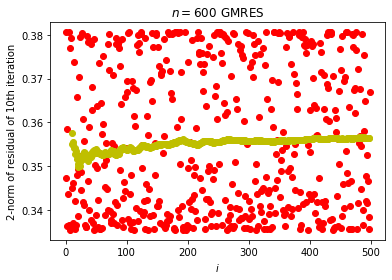

In [8]:
AVG=np.zeros((500,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,500)
for j in range(0,500):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=600$ GMRES')
pp.savefig('GMRES.png')

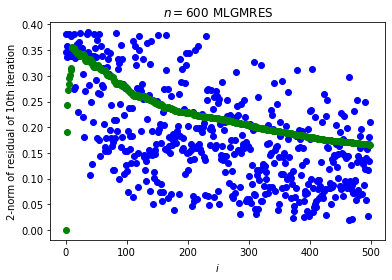

In [9]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((500,1))

for j in range(0,500):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'og')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=600$ MLGMRES')
pp.savefig('MLGMRES.png')

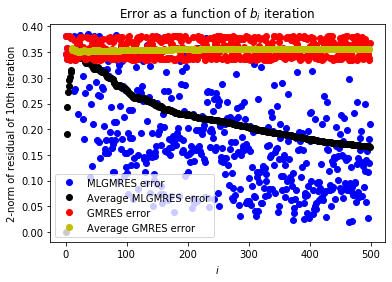

In [10]:
pp.plot(count,Err_Array_ML,'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,Err_Array,'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')